Thanks for:
* https://www.kaggle.com/sishihara/moa-lgbm-benchmark#Preprocessing

* https://www.kaggle.com/ttahara/osic-baseline-lgbm-with-custom-metric

* https://zenn.dev/fkubota/articles/2b8d46b11c178ac2fa2d



In [1]:
# Version = "v1" # starter model
# Version = "v2" # Compare treat Vs. ctrl and minor modifications, StratifiedKFold
# Version = "v3" # Add debug mode and minor modifications
# Version = "v4" # Clipping a control with an outlier(25-75)

Version = "v5" # Clipping a control with an outlier(20-80)

In [2]:
DEBUG = True

# Library

In [3]:
import lightgbm as lgb
from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import os
import random

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold

from tqdm.notebook import tqdm
import torch

import warnings
warnings.filterwarnings("ignore")

# Utils

In [4]:
def get_logger(filename='log'):
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.{Version}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

logger = get_logger()


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# Config

In [5]:
if DEBUG:
    N_FOLD = 2
    Num_boost_round=1000
    Early_stopping_rounds=10
    Learning_rate = 0.03
else:
    N_FOLD = 5
    Num_boost_round=10000
    Early_stopping_rounds=20
    Learning_rate = 0.01

SEED = 42
seed_everything(seed=SEED)

# Data Loading

In [6]:
train = pd.read_csv("../input/lish-moa/train_features.csv")
test = pd.read_csv("../input/lish-moa/test_features.csv")
train_targets_scored = pd.read_csv("../input/lish-moa/train_targets_scored.csv")
train_targets_nonscored = pd.read_csv("../input/lish-moa/train_targets_nonscored.csv")
sub = pd.read_csv("../input/lish-moa/sample_submission.csv")

In [7]:
def label_encoding(train: pd.DataFrame, test: pd.DataFrame, encode_cols):
    n_train = len(train)
    train = pd.concat([train, test], sort=False).reset_index(drop=True)
    for f in encode_cols:
        try:
            lbl = preprocessing.LabelEncoder()
            train[f] = lbl.fit_transform(list(train[f].values))
        except:
            print(f)
    test = train[n_train:].reset_index(drop=True)
    train = train[:n_train]
    return train, test

# Training Utils

In [8]:
#===========================================================
# model
#===========================================================
def run_lgbm(target_col: str, ctr):
    
    target = train_targets_scored[target_col]
    trt = train[target==1].copy().reset_index(drop=True)
    trt["target"] = 1
    
    X_train = pd.concat([trt, ctr], axis=0).reset_index(drop=True)
    y_train = X_train["target"]
    
    X_train = X_train.drop(["sig_id", "target", "cp_type"], axis=1)
    X_test = test.drop(["sig_id", "cp_type"], axis=1)
    
    y_preds = []
    models = []
    oof_train = np.zeros((len(X_train),))
    score = 0
    
    logger.info(f'len(trt) : {len(trt)}')
    
    for fold_, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
        logger.info(f'len(train_index) : {len(train_index)}')
        logger.info(f'len(valid_index) : {len(valid_index)}')
        
        X_tr = X_train.loc[train_index, :]
        X_val = X_train.loc[valid_index, :]
        y_tr = y_train[train_index]
        y_val = y_train[valid_index]

        lgb_train = lgb.Dataset(X_tr,
                                y_tr,
                                categorical_feature=categorical_cols)

        lgb_eval = lgb.Dataset(X_val,
                               y_val,
                               reference=lgb_train,
                               categorical_feature=categorical_cols)
        
        logger.info(f"================================= {fold_+1}fold lightgbm =================================")

        model = lgb.train(params,
                          lgb_train,
                          valid_sets=[lgb_train, lgb_eval],
                          verbose_eval=20,
                          num_boost_round=Num_boost_round,
                          early_stopping_rounds=Early_stopping_rounds)
        
        oof_train[valid_index] = model.predict(X_val, num_iteration=model.best_iteration)


        y_pred = model.predict(X_test, num_iteration=model.best_iteration)

        y_preds.append(y_pred)
        models.append(model)
    
    score = log_loss(y_train, oof_train)
    
    logger.info(f"{target_col} logloss: {score}")
    logger.info(f"=========================================================================================")

    return sum(y_preds) / len(y_preds), score, models, 

In [9]:
def show_feature_importance(feature_importance_df):
    cols = (feature_importance_df[["Feature", "importance"]]
            .groupby("Feature")
            .mean()
            .sort_values(by="importance", ascending=False)[:100].index)
    best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

    plt.figure(figsize=(8, 30))
    sns.barplot(x="importance", 
                y="Feature", 
                data=best_features.sort_values(by="importance", ascending=False))
    plt.title('Features importance (averaged)')
    plt.tight_layout()
    plt.savefig(f"./feature_importance_{Version}.png")
    plt.show()

# Preprocessing

We have to convert some categorical features into numbers in train and test. We can identify categorical features by `pd.DataFrame.select_dtypes`.

In [10]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,trt_cp,24,D1,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,trt_cp,72,D1,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,trt_cp,48,D1,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,trt_cp,48,D1,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,trt_cp,72,D2,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [11]:
train.select_dtypes(include=['object']).columns

Index(['sig_id', 'cp_type', 'cp_dose'], dtype='object')

In [12]:
train, test = label_encoding(train, test, ['cp_type', 'cp_dose'])

In [13]:
train.head()

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,1,24,0,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,...,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,1,72,0,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,...,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,1,48,0,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,...,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,1,48,0,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,...,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,1,72,1,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,...,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [14]:
# Select control data
ctl = train[(train.cp_type==0)]
ctl

,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
25,id_0054388ec,0,48,0,-0.6696,-0.2718,-1.2230,-0.6226,-0.7220,0.1588,...,0.6171,0.6405,0.5429,0.3562,1.3290,0.5573,0.8837,0.5534,0.8976,1.0050
38,id_0079af0fb,0,24,0,-0.1636,-1.8230,-0.5211,0.3054,-1.1280,0.6041,...,-0.3880,-0.6828,-0.6594,-0.2043,0.3571,-0.1319,0.2187,0.0737,0.6498,-1.4820
40,id_007bfbb91,0,24,1,-1.3200,-1.7340,-0.0741,1.5440,-1.8290,-0.0951,...,0.7412,1.0340,0.7393,1.1020,0.3786,0.2636,-0.5751,0.3362,0.8543,0.9180
47,id_008a986b7,0,48,1,0.4860,0.1430,0.5281,-0.0022,-0.2334,-0.6607,...,-0.3085,-0.1866,0.7629,0.3288,-0.9915,-0.3694,-0.4979,0.5281,-0.9245,-0.9367
63,id_009d8340f,0,24,1,0.4471,-0.0839,-0.3864,0.3196,0.2584,-0.3156,...,0.4795,0.3939,0.7665,0.7932,-0.6804,-0.0435,0.0949,0.2000,-0.4326,0.9364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23729,id_ff1f9e5fc,0,24,0,0.0465,0.6430,-0.2453,0.3521,0.6195,-0.6659,...,0.6085,0.1621,-0.2065,0.8314,-0.1891,-0.0074,0.2131,-0.1419,-0.2422,0.0457
23747,id_ff469c482,0,72,0,-0.6204,-1.3800,-1.1880,-0.6573,-0.8408,-0.2447,...,0.8209,0.7366,0.5468,1.1450,0.5254,0.6224,-0.9630,0.8872,-0.0742,-0.6777
23768,id_ff89331ca,0,72,1,-0.1051,0.4335,0.3648,-0.0525,-0.3632,-0.3228,...,-0.1219,0.4885,0.4963,0.9434,-0.4779,0.6951,0.9517,-0.8110,-0.1748,-0.3626
23793,id_ffd26f361,0,48,1,0.6008,0.2781,-0.3319,-0.8782,0.9281,0.7535,...,1.2470,0.9569,-0.2065,-0.4918,0.7863,0.0504,0.8813,0.7757,-0.5272,0.7082


In [15]:
# clipping

def outlaier_clip(df):
    df = df.copy()
    clipping = df.columns[4:]
    for col in clipping:
        upper, lower = np.percentile(df[col], [20, 80])
        df[col] = np.clip(df[col], upper, lower)
    
    return df

ctl_df = pd.DataFrame(columns=train.columns)
for i in ctl.cp_time.unique():
    for j in ctl.cp_dose.unique():
        print(len(ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]))
        tmp_ctl = ctl[(ctl.cp_time==i) & (ctl.cp_dose==j)]
        tmp_ctl = outlaier_clip(tmp_ctl)
        ctl_df = pd.concat([ctl_df, tmp_ctl],axis=0).reset_index(drop=True)
ctl_df

343
305
301
305
307
305


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_0054388ec,0,48,0,-0.66960,-0.27180,-0.69462,-0.52590,-0.72200,0.15880,...,0.61710,0.64050,0.54290,0.35620,1.01260,0.55730,0.85766,0.55340,0.86888,0.99000
1,id_01b05de6c,0,48,0,-0.31760,0.23072,-0.37730,0.49774,-0.48770,0.34130,...,0.21890,-0.24212,0.70354,0.33890,0.74370,0.75330,0.24060,0.50570,0.80170,0.99000
2,id_020ba48d9,0,48,0,0.59264,-0.33390,0.73572,-0.41920,0.45450,-0.40514,...,-0.20012,-0.24212,-0.24420,0.05570,-0.04850,-0.15696,-0.33016,-0.25144,0.36020,-0.00716
3,id_02c93b4a5,0,48,0,-0.08840,-1.13200,0.55620,0.46610,-0.16830,0.84190,...,-0.20012,0.47660,0.70354,0.46130,0.89570,0.82270,0.85766,0.79720,0.65420,0.05800
4,id_03bc6d412,0,48,0,0.59264,0.09310,-0.09580,-0.43370,0.54504,-0.40514,...,-0.20012,-0.24212,-0.29144,-0.05584,0.12700,0.35110,0.12330,-0.25144,0.17670,0.11530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1861,id_fbb620181,0,72,1,-0.34900,0.72970,-1.18920,-0.52336,0.91858,-0.97840,...,-0.51532,-0.48866,-0.55696,-0.02430,-0.44654,0.59806,-0.50942,-0.42608,-0.19490,-0.12740
1862,id_fbba92030,0,72,1,-0.63910,0.77178,0.38808,0.66622,-0.56166,-0.84690,...,0.59024,0.60446,0.54674,0.69300,0.63246,0.59806,0.64624,-0.03440,-0.01860,0.51730
1863,id_fbc0849ad,0,72,1,-0.29480,0.21960,-0.32520,-0.20840,-0.56166,0.35420,...,0.59024,0.50140,0.54674,0.45600,-0.33600,-0.38402,0.64624,0.62030,0.66932,0.45040
1864,id_fd93fa37d,0,72,1,-0.29840,-0.47880,-1.18920,-0.52336,0.91858,0.45488,...,0.03080,-0.44220,-0.55696,-0.35564,-0.44654,0.41030,0.44620,-0.42608,-0.19490,0.19250


In [16]:
ctl_df["target"] = 0

In [17]:
ctl_df.cp_type = ctl_df.cp_type.astype('int64')
ctl_df.cp_time = ctl_df.cp_time.astype('int64')
ctl_df.cp_dose = ctl_df.cp_dose.astype('int64')
ctl_df.dtypes

sig_id      object
cp_type      int64
cp_time      int64
cp_dose      int64
g-0        float64
            ...   
c-96       float64
c-97       float64
c-98       float64
c-99       float64
target       int64
Length: 877, dtype: object

# Modeling

In [18]:
cv = StratifiedKFold(n_splits=N_FOLD, shuffle=True, random_state=SEED)

params = {
    'num_leaves': 24,
    'max_depth': 5,
    'objective': 'binary',
    'learning_rate': Learning_rate
}

categorical_cols = ['cp_time', 'cp_dose']
feature_importance_df = pd.DataFrame()
models = []
scores = []

In [19]:
for target_col in tqdm(train_targets_scored.columns[1:]):
    _preds, _score, models,  = run_lgbm(target_col, ctl_df)

    sub[target_col] = _preds
    scores.append(_score)
        
    for model in models:
        _importance_df = pd.DataFrame()
        _importance_df["Feature"] = train.columns[2:]
        _importance_df["importance"] = model.feature_importance(importance_type='gain')
        feature_importance_df = pd.concat([feature_importance_df, _importance_df], axis=0)

len(trt) : 17
len(train_index) : 941
len(valid_index) : 942
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0143342	valid_1's binary_logloss: 0.0327439
[40]	training's binary_logloss: 0.00745638	valid_1's binary_logloss: 0.0275167
[60]	training's binary_logloss: 0.00414996	valid_1's binary_logloss: 0.025558
[80]	training's binary_logloss: 0.00234502	valid_1's binary_logloss: 0.0251704


len(train_index) : 942
len(valid_index) : 941


[100]	training's binary_logloss: 0.00134521	valid_1's binary_logloss: 0.0251028
Early stopping, best iteration is:
[95]	training's binary_logloss: 0.00154112	valid_1's binary_logloss: 0.0248987


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0153766	valid_1's binary_logloss: 0.0268023
[40]	training's binary_logloss: 0.00775558	valid_1's binary_logloss: 0.0241001
[60]	training's binary_logloss: 0.00421506	valid_1's binary_logloss: 0.022905
[80]	training's binary_logloss: 0.00232711	valid_1's binary_logloss: 0.0226172


5-alpha_reductase_inhibitor logloss: 0.023716958762848114
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[79]	training's binary_logloss: 0.00239492	valid_1's binary_logloss: 0.022534
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.014768	valid_1's binary_logloss: 0.0412003
[40]	training's binary_logloss: 0.00759102	valid_1's binary_logloss: 0.0371566
[60]	training's binary_logloss: 0.00417209	valid_1's binary_logloss: 0.0345641
[80]	training's binary_logloss: 0.00235558	valid_1's binary_logloss: 0.0327693
[100]	training's binary_logloss: 0.00134819	valid_1's binary_logloss: 0.032066


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


[120]	training's binary_logloss: 0.000774225	valid_1's binary_logloss: 0.0324555
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.00102225	valid_1's binary_logloss: 0.0319462
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.015009	valid_1's binary_logloss: 0.0355033
[40]	training's binary_logloss: 0.00766434	valid_1's binary_logloss: 0.0311411
[60]	training's binary_logloss: 0.00415839	valid_1's binary_logloss: 0.0296176


11-beta-hsd1_inhibitor logloss: 0.030742966810432818
len(trt) : 24
len(train_index) : 945
len(valid_index) : 945
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[63]	training's binary_logloss: 0.00378819	valid_1's binary_logloss: 0.0295397
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0221035	valid_1's binary_logloss: 0.0554884


len(train_index) : 945
len(valid_index) : 945
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.0116078	valid_1's binary_logloss: 0.0545899
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.0135684	valid_1's binary_logloss: 0.0545419
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0240966	valid_1's binary_logloss: 0.0581609
[40]	training's binary_logloss: 0.0128111	valid_1's binary_logloss: 0.0561477


acat_inhibitor logloss: 0.05520889453941809
len(trt) : 190
len(train_index) : 1028
len(valid_index) : 1028
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[45]	training's binary_logloss: 0.0110564	valid_1's binary_logloss: 0.0558758
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.125849	valid_1's binary_logloss: 0.179723
[40]	training's binary_logloss: 0.0698236	valid_1's binary_logloss: 0.134756
[60]	training's binary_logloss: 0.0401305	valid_1's binary_logloss: 0.110518
[80]	training's binary_logloss: 0.0237466	valid_1's binary_logloss: 0.0965447
[100]	training's binary_logloss: 0.0140505	valid_1's binary_logloss: 0.0871656
[120]	training's binary_logloss: 0.00835234	valid_1's binary_logloss: 0.0822564
[140]	training's binary_logloss: 0.00501698	valid_1's binary_logloss: 0.0789449
[160]	training's binary_logloss: 0.00303602	valid_1's binary_logloss: 0.0778536


len(train_index) : 1028
len(valid_index) : 1028
================================= 2fold lightgbm =================================


[180]	training's binary_logloss: 0.00183171	valid_1's binary_logloss: 0.0780806
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00224232	valid_1's binary_logloss: 0.0774263
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.138613	valid_1's binary_logloss: 0.186547
[40]	training's binary_logloss: 0.0778376	valid_1's binary_logloss: 0.139049
[60]	training's binary_logloss: 0.0452996	valid_1's binary_logloss: 0.110037
[80]	training's binary_logloss: 0.0273669	valid_1's binary_logloss: 0.0928435
[100]	training's binary_logloss: 0.0167601	valid_1's binary_logloss: 0.0817794
[120]	training's binary_logloss: 0.0102758	valid_1's binary_logloss: 0.0745373
[140]	training's binary_logloss: 0.00643773	valid_1's binary_logloss: 0.0703032
[160]	training's binary_logloss: 0.004055	valid_1's binary_logloss: 0.0676735
[180]	training's binary_logloss: 0.00256001	valid_1's binary_logloss: 0.0660601
[200]	training's binary_logloss: 0.00162

acetylcholine_receptor_agonist logloss: 0.0699104544509147
len(trt) : 301
len(train_index) : 1083
len(valid_index) : 1084
================================= 1fold lightgbm =================================


[220]	training's binary_logloss: 0.00102878	valid_1's binary_logloss: 0.062704
Early stopping, best iteration is:
[211]	training's binary_logloss: 0.0012621	valid_1's binary_logloss: 0.0623946
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.178182	valid_1's binary_logloss: 0.200258
[40]	training's binary_logloss: 0.0985518	valid_1's binary_logloss: 0.131905
[60]	training's binary_logloss: 0.0563671	valid_1's binary_logloss: 0.0940731
[80]	training's binary_logloss: 0.0332672	valid_1's binary_logloss: 0.0728059
[100]	training's binary_logloss: 0.0199756	valid_1's binary_logloss: 0.0586622
[120]	training's binary_logloss: 0.0121613	valid_1's binary_logloss: 0.0503776
[140]	training's binary_logloss: 0.00738544	valid_1's binary_logloss: 0.0446292
[160]	training's binary_logloss: 0.0044934	valid_1's binary_logloss: 0.0414935
[180]	training's binary_logloss: 0.00274541	valid_1's binary_logloss: 0.0393785
[200]	training's binary_logloss: 0.00168

len(train_index) : 1084
len(valid_index) : 1083
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.180946	valid_1's binary_logloss: 0.20805
[40]	training's binary_logloss: 0.0998625	valid_1's binary_logloss: 0.13667
[60]	training's binary_logloss: 0.0583372	valid_1's binary_logloss: 0.0966546
[80]	training's binary_logloss: 0.0349121	valid_1's binary_logloss: 0.0732067
[100]	training's binary_logloss: 0.0210663	valid_1's binary_logloss: 0.0573357
[120]	training's binary_logloss: 0.0129897	valid_1's binary_logloss: 0.046836
[140]	training's binary_logloss: 0.00803603	valid_1's binary_logloss: 0.0410948
[160]	training's binary_logloss: 0.00501975	valid_1's binary_logloss: 0.036699
[180]	training's binary_logloss: 0.00315242	valid_1's binary_logloss: 0.0340856
[200]	training's binary_logloss: 0.0019793	valid_1's binary_logloss: 0.0322338
[220]	training's binary_logloss: 0.00124266	valid_1's binary_logloss: 0.030403
[240]	training's binary_logloss: 0.000776277	valid_1's binary_logloss: 0.02856

acetylcholine_receptor_antagonist logloss: 0.024790906392415036
len(trt) : 73
len(train_index) : 969
len(valid_index) : 970
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[448]	training's binary_logloss: 7.50152e-06	valid_1's binary_logloss: 0.0201392
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0611462	valid_1's binary_logloss: 0.0925816
[40]	training's binary_logloss: 0.0326471	valid_1's binary_logloss: 0.0731883
[60]	training's binary_logloss: 0.0184767	valid_1's binary_logloss: 0.0632714
[80]	training's binary_logloss: 0.0107529	valid_1's binary_logloss: 0.0581805
[100]	training's binary_logloss: 0.00637915	valid_1's binary_logloss: 0.0559415


len(train_index) : 970
len(valid_index) : 969
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[108]	training's binary_logloss: 0.00518795	valid_1's binary_logloss: 0.0548959
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0575472	valid_1's binary_logloss: 0.0931571
[40]	training's binary_logloss: 0.0309094	valid_1's binary_logloss: 0.0763318
[60]	training's binary_logloss: 0.0173552	valid_1's binary_logloss: 0.0663342
[80]	training's binary_logloss: 0.0101001	valid_1's binary_logloss: 0.0638263
[100]	training's binary_logloss: 0.00592073	valid_1's binary_logloss: 0.0623367


acetylcholinesterase_inhibitor logloss: 0.05834280092041864
len(trt) : 54
len(train_index) : 960
len(valid_index) : 960
================================= 1fold lightgbm =================================


[120]	training's binary_logloss: 0.00349307	valid_1's binary_logloss: 0.0620684
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.00454543	valid_1's binary_logloss: 0.0617933
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0484955	valid_1's binary_logloss: 0.0850381
[40]	training's binary_logloss: 0.0263112	valid_1's binary_logloss: 0.071732
[60]	training's binary_logloss: 0.0149137	valid_1's binary_logloss: 0.0663068


len(train_index) : 960
len(valid_index) : 960
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[63]	training's binary_logloss: 0.0138169	valid_1's binary_logloss: 0.0655077
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0454978	valid_1's binary_logloss: 0.0890794
[40]	training's binary_logloss: 0.0247091	valid_1's binary_logloss: 0.0845562
[60]	training's binary_logloss: 0.0141718	valid_1's binary_logloss: 0.0840299


adenosine_receptor_agonist logloss: 0.0747531541127683
len(trt) : 96
len(train_index) : 981
len(valid_index) : 981
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[69]	training's binary_logloss: 0.011151	valid_1's binary_logloss: 0.0839986
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0750238	valid_1's binary_logloss: 0.109017
[40]	training's binary_logloss: 0.0402323	valid_1's binary_logloss: 0.0824332
[60]	training's binary_logloss: 0.0228571	valid_1's binary_logloss: 0.0673636
[80]	training's binary_logloss: 0.0132218	valid_1's binary_logloss: 0.0601351
[100]	training's binary_logloss: 0.00770763	valid_1's binary_logloss: 0.0567234
[120]	training's binary_logloss: 0.00451451	valid_1's binary_logloss: 0.0554381


len(train_index) : 981
len(valid_index) : 981
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[126]	training's binary_logloss: 0.00385035	valid_1's binary_logloss: 0.0550577
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0746603	valid_1's binary_logloss: 0.107546
[40]	training's binary_logloss: 0.0397682	valid_1's binary_logloss: 0.0811526
[60]	training's binary_logloss: 0.0223984	valid_1's binary_logloss: 0.0686369
[80]	training's binary_logloss: 0.0128398	valid_1's binary_logloss: 0.0604773
[100]	training's binary_logloss: 0.00739208	valid_1's binary_logloss: 0.0566799
[120]	training's binary_logloss: 0.00429747	valid_1's binary_logloss: 0.0539227
[140]	training's binary_logloss: 0.00251684	valid_1's binary_logloss: 0.0517801
[160]	training's binary_logloss: 0.00148108	valid_1's binary_logloss: 0.0507006
[180]	training's binary_logloss: 0.000875899	valid_1's binary_logloss: 0.0500199


adenosine_receptor_antagonist logloss: 0.052478438512039975
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[179]	training's binary_logloss: 0.00089973	valid_1's binary_logloss: 0.0498992
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0103861	valid_1's binary_logloss: 0.0238296
[40]	training's binary_logloss: 0.00543841	valid_1's binary_logloss: 0.0215374
[60]	training's binary_logloss: 0.00304081	valid_1's binary_logloss: 0.0201722
[80]	training's binary_logloss: 0.00173507	valid_1's binary_logloss: 0.0194032
[100]	training's binary_logloss: 0.00100513	valid_1's binary_logloss: 0.0183722
[120]	training's binary_logloss: 0.000587319	valid_1's binary_logloss: 0.0176049
[140]	training's binary_logloss: 0.000344658	valid_1's binary_logloss: 0.0174312
[160]	training's binary_logloss: 0.00020198	valid_1's binary_logloss: 0.0172964


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.00017263	valid_1's binary_logloss: 0.0170009
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00987911	valid_1's binary_logloss: 0.0269881
[40]	training's binary_logloss: 0.00502072	valid_1's binary_logloss: 0.024341
[60]	training's binary_logloss: 0.00274483	valid_1's binary_logloss: 0.0225769
[80]	training's binary_logloss: 0.00153115	valid_1's binary_logloss: 0.0221022


adenylyl_cyclase_activator logloss: 0.019449902730760107
len(trt) : 270
len(train_index) : 1068
len(valid_index) : 1068
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[86]	training's binary_logloss: 0.00129066	valid_1's binary_logloss: 0.021899
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.164924	valid_1's binary_logloss: 0.186996
[40]	training's binary_logloss: 0.0891929	valid_1's binary_logloss: 0.115817
[60]	training's binary_logloss: 0.0513957	valid_1's binary_logloss: 0.0795462
[80]	training's binary_logloss: 0.0304167	valid_1's binary_logloss: 0.0594626
[100]	training's binary_logloss: 0.0182261	valid_1's binary_logloss: 0.0475549
[120]	training's binary_logloss: 0.0109819	valid_1's binary_logloss: 0.0397308
[140]	training's binary_logloss: 0.00663929	valid_1's binary_logloss: 0.0346697
[160]	training's binary_logloss: 0.00403061	valid_1's binary_logloss: 0.0311539
[180]	training's binary_logloss: 0.00244694	valid_1's binary_logloss: 0.0305404
[200]	training's binary_logloss: 0.00150433	valid_1's binary_logloss: 0.0292559
[220]	training's binary_logloss: 0.0009

len(train_index) : 1068
len(valid_index) : 1068
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[242]	training's binary_logloss: 0.000546676	valid_1's binary_logloss: 0.0282465
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.15882	valid_1's binary_logloss: 0.192463
[40]	training's binary_logloss: 0.0853265	valid_1's binary_logloss: 0.130926
[60]	training's binary_logloss: 0.0484221	valid_1's binary_logloss: 0.097084
[80]	training's binary_logloss: 0.0283396	valid_1's binary_logloss: 0.0781922
[100]	training's binary_logloss: 0.0168026	valid_1's binary_logloss: 0.0653482
[120]	training's binary_logloss: 0.0100149	valid_1's binary_logloss: 0.0567486
[140]	training's binary_logloss: 0.00597462	valid_1's binary_logloss: 0.050167
[160]	training's binary_logloss: 0.00356346	valid_1's binary_logloss: 0.0459365
[180]	training's binary_logloss: 0.00212562	valid_1's binary_logloss: 0.043444
[200]	training's binary_logloss: 0.00127413	valid_1's binary_logloss: 0.04196
[220]	training's binary_logloss: 0.0007643

adrenergic_receptor_agonist logloss: 0.03269769340804146
len(trt) : 360
len(train_index) : 1113
len(valid_index) : 1113
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.19982	valid_1's binary_logloss: 0.23432
[40]	training's binary_logloss: 0.112139	valid_1's binary_logloss: 0.158663
[60]	training's binary_logloss: 0.0661498	valid_1's binary_logloss: 0.116466
[80]	training's binary_logloss: 0.0401302	valid_1's binary_logloss: 0.0924752
[100]	training's binary_logloss: 0.0245617	valid_1's binary_logloss: 0.075422
[120]	training's binary_logloss: 0.0152458	valid_1's binary_logloss: 0.0647043
[140]	training's binary_logloss: 0.0095085	valid_1's binary_logloss: 0.0582969
[160]	training's binary_logloss: 0.00595671	valid_1's binary_logloss: 0.0534119
[180]	training's binary_logloss: 0.00375456	valid_1's binary_logloss: 0.0499921
[200]	training's binary_logloss: 0.00237479	valid_1's binary_logloss: 0.0479133
[220]	training's binary_logloss: 0.00150139	valid_1's binary_logloss: 0.0457164
[240]	training's binary_logloss: 0.000947202	valid_1's binary_logloss: 0.04407

len(train_index) : 1113
len(valid_index) : 1113
================================= 2fold lightgbm =================================


[360]	training's binary_logloss: 6.19995e-05	valid_1's binary_logloss: 0.0387801
Early stopping, best iteration is:
[352]	training's binary_logloss: 7.42763e-05	valid_1's binary_logloss: 0.0379997
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.20297	valid_1's binary_logloss: 0.232015
[40]	training's binary_logloss: 0.114983	valid_1's binary_logloss: 0.153534
[60]	training's binary_logloss: 0.0677607	valid_1's binary_logloss: 0.10917
[80]	training's binary_logloss: 0.0405762	valid_1's binary_logloss: 0.0825894
[100]	training's binary_logloss: 0.0249531	valid_1's binary_logloss: 0.0674613
[120]	training's binary_logloss: 0.0154845	valid_1's binary_logloss: 0.056309
[140]	training's binary_logloss: 0.00969385	valid_1's binary_logloss: 0.0493574
[160]	training's binary_logloss: 0.00609614	valid_1's binary_logloss: 0.0450695
[180]	training's binary_logloss: 0.00387863	valid_1's binary_logloss: 0.0433369
[200]	training's binary_logloss: 0.00246

adrenergic_receptor_antagonist logloss: 0.038821055198589145
len(trt) : 66
len(train_index) : 966
len(valid_index) : 966
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0485233	valid_1's binary_logloss: 0.0806131
[40]	training's binary_logloss: 0.0252601	valid_1's binary_logloss: 0.0618429
[60]	training's binary_logloss: 0.0138282	valid_1's binary_logloss: 0.0510806
[80]	training's binary_logloss: 0.00768529	valid_1's binary_logloss: 0.0451977
[100]	training's binary_logloss: 0.00434908	valid_1's binary_logloss: 0.0443142


len(train_index) : 966
len(valid_index) : 966
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[103]	training's binary_logloss: 0.00399277	valid_1's binary_logloss: 0.0441415
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0472885	valid_1's binary_logloss: 0.0663397
[40]	training's binary_logloss: 0.0242917	valid_1's binary_logloss: 0.0494205
[60]	training's binary_logloss: 0.0129493	valid_1's binary_logloss: 0.0417646
[80]	training's binary_logloss: 0.00712714	valid_1's binary_logloss: 0.0385573
[100]	training's binary_logloss: 0.00400297	valid_1's binary_logloss: 0.0374006


akt_inhibitor logloss: 0.04076306820585183
len(trt) : 7
len(train_index) : 936
len(valid_index) : 937
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[103]	training's binary_logloss: 0.00367457	valid_1's binary_logloss: 0.0373847
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00526433	valid_1's binary_logloss: 0.0135859
[40]	training's binary_logloss: 0.00268394	valid_1's binary_logloss: 0.0100315
[60]	training's binary_logloss: 0.00146835	valid_1's binary_logloss: 0.00802107
[80]	training's binary_logloss: 0.000822849	valid_1's binary_logloss: 0.0069258
[100]	training's binary_logloss: 0.000466714	valid_1's binary_logloss: 0.00573378
[120]	training's binary_logloss: 0.000266859	valid_1's binary_logloss: 0.00483061
[140]	training's binary_logloss: 0.000152983	valid_1's binary_logloss: 0.00407292
[160]	training's binary_logloss: 8.79331e-05	valid_1's binary_logloss: 0.003546
[180]	training's binary_logloss: 5.07919e-05	valid_1's binary_logloss: 0.00295523
[200]	training's binary_logloss: 2.93871e-05	valid_1's binary_logloss: 0.00239638
[220]	training's

len(train_index) : 937
len(valid_index) : 936
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00687938	valid_1's binary_logloss: 0.00825968
[40]	training's binary_logloss: 0.00349974	valid_1's binary_logloss: 0.00558103
[60]	training's binary_logloss: 0.00191473	valid_1's binary_logloss: 0.00405871
[80]	training's binary_logloss: 0.00107222	valid_1's binary_logloss: 0.00317588
[100]	training's binary_logloss: 0.00060645	valid_1's binary_logloss: 0.00268646
[120]	training's binary_logloss: 0.000345793	valid_1's binary_logloss: 0.00226849
[140]	training's binary_logloss: 0.0001973	valid_1's binary_logloss: 0.00199073


aldehyde_dehydrogenase_inhibitor logloss: 0.0017060289712231631
len(trt) : 42
len(train_index) : 954
len(valid_index) : 954
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.000171287	valid_1's binary_logloss: 0.00188189
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0331538	valid_1's binary_logloss: 0.0683782
[40]	training's binary_logloss: 0.0173089	valid_1's binary_logloss: 0.056962
[60]	training's binary_logloss: 0.00954269	valid_1's binary_logloss: 0.0514565
[80]	training's binary_logloss: 0.00542704	valid_1's binary_logloss: 0.0484268
[100]	training's binary_logloss: 0.00313809	valid_1's binary_logloss: 0.0468523


len(train_index) : 954
len(valid_index) : 954
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[106]	training's binary_logloss: 0.00265204	valid_1's binary_logloss: 0.0465878
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0350547	valid_1's binary_logloss: 0.0571451
[40]	training's binary_logloss: 0.0184708	valid_1's binary_logloss: 0.0463719
[60]	training's binary_logloss: 0.0103083	valid_1's binary_logloss: 0.0407446
[80]	training's binary_logloss: 0.00586472	valid_1's binary_logloss: 0.0369339
[100]	training's binary_logloss: 0.00338042	valid_1's binary_logloss: 0.0347618
[120]	training's binary_logloss: 0.00198431	valid_1's binary_logloss: 0.0338311
[140]	training's binary_logloss: 0.00116565	valid_1's binary_logloss: 0.0335738
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0013257	valid_1's binary_logloss: 0.0334819


alk_inhibitor logloss: 0.04003484080392474
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0129024	valid_1's binary_logloss: 0.0292039
[40]	training's binary_logloss: 0.00672562	valid_1's binary_logloss: 0.0280024


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.0052705	valid_1's binary_logloss: 0.0277031
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0112044	valid_1's binary_logloss: 0.0340938


ampk_activator logloss: 0.03082716890763393
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


[40]	training's binary_logloss: 0.00589145	valid_1's binary_logloss: 0.0342758
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.00798696	valid_1's binary_logloss: 0.0339513
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.012963	valid_1's binary_logloss: 0.0309023
[40]	training's binary_logloss: 0.00646406	valid_1's binary_logloss: 0.0305855
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.0073817	valid_1's binary_logloss: 0.0304259


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0127378	valid_1's binary_logloss: 0.0286058
[40]	training's binary_logloss: 0.00676447	valid_1's binary_logloss: 0.0277142
[60]	training's binary_logloss: 0.00375952	valid_1's binary_logloss: 0.0276268
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.00424378	valid_1's binary_logloss: 0.0273726


analgesic logloss: 0.02889926848004001
len(trt) : 48
len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0409402	valid_1's binary_logloss: 0.067279
[40]	training's binary_logloss: 0.0218058	valid_1's binary_logloss: 0.0529259
[60]	training's binary_logloss: 0.0124323	valid_1's binary_logloss: 0.0452174
[80]	training's binary_logloss: 0.00710575	valid_1's binary_logloss: 0.0419285
[100]	training's binary_logloss: 0.00412292	valid_1's binary_logloss: 0.0404639
[120]	training's binary_logloss: 0.00242835	valid_1's binary_logloss: 0.0405753
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.00263082	valid_1's binary_logloss: 0.0401858


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0448776	valid_1's binary_logloss: 0.0752477
[40]	training's binary_logloss: 0.0238633	valid_1's binary_logloss: 0.0613504
[60]	training's binary_logloss: 0.0133807	valid_1's binary_logloss: 0.0564844
[80]	training's binary_logloss: 0.00772749	valid_1's binary_logloss: 0.0560542


androgen_receptor_agonist logloss: 0.04805022086131807
len(trt) : 89
len(train_index) : 977
len(valid_index) : 978
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.00676242	valid_1's binary_logloss: 0.0559147
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0682445	valid_1's binary_logloss: 0.100759
[40]	training's binary_logloss: 0.0366966	valid_1's binary_logloss: 0.0774208
[60]	training's binary_logloss: 0.0207986	valid_1's binary_logloss: 0.0673866
[80]	training's binary_logloss: 0.0120412	valid_1's binary_logloss: 0.0631657
[100]	training's binary_logloss: 0.00702576	valid_1's binary_logloss: 0.062033


len(train_index) : 978
len(valid_index) : 977
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[103]	training's binary_logloss: 0.00649558	valid_1's binary_logloss: 0.0612642
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0724193	valid_1's binary_logloss: 0.0998895
[40]	training's binary_logloss: 0.0383605	valid_1's binary_logloss: 0.0760394
[60]	training's binary_logloss: 0.0215767	valid_1's binary_logloss: 0.0644859
[80]	training's binary_logloss: 0.0123226	valid_1's binary_logloss: 0.0590739
[100]	training's binary_logloss: 0.00718323	valid_1's binary_logloss: 0.0557209
[120]	training's binary_logloss: 0.00422487	valid_1's binary_logloss: 0.0532479
[140]	training's binary_logloss: 0.00252072	valid_1's binary_logloss: 0.052488


androgen_receptor_antagonist logloss: 0.056720683240738146
len(trt) : 80
len(train_index) : 973
len(valid_index) : 973
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[144]	training's binary_logloss: 0.00226964	valid_1's binary_logloss: 0.0521726
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.062931	valid_1's binary_logloss: 0.101703
[40]	training's binary_logloss: 0.0341129	valid_1's binary_logloss: 0.083478
[60]	training's binary_logloss: 0.0194352	valid_1's binary_logloss: 0.0735868
[80]	training's binary_logloss: 0.0113009	valid_1's binary_logloss: 0.0685862
[100]	training's binary_logloss: 0.00664277	valid_1's binary_logloss: 0.0655953
[120]	training's binary_logloss: 0.00394231	valid_1's binary_logloss: 0.064727


len(train_index) : 973
len(valid_index) : 973
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[129]	training's binary_logloss: 0.00313123	valid_1's binary_logloss: 0.0640268
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0629093	valid_1's binary_logloss: 0.102742
[40]	training's binary_logloss: 0.0337467	valid_1's binary_logloss: 0.082853
[60]	training's binary_logloss: 0.0192091	valid_1's binary_logloss: 0.0722016
[80]	training's binary_logloss: 0.0112568	valid_1's binary_logloss: 0.0680504
[100]	training's binary_logloss: 0.00668436	valid_1's binary_logloss: 0.0646601
[120]	training's binary_logloss: 0.00398376	valid_1's binary_logloss: 0.0631574


anesthetic_-_local logloss: 0.0632367714638596
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[126]	training's binary_logloss: 0.00342048	valid_1's binary_logloss: 0.0624467
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0316632	valid_1's binary_logloss: 0.0701866
[40]	training's binary_logloss: 0.016994	valid_1's binary_logloss: 0.0669396


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0138164	valid_1's binary_logloss: 0.0663725
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0346819	valid_1's binary_logloss: 0.0610218
[40]	training's binary_logloss: 0.018111	valid_1's binary_logloss: 0.0558094
[60]	training's binary_logloss: 0.0100363	valid_1's binary_logloss: 0.0533521


angiogenesis_inhibitor logloss: 0.0597080460172088
len(trt) : 37
len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.00896622	valid_1's binary_logloss: 0.0530436
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0322555	valid_1's binary_logloss: 0.0611214
[40]	training's binary_logloss: 0.0170675	valid_1's binary_logloss: 0.0546026
[60]	training's binary_logloss: 0.00974503	valid_1's binary_logloss: 0.0507338
[80]	training's binary_logloss: 0.00568263	valid_1's binary_logloss: 0.0484991


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[83]	training's binary_logloss: 0.00524595	valid_1's binary_logloss: 0.0481634
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0343572	valid_1's binary_logloss: 0.0627077
[40]	training's binary_logloss: 0.0183323	valid_1's binary_logloss: 0.0532141
[60]	training's binary_logloss: 0.0104858	valid_1's binary_logloss: 0.0488789
[80]	training's binary_logloss: 0.00609018	valid_1's binary_logloss: 0.0470316
[100]	training's binary_logloss: 0.00355329	valid_1's binary_logloss: 0.0463333


angiotensin_receptor_antagonist logloss: 0.04723562357225363
len(trt) : 73
len(train_index) : 969
len(valid_index) : 970
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[105]	training's binary_logloss: 0.00311729	valid_1's binary_logloss: 0.0463068
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.063399	valid_1's binary_logloss: 0.0954097
[40]	training's binary_logloss: 0.0339232	valid_1's binary_logloss: 0.07959
[60]	training's binary_logloss: 0.0194148	valid_1's binary_logloss: 0.0715245
[80]	training's binary_logloss: 0.0114568	valid_1's binary_logloss: 0.0685743
[100]	training's binary_logloss: 0.00685148	valid_1's binary_logloss: 0.067221
[120]	training's binary_logloss: 0.0041449	valid_1's binary_logloss: 0.0667673
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.00469992	valid_1's binary_logloss: 0.0664973


len(train_index) : 970
len(valid_index) : 969
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0575129	valid_1's binary_logloss: 0.0959783
[40]	training's binary_logloss: 0.0308175	valid_1's binary_logloss: 0.077248
[60]	training's binary_logloss: 0.0174168	valid_1's binary_logloss: 0.0699027
[80]	training's binary_logloss: 0.0100459	valid_1's binary_logloss: 0.0661959


anti-inflammatory logloss: 0.06574362338774518
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


[100]	training's binary_logloss: 0.00578335	valid_1's binary_logloss: 0.0650637
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.00700849	valid_1's binary_logloss: 0.0649891
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00525573	valid_1's binary_logloss: 0.017222


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[29]	training's binary_logloss: 0.00382642	valid_1's binary_logloss: 0.0168169
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00558974	valid_1's binary_logloss: 0.0146381
[40]	training's binary_logloss: 0.00291828	valid_1's binary_logloss: 0.0130971
[60]	training's binary_logloss: 0.00162435	valid_1's binary_logloss: 0.012079
[80]	training's binary_logloss: 0.000910447	valid_1's binary_logloss: 0.0115142
[100]	training's binary_logloss: 0.000515473	valid_1's binary_logloss: 0.0110404
[120]	training's binary_logloss: 0.000294383	valid_1's binary_logloss: 0.0107377
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.000338314	valid_1's binary_logloss: 0.0107161


antiarrhythmic logloss: 0.013766500371606046
len(trt) : 43
len(train_index) : 954
len(valid_index) : 955
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0364184	valid_1's binary_logloss: 0.0738535
[40]	training's binary_logloss: 0.0196371	valid_1's binary_logloss: 0.0646824
[60]	training's binary_logloss: 0.0110165	valid_1's binary_logloss: 0.0616683
[80]	training's binary_logloss: 0.00636725	valid_1's binary_logloss: 0.0612876


len(train_index) : 955
len(valid_index) : 954
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[81]	training's binary_logloss: 0.00619117	valid_1's binary_logloss: 0.0612093
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0396981	valid_1's binary_logloss: 0.07138
[40]	training's binary_logloss: 0.0216594	valid_1's binary_logloss: 0.0611904
[60]	training's binary_logloss: 0.0124566	valid_1's binary_logloss: 0.0568833
[80]	training's binary_logloss: 0.00731136	valid_1's binary_logloss: 0.0561895
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.00811861	valid_1's binary_logloss: 0.0556902


antibiotic logloss: 0.058451187969049606
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0109235	valid_1's binary_logloss: 0.0328669
[40]	training's binary_logloss: 0.00548579	valid_1's binary_logloss: 0.0316647


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[41]	training's binary_logloss: 0.00531125	valid_1's binary_logloss: 0.0316267
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0102618	valid_1's binary_logloss: 0.0267222
[40]	training's binary_logloss: 0.00514267	valid_1's binary_logloss: 0.0253896


anticonvulsant logloss: 0.028408681659932003
len(trt) : 13


[60]	training's binary_logloss: 0.0027887	valid_1's binary_logloss: 0.0252317
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.00344101	valid_1's binary_logloss: 0.0251907


len(train_index) : 939
len(valid_index) : 940
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0106202	valid_1's binary_logloss: 0.0279416
[40]	training's binary_logloss: 0.00563825	valid_1's binary_logloss: 0.0247088
[60]	training's binary_logloss: 0.00318997	valid_1's binary_logloss: 0.0234632


len(train_index) : 940
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.00300795	valid_1's binary_logloss: 0.0234015
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0120405	valid_1's binary_logloss: 0.0214536
[40]	training's binary_logloss: 0.00603971	valid_1's binary_logloss: 0.0171507
[60]	training's binary_logloss: 0.0032891	valid_1's binary_logloss: 0.0148747
[80]	training's binary_logloss: 0.00184955	valid_1's binary_logloss: 0.013725
[100]	training's binary_logloss: 0.0010593	valid_1's binary_logloss: 0.0132579
[120]	training's binary_logloss: 0.000613779	valid_1's binary_logloss: 0.0129431
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.00066651	valid_1's binary_logloss: 0.0128525


antifungal logloss: 0.018129815229616895
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0110105	valid_1's binary_logloss: 0.0337748


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[26]	training's binary_logloss: 0.00892067	valid_1's binary_logloss: 0.0333535
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0117891	valid_1's binary_logloss: 0.0334511
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.013924	valid_1's binary_logloss: 0.0334202


antihistamine logloss: 0.033386868281085204
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.016002	valid_1's binary_logloss: 0.0370819
[40]	training's binary_logloss: 0.0082696	valid_1's binary_logloss: 0.0333526


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.00650228	valid_1's binary_logloss: 0.0327543
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0164082	valid_1's binary_logloss: 0.0420693
[40]	training's binary_logloss: 0.00852851	valid_1's binary_logloss: 0.0401399


antimalarial logloss: 0.03614482207057782
len(trt) : 73
len(train_index) : 969
len(valid_index) : 970
================================= 1fold lightgbm =================================


[60]	training's binary_logloss: 0.00473747	valid_1's binary_logloss: 0.0397675
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.00632587	valid_1's binary_logloss: 0.0395354
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0651113	valid_1's binary_logloss: 0.100686
[40]	training's binary_logloss: 0.0353812	valid_1's binary_logloss: 0.0831344
[60]	training's binary_logloss: 0.0203736	valid_1's binary_logloss: 0.0771946
[80]	training's binary_logloss: 0.0121647	valid_1's binary_logloss: 0.0751236


len(train_index) : 970
len(valid_index) : 969
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[88]	training's binary_logloss: 0.00993265	valid_1's binary_logloss: 0.0748506
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0613897	valid_1's binary_logloss: 0.0922141
[40]	training's binary_logloss: 0.0337009	valid_1's binary_logloss: 0.0750151
[60]	training's binary_logloss: 0.0193032	valid_1's binary_logloss: 0.0665776
[80]	training's binary_logloss: 0.0113525	valid_1's binary_logloss: 0.0623999
[100]	training's binary_logloss: 0.00676635	valid_1's binary_logloss: 0.0607083


antioxidant logloss: 0.06746533194650842
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[104]	training's binary_logloss: 0.00612074	valid_1's binary_logloss: 0.0600724
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0351737	valid_1's binary_logloss: 0.0617053
[40]	training's binary_logloss: 0.0189801	valid_1's binary_logloss: 0.0536222
[60]	training's binary_logloss: 0.0104664	valid_1's binary_logloss: 0.0494761


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.00883601	valid_1's binary_logloss: 0.0486413
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0333779	valid_1's binary_logloss: 0.0545501
[40]	training's binary_logloss: 0.0179355	valid_1's binary_logloss: 0.0477091
[60]	training's binary_logloss: 0.0100221	valid_1's binary_logloss: 0.045577


antiprotozoal logloss: 0.046962480732492734
len(trt) : 23
len(train_index) : 944
len(valid_index) : 945
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.00822361	valid_1's binary_logloss: 0.0452836
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0198624	valid_1's binary_logloss: 0.0510454
[40]	training's binary_logloss: 0.0103616	valid_1's binary_logloss: 0.0461235
[60]	training's binary_logloss: 0.00580043	valid_1's binary_logloss: 0.0448038


len(train_index) : 945
len(valid_index) : 944
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[58]	training's binary_logloss: 0.00611798	valid_1's binary_logloss: 0.0447372
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0214331	valid_1's binary_logloss: 0.0504111
[40]	training's binary_logloss: 0.0114843	valid_1's binary_logloss: 0.0468314
[60]	training's binary_logloss: 0.00647641	valid_1's binary_logloss: 0.0456312
[80]	training's binary_logloss: 0.00376451	valid_1's binary_logloss: 0.045509
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.00418788	valid_1's binary_logloss: 0.0453904


antiviral logloss: 0.045063597229320025
len(trt) : 49
len(train_index) : 957
len(valid_index) : 958
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.042357	valid_1's binary_logloss: 0.0786247
[40]	training's binary_logloss: 0.022788	valid_1's binary_logloss: 0.0710741
[60]	training's binary_logloss: 0.0129553	valid_1's binary_logloss: 0.0659349
[80]	training's binary_logloss: 0.00760572	valid_1's binary_logloss: 0.0648924


len(train_index) : 958
len(valid_index) : 957
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.008237	valid_1's binary_logloss: 0.064734
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0438073	valid_1's binary_logloss: 0.0762329
[40]	training's binary_logloss: 0.0238518	valid_1's binary_logloss: 0.0649304
[60]	training's binary_logloss: 0.0138109	valid_1's binary_logloss: 0.0590023
[80]	training's binary_logloss: 0.00816699	valid_1's binary_logloss: 0.0569985
[100]	training's binary_logloss: 0.00482682	valid_1's binary_logloss: 0.0567469
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.00566365	valid_1's binary_logloss: 0.0563691


apoptosis_stimulant logloss: 0.06055373253139235
len(trt) : 47
len(train_index) : 956
len(valid_index) : 957
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0400017	valid_1's binary_logloss: 0.0864897
[40]	training's binary_logloss: 0.0213846	valid_1's binary_logloss: 0.07813
[60]	training's binary_logloss: 0.0121498	valid_1's binary_logloss: 0.0761059
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.0136131	valid_1's binary_logloss: 0.075301


len(train_index) : 957
len(valid_index) : 956
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0443828	valid_1's binary_logloss: 0.0771746
[40]	training's binary_logloss: 0.0241897	valid_1's binary_logloss: 0.0673185
[60]	training's binary_logloss: 0.0140288	valid_1's binary_logloss: 0.0628445
[80]	training's binary_logloss: 0.0084171	valid_1's binary_logloss: 0.059687


aromatase_inhibitor logloss: 0.06705678476553766
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


[100]	training's binary_logloss: 0.0050491	valid_1's binary_logloss: 0.0591892
Early stopping, best iteration is:
[91]	training's binary_logloss: 0.00636735	valid_1's binary_logloss: 0.0588039
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00534853	valid_1's binary_logloss: 0.015427
[40]	training's binary_logloss: 0.00274087	valid_1's binary_logloss: 0.0143811


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.00150635	valid_1's binary_logloss: 0.0144899
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.002024	valid_1's binary_logloss: 0.0142075
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00540135	valid_1's binary_logloss: 0.0101072
[40]	training's binary_logloss: 0.00276482	valid_1's binary_logloss: 0.00840512
[60]	training's binary_logloss: 0.00152149	valid_1's binary_logloss: 0.00742479


atm_kinase_inhibitor logloss: 0.010652025757470306


[80]	training's binary_logloss: 0.000852907	valid_1's binary_logloss: 0.00720525
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.000929413	valid_1's binary_logloss: 0.00709654


len(trt) : 1
len(train_index) : 933
len(valid_index) : 934
================================= 1fold lightgbm =================================
len(train_index) : 934
len(valid_index) : 933
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0.0369794
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00179404	valid_1's binary_logloss: 0.000868769
[40]	training's binary_logloss: 0.000907287	valid_1's binary_logloss: 0.000507549
[60]	training's binary_logloss: 0.000493671	valid_1's binary_logloss: 0.000294359
[80]	training's binary_logloss: 0.000275389	valid_1's binary_logloss: 0.000169546
[100]	training's binary_logloss: 0.000155369	valid_1's binary_logloss: 9.77967e-05
[120]	training's binary_logloss: 8.81758e-05	valid_1's binary_logloss: 5.61958e-05
[140]	training's binary_logloss: 5.0206e-05	valid_1's binary_logloss: 3.2386e-05
[160]	training's binary_logloss: 2.86381e-05	valid_1's binary_logloss: 1.86478e-05
[180]	training's binary_logloss: 1.63554e-05	valid_1's binary_logloss: 1.07403e-05
[200]	training's binary_logloss: 9

atp-sensitive_potassium_channel_antagonist logloss: 0.018500325048734518
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0101713	valid_1's binary_logloss: 0.013433
[40]	training's binary_logloss: 0.00515453	valid_1's binary_logloss: 0.00818012
[60]	training's binary_logloss: 0.00278323	valid_1's binary_logloss: 0.00541074
[80]	training's binary_logloss: 0.00154435	valid_1's binary_logloss: 0.00360925
[100]	training's binary_logloss: 0.00086397	valid_1's binary_logloss: 0.00231476
[120]	training's binary_logloss: 0.000485514	valid_1's binary_logloss: 0.00163879
[140]	training's binary_logloss: 0.000274533	valid_1's binary_logloss: 0.00117147
[160]	training's binary_logloss: 0.000155115	valid_1's binary_logloss: 0.000856413
[180]	training's binary_logloss: 8.77189e-05	valid_1's binary_logloss: 0.000628794
[200]	training's binary_logloss: 5.03854e-05	valid_1's binary_logloss: 0.000425637
[220]	training's binary_logloss: 2.90246e-05	valid_1's binary_logloss: 0.000313488
[240]	training's binary_logloss: 1.67345e-05	

len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0101682	valid_1's binary_logloss: 0.0135087
[40]	training's binary_logloss: 0.00520108	valid_1's binary_logloss: 0.00819287
[60]	training's binary_logloss: 0.00282122	valid_1's binary_logloss: 0.00569919
[80]	training's binary_logloss: 0.00157744	valid_1's binary_logloss: 0.00394871
[100]	training's binary_logloss: 0.000889414	valid_1's binary_logloss: 0.00276523
[120]	training's binary_logloss: 0.000503013	valid_1's binary_logloss: 0.00205051
[140]	training's binary_logloss: 0.000285465	valid_1's binary_logloss: 0.00153485
[160]	training's binary_logloss: 0.000163147	valid_1's binary_logloss: 0.00112662
[180]	training's binary_logloss: 9.26351e-05	valid_1's binary_logloss: 0.000858729
[200]	training's binary_logloss: 5.33244e-05	valid_1's binary_logloss: 0.000628525
[220]	training's binary_logloss: 3.07892e-05	valid_1's binary_logloss: 0.000472176
[240]	training's binary_logloss: 1.78005e-05

atp_synthase_inhibitor logloss: 9.286082709934492e-05
len(trt) : 97
len(train_index) : 981
len(valid_index) : 982
================================= 1fold lightgbm =================================


[320]	training's binary_logloss: 2.12723e-06	valid_1's binary_logloss: 0.000120944
Early stopping, best iteration is:
[318]	training's binary_logloss: 2.12723e-06	valid_1's binary_logloss: 0.000120944
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0713023	valid_1's binary_logloss: 0.0997567
[40]	training's binary_logloss: 0.0376524	valid_1's binary_logloss: 0.0752946
[60]	training's binary_logloss: 0.0211581	valid_1's binary_logloss: 0.0621421
[80]	training's binary_logloss: 0.0119262	valid_1's binary_logloss: 0.0551809
[100]	training's binary_logloss: 0.00676859	valid_1's binary_logloss: 0.0528403
[120]	training's binary_logloss: 0.00386875	valid_1's binary_logloss: 0.05205
Early stopping, best iteration is:
[120]	training's binary_logloss: 0.00386875	valid_1's binary_logloss: 0.05205


len(train_index) : 982
len(valid_index) : 981
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0713909	valid_1's binary_logloss: 0.102261
[40]	training's binary_logloss: 0.0374989	valid_1's binary_logloss: 0.0763762
[60]	training's binary_logloss: 0.0210465	valid_1's binary_logloss: 0.0638234
[80]	training's binary_logloss: 0.0119052	valid_1's binary_logloss: 0.0569179
[100]	training's binary_logloss: 0.00681327	valid_1's binary_logloss: 0.0525994
[120]	training's binary_logloss: 0.00394586	valid_1's binary_logloss: 0.0504149
[140]	training's binary_logloss: 0.00228659	valid_1's binary_logloss: 0.0500221
[160]	training's binary_logloss: 0.00133485	valid_1's binary_logloss: 0.0492614


atpase_inhibitor logloss: 0.050400728562099685
len(trt) : 19
len(train_index) : 942
len(valid_index) : 943
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.00119742	valid_1's binary_logloss: 0.0487498
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.014643	valid_1's binary_logloss: 0.024846
[40]	training's binary_logloss: 0.00745316	valid_1's binary_logloss: 0.0182817
[60]	training's binary_logloss: 0.00406132	valid_1's binary_logloss: 0.0147672
[80]	training's binary_logloss: 0.00228417	valid_1's binary_logloss: 0.0128231
[100]	training's binary_logloss: 0.00130362	valid_1's binary_logloss: 0.0117965
[120]	training's binary_logloss: 0.000746127	valid_1's binary_logloss: 0.0115115


len(train_index) : 943
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[128]	training's binary_logloss: 0.000599019	valid_1's binary_logloss: 0.0114576
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.015251	valid_1's binary_logloss: 0.0255829
[40]	training's binary_logloss: 0.0076385	valid_1's binary_logloss: 0.0199175
[60]	training's binary_logloss: 0.0040976	valid_1's binary_logloss: 0.0172351
[80]	training's binary_logloss: 0.00225952	valid_1's binary_logloss: 0.0155561


atr_kinase_inhibitor logloss: 0.013168105298547629
len(trt) : 96
len(train_index) : 981
len(valid_index) : 981
================================= 1fold lightgbm =================================


[100]	training's binary_logloss: 0.00126251	valid_1's binary_logloss: 0.0150072
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.00159352	valid_1's binary_logloss: 0.0148804
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0660252	valid_1's binary_logloss: 0.0863349
[40]	training's binary_logloss: 0.0337913	valid_1's binary_logloss: 0.0604372
[60]	training's binary_logloss: 0.0185449	valid_1's binary_logloss: 0.0485183
[80]	training's binary_logloss: 0.0101341	valid_1's binary_logloss: 0.0454279
[100]	training's binary_logloss: 0.00568869	valid_1's binary_logloss: 0.0437957
[120]	training's binary_logloss: 0.00322852	valid_1's binary_logloss: 0.043419


len(train_index) : 981
len(valid_index) : 981
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[129]	training's binary_logloss: 0.0025087	valid_1's binary_logloss: 0.0432677
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0692334	valid_1's binary_logloss: 0.0831637
[40]	training's binary_logloss: 0.0364007	valid_1's binary_logloss: 0.0521958
[60]	training's binary_logloss: 0.0201365	valid_1's binary_logloss: 0.0367829
[80]	training's binary_logloss: 0.0112736	valid_1's binary_logloss: 0.0295813
[100]	training's binary_logloss: 0.0062802	valid_1's binary_logloss: 0.0237932
[120]	training's binary_logloss: 0.00353076	valid_1's binary_logloss: 0.0201365
[140]	training's binary_logloss: 0.00200259	valid_1's binary_logloss: 0.0174761
[160]	training's binary_logloss: 0.00114315	valid_1's binary_logloss: 0.0158551
[180]	training's binary_logloss: 0.000652009	valid_1's binary_logloss: 0.0147122
[200]	training's binary_logloss: 0.000373288	valid_1's binary_logloss: 0.0142765
[220]	training's binary_logloss:

aurora_kinase_inhibitor logloss: 0.028043445431720028


[280]	training's binary_logloss: 4.09779e-05	valid_1's binary_logloss: 0.0130633
Early stopping, best iteration is:
[273]	training's binary_logloss: 4.94829e-05	valid_1's binary_logloss: 0.0128191


len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00549627	valid_1's binary_logloss: 0.0170567
[40]	training's binary_logloss: 0.00285246	valid_1's binary_logloss: 0.0165919


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[44]	training's binary_logloss: 0.00253364	valid_1's binary_logloss: 0.0163871
Training until validation scores don't improve for 10 rounds


autotaxin_inhibitor logloss: 0.01823082241819052


[20]	training's binary_logloss: 0.00538688	valid_1's binary_logloss: 0.0201657
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.00609025	valid_1's binary_logloss: 0.0200746


len(trt) : 60
len(train_index) : 963
len(valid_index) : 963
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0503194	valid_1's binary_logloss: 0.0905796
[40]	training's binary_logloss: 0.0274255	valid_1's binary_logloss: 0.0747183
[60]	training's binary_logloss: 0.0155704	valid_1's binary_logloss: 0.0690307
[80]	training's binary_logloss: 0.00904892	valid_1's binary_logloss: 0.0669302


len(train_index) : 963
len(valid_index) : 963
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[85]	training's binary_logloss: 0.00792051	valid_1's binary_logloss: 0.0662104
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0505275	valid_1's binary_logloss: 0.0924728
[40]	training's binary_logloss: 0.0269161	valid_1's binary_logloss: 0.0792301
[60]	training's binary_logloss: 0.0153021	valid_1's binary_logloss: 0.071667
[80]	training's binary_logloss: 0.00891027	valid_1's binary_logloss: 0.0685909


bacterial_30s_ribosomal_subunit_inhibitor logloss: 0.06740061951382485
len(trt) : 80
len(train_index) : 973
len(valid_index) : 973
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.00891027	valid_1's binary_logloss: 0.0685909
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0608092	valid_1's binary_logloss: 0.115333
[40]	training's binary_logloss: 0.0322472	valid_1's binary_logloss: 0.100509
[60]	training's binary_logloss: 0.018173	valid_1's binary_logloss: 0.0938022
[80]	training's binary_logloss: 0.0105292	valid_1's binary_logloss: 0.0918059


len(train_index) : 973
len(valid_index) : 973
================================= 2fold lightgbm =================================


[100]	training's binary_logloss: 0.0062166	valid_1's binary_logloss: 0.0917608
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.00746024	valid_1's binary_logloss: 0.091128
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0692686	valid_1's binary_logloss: 0.113459
[40]	training's binary_logloss: 0.0382713	valid_1's binary_logloss: 0.0928865
[60]	training's binary_logloss: 0.022216	valid_1's binary_logloss: 0.0835191
[80]	training's binary_logloss: 0.0132477	valid_1's binary_logloss: 0.0802502
[100]	training's binary_logloss: 0.00798867	valid_1's binary_logloss: 0.0774201
[120]	training's binary_logloss: 0.00481718	valid_1's binary_logloss: 0.0768477
[140]	training's binary_logloss: 0.00294378	valid_1's binary_logloss: 0.0758131


bacterial_50s_ribosomal_subunit_inhibitor logloss: 0.08305098879744488


[160]	training's binary_logloss: 0.00179211	valid_1's binary_logloss: 0.0755363
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.00213208	valid_1's binary_logloss: 0.074974


len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0301468	valid_1's binary_logloss: 0.0587017
[40]	training's binary_logloss: 0.015355	valid_1's binary_logloss: 0.0521043
[60]	training's binary_logloss: 0.00842854	valid_1's binary_logloss: 0.0480306
[80]	training's binary_logloss: 0.00475065	valid_1's binary_logloss: 0.045187
[100]	training's binary_logloss: 0.00271194	valid_1's binary_logloss: 0.0437635


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.00271194	valid_1's binary_logloss: 0.0437635
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0301134	valid_1's binary_logloss: 0.0616169
[40]	training's binary_logloss: 0.0155066	valid_1's binary_logloss: 0.0550068
[60]	training's binary_logloss: 0.00854504	valid_1's binary_logloss: 0.0530554
[80]	training's binary_logloss: 0.00482787	valid_1's binary_logloss: 0.0522875


bacterial_antifolate logloss: 0.04795407842173221
len(trt) : 192
len(train_index) : 1029
len(valid_index) : 1029
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[83]	training's binary_logloss: 0.00442631	valid_1's binary_logloss: 0.0521446
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.128283	valid_1's binary_logloss: 0.164926
[40]	training's binary_logloss: 0.07035	valid_1's binary_logloss: 0.117376
[60]	training's binary_logloss: 0.0404406	valid_1's binary_logloss: 0.0914516
[80]	training's binary_logloss: 0.0234598	valid_1's binary_logloss: 0.0763079
[100]	training's binary_logloss: 0.0139221	valid_1's binary_logloss: 0.0664904
[120]	training's binary_logloss: 0.00830036	valid_1's binary_logloss: 0.0595729
[140]	training's binary_logloss: 0.00496544	valid_1's binary_logloss: 0.0559273
[160]	training's binary_logloss: 0.0029828	valid_1's binary_logloss: 0.0536481
[180]	training's binary_logloss: 0.00179805	valid_1's binary_logloss: 0.0525728
[200]	training's binary_logloss: 0.00108794	valid_1's binary_logloss: 0.0520864


len(train_index) : 1029
len(valid_index) : 1029
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[207]	training's binary_logloss: 0.00091062	valid_1's binary_logloss: 0.0515646
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.128032	valid_1's binary_logloss: 0.159904
[40]	training's binary_logloss: 0.0697275	valid_1's binary_logloss: 0.109314
[60]	training's binary_logloss: 0.0398301	valid_1's binary_logloss: 0.0810557
[80]	training's binary_logloss: 0.0231946	valid_1's binary_logloss: 0.0637453
[100]	training's binary_logloss: 0.013802	valid_1's binary_logloss: 0.0535901
[120]	training's binary_logloss: 0.0081574	valid_1's binary_logloss: 0.047321
[140]	training's binary_logloss: 0.00489335	valid_1's binary_logloss: 0.0436852
[160]	training's binary_logloss: 0.0029328	valid_1's binary_logloss: 0.0409401
[180]	training's binary_logloss: 0.00176662	valid_1's binary_logloss: 0.0384369
[200]	training's binary_logloss: 0.00106012	valid_1's binary_logloss: 0.0372833
[220]	training's binary_logloss: 0.00063

bacterial_cell_wall_synthesis_inhibitor logloss: 0.043469661145383934
len(trt) : 89
len(train_index) : 977
len(valid_index) : 978
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[249]	training's binary_logloss: 0.000308498	valid_1's binary_logloss: 0.0353747
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0686682	valid_1's binary_logloss: 0.109954
[40]	training's binary_logloss: 0.0372156	valid_1's binary_logloss: 0.0851561
[60]	training's binary_logloss: 0.0213866	valid_1's binary_logloss: 0.0734529
[80]	training's binary_logloss: 0.0124386	valid_1's binary_logloss: 0.0677161
[100]	training's binary_logloss: 0.00728741	valid_1's binary_logloss: 0.0649157
[120]	training's binary_logloss: 0.00430057	valid_1's binary_logloss: 0.0635469


len(train_index) : 978
len(valid_index) : 977
================================= 2fold lightgbm =================================


[140]	training's binary_logloss: 0.00253741	valid_1's binary_logloss: 0.0632281
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.00313408	valid_1's binary_logloss: 0.0629581
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0699953	valid_1's binary_logloss: 0.107158
[40]	training's binary_logloss: 0.0375636	valid_1's binary_logloss: 0.085402
[60]	training's binary_logloss: 0.0213532	valid_1's binary_logloss: 0.0738053
[80]	training's binary_logloss: 0.0124218	valid_1's binary_logloss: 0.0677805
[100]	training's binary_logloss: 0.00720504	valid_1's binary_logloss: 0.063533
[120]	training's binary_logloss: 0.00422448	valid_1's binary_logloss: 0.0599647
[140]	training's binary_logloss: 0.00247021	valid_1's binary_logloss: 0.0587272


bacterial_dna_gyrase_inhibitor logloss: 0.06068582670480377


[160]	training's binary_logloss: 0.00146361	valid_1's binary_logloss: 0.0585294
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.0017117	valid_1's binary_logloss: 0.0584113


len(trt) : 115
len(train_index) : 990
len(valid_index) : 991
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.087941	valid_1's binary_logloss: 0.123929
[40]	training's binary_logloss: 0.0477126	valid_1's binary_logloss: 0.0904252
[60]	training's binary_logloss: 0.0272501	valid_1's binary_logloss: 0.0719726
[80]	training's binary_logloss: 0.0158411	valid_1's binary_logloss: 0.0612883
[100]	training's binary_logloss: 0.00927	valid_1's binary_logloss: 0.0550728
[120]	training's binary_logloss: 0.00552102	valid_1's binary_logloss: 0.0512401
[140]	training's binary_logloss: 0.00331874	valid_1's binary_logloss: 0.0482012
[160]	training's binary_logloss: 0.00199006	valid_1's binary_logloss: 0.0474583


len(train_index) : 991
len(valid_index) : 990
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[164]	training's binary_logloss: 0.00180265	valid_1's binary_logloss: 0.0468306
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0861533	valid_1's binary_logloss: 0.127869
[40]	training's binary_logloss: 0.0469782	valid_1's binary_logloss: 0.100682
[60]	training's binary_logloss: 0.0262903	valid_1's binary_logloss: 0.08629
[80]	training's binary_logloss: 0.0153779	valid_1's binary_logloss: 0.0794303
[100]	training's binary_logloss: 0.00909272	valid_1's binary_logloss: 0.0750677
[120]	training's binary_logloss: 0.00539227	valid_1's binary_logloss: 0.0739358


bacterial_dna_inhibitor logloss: 0.060200867034124195
len(trt) : 7
len(train_index) : 936
len(valid_index) : 937
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[122]	training's binary_logloss: 0.00511336	valid_1's binary_logloss: 0.0735846
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00510479	valid_1's binary_logloss: 0.0144662
[40]	training's binary_logloss: 0.00258916	valid_1's binary_logloss: 0.0130319
[60]	training's binary_logloss: 0.00140821	valid_1's binary_logloss: 0.0122285


len(train_index) : 937
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.00114559	valid_1's binary_logloss: 0.0121538
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0069181	valid_1's binary_logloss: 0.00959773
[40]	training's binary_logloss: 0.00352341	valid_1's binary_logloss: 0.00656446
[60]	training's binary_logloss: 0.00192644	valid_1's binary_logloss: 0.00456894
[80]	training's binary_logloss: 0.00107812	valid_1's binary_logloss: 0.00364713
[100]	training's binary_logloss: 0.000608533	valid_1's binary_logloss: 0.00289026
[120]	training's binary_logloss: 0.000345589	valid_1's binary_logloss: 0.00223845
[140]	training's binary_logloss: 0.000196651	valid_1's binary_logloss: 0.00201154
[160]	training's binary_logloss: 0.000112321	valid_1's binary_logloss: 0.00155198
[180]	training's binary_logloss: 6.4334e-05	valid_1's binary_logloss: 0.00126219
[200]	training's binary_logloss: 3.7001e-05	valid_1's binary_logloss: 0.00104146
[220]	training's

bacterial_membrane_integrity_inhibitor logloss: 0.006244688470954974
len(trt) : 31
len(train_index) : 948
len(valid_index) : 949
================================= 1fold lightgbm =================================


[300]	training's binary_logloss: 2.35716e-06	valid_1's binary_logloss: 0.000340618
Early stopping, best iteration is:
[303]	training's binary_logloss: 2.1709e-06	valid_1's binary_logloss: 0.0003293
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0243487	valid_1's binary_logloss: 0.0442824
[40]	training's binary_logloss: 0.0127995	valid_1's binary_logloss: 0.0355721
[60]	training's binary_logloss: 0.00709154	valid_1's binary_logloss: 0.0311137
[80]	training's binary_logloss: 0.00402451	valid_1's binary_logloss: 0.0290129
[100]	training's binary_logloss: 0.00231806	valid_1's binary_logloss: 0.027874
[120]	training's binary_logloss: 0.0013479	valid_1's binary_logloss: 0.0272048


len(train_index) : 949
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.0013479	valid_1's binary_logloss: 0.0272048
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0255215	valid_1's binary_logloss: 0.0407002
[40]	training's binary_logloss: 0.0133907	valid_1's binary_logloss: 0.0332032
[60]	training's binary_logloss: 0.00739912	valid_1's binary_logloss: 0.0302465
[80]	training's binary_logloss: 0.00418701	valid_1's binary_logloss: 0.0295188
Early stopping, best iteration is:
[76]	training's binary_logloss: 0.00469062	valid_1's binary_logloss: 0.0293905


bcl_inhibitor logloss: 0.02829707167315624
len(trt) : 38
len(train_index) : 952
len(valid_index) : 952
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0299142	valid_1's binary_logloss: 0.0615187
[40]	training's binary_logloss: 0.0158229	valid_1's binary_logloss: 0.0537862
[60]	training's binary_logloss: 0.00864626	valid_1's binary_logloss: 0.0499305
[80]	training's binary_logloss: 0.00482734	valid_1's binary_logloss: 0.0467553
[100]	training's binary_logloss: 0.00273395	valid_1's binary_logloss: 0.0446772
[120]	training's binary_logloss: 0.00155678	valid_1's binary_logloss: 0.0432394
[140]	training's binary_logloss: 0.000892234	valid_1's binary_logloss: 0.0428121
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.000969682	valid_1's binary_logloss: 0.0424986


len(train_index) : 952
len(valid_index) : 952
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0302926	valid_1's binary_logloss: 0.0603256
[40]	training's binary_logloss: 0.0156483	valid_1's binary_logloss: 0.0470457
[60]	training's binary_logloss: 0.00854177	valid_1's binary_logloss: 0.0404415
[80]	training's binary_logloss: 0.00474648	valid_1's binary_logloss: 0.035792
[100]	training's binary_logloss: 0.00268363	valid_1's binary_logloss: 0.0338244
[120]	training's binary_logloss: 0.00153452	valid_1's binary_logloss: 0.0320212
[140]	training's binary_logloss: 0.000883797	valid_1's binary_logloss: 0.0308368
[160]	training's binary_logloss: 0.000512749	valid_1's binary_logloss: 0.0294404
[180]	training's binary_logloss: 0.000296948	valid_1's binary_logloss: 0.028583
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.000340406	valid_1's binary_logloss: 0.0282124


bcr-abl_inhibitor logloss: 0.0353554965987637
len(trt) : 67
len(train_index) : 966
len(valid_index) : 967
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0544845	valid_1's binary_logloss: 0.0946935
[40]	training's binary_logloss: 0.0298578	valid_1's binary_logloss: 0.0776821
[60]	training's binary_logloss: 0.0173116	valid_1's binary_logloss: 0.0669752
[80]	training's binary_logloss: 0.01003	valid_1's binary_logloss: 0.0609373
[100]	training's binary_logloss: 0.00594525	valid_1's binary_logloss: 0.0574234
[120]	training's binary_logloss: 0.0035559	valid_1's binary_logloss: 0.0549863
[140]	training's binary_logloss: 0.00213332	valid_1's binary_logloss: 0.0537222
[160]	training's binary_logloss: 0.00128411	valid_1's binary_logloss: 0.0523336
[180]	training's binary_logloss: 0.000770541	valid_1's binary_logloss: 0.0519561
Early stopping, best iteration is:
[174]	training's binary_logloss: 0.000898757	valid_1's binary_logloss: 0.0516669


len(train_index) : 967
len(valid_index) : 966
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0554672	valid_1's binary_logloss: 0.0983832
[40]	training's binary_logloss: 0.029803	valid_1's binary_logloss: 0.0834454
[60]	training's binary_logloss: 0.0167436	valid_1's binary_logloss: 0.0749413
[80]	training's binary_logloss: 0.00969695	valid_1's binary_logloss: 0.0715392
[100]	training's binary_logloss: 0.00569888	valid_1's binary_logloss: 0.0699952
[120]	training's binary_logloss: 0.00338485	valid_1's binary_logloss: 0.0692096
[140]	training's binary_logloss: 0.00201875	valid_1's binary_logloss: 0.0691204


benzodiazepine_receptor_agonist logloss: 0.0603297827429197
len(trt) : 24
len(train_index) : 945
len(valid_index) : 945
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.00187074	valid_1's binary_logloss: 0.0690016
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0238004	valid_1's binary_logloss: 0.0535612
[40]	training's binary_logloss: 0.0121405	valid_1's binary_logloss: 0.0522707


len(train_index) : 945
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0128921	valid_1's binary_logloss: 0.0521171
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0232502	valid_1's binary_logloss: 0.0516758
[40]	training's binary_logloss: 0.012401	valid_1's binary_logloss: 0.0493018


beta_amyloid_inhibitor logloss: 0.05061640797213764
len(trt) : 68
len(train_index) : 967
len(valid_index) : 967
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0132011	valid_1's binary_logloss: 0.0491157
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0529132	valid_1's binary_logloss: 0.0698614
[40]	training's binary_logloss: 0.027968	valid_1's binary_logloss: 0.0495507
[60]	training's binary_logloss: 0.0154746	valid_1's binary_logloss: 0.0404148
[80]	training's binary_logloss: 0.00878079	valid_1's binary_logloss: 0.0351599
[100]	training's binary_logloss: 0.00500039	valid_1's binary_logloss: 0.0321677
[120]	training's binary_logloss: 0.00286098	valid_1's binary_logloss: 0.0311291
[140]	training's binary_logloss: 0.00165094	valid_1's binary_logloss: 0.0309873
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.0018948	valid_1's binary_logloss: 0.030798


len(train_index) : 967
len(valid_index) : 967
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0530707	valid_1's binary_logloss: 0.0752778
[40]	training's binary_logloss: 0.027509	valid_1's binary_logloss: 0.0592094
[60]	training's binary_logloss: 0.0152521	valid_1's binary_logloss: 0.0525763
[80]	training's binary_logloss: 0.00863934	valid_1's binary_logloss: 0.0496083


bromodomain_inhibitor logloss: 0.03998992208291404
len(trt) : 29
len(train_index) : 947
len(valid_index) : 948
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.00705344	valid_1's binary_logloss: 0.0491819
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0233008	valid_1's binary_logloss: 0.0568557
[40]	training's binary_logloss: 0.0120918	valid_1's binary_logloss: 0.0530306


len(train_index) : 948
len(valid_index) : 947
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.00666292	valid_1's binary_logloss: 0.0526699
Early stopping, best iteration is:
[56]	training's binary_logloss: 0.00748242	valid_1's binary_logloss: 0.0524476
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0285938	valid_1's binary_logloss: 0.0446912
[40]	training's binary_logloss: 0.0147462	valid_1's binary_logloss: 0.0367661
[60]	training's binary_logloss: 0.00810444	valid_1's binary_logloss: 0.0341432


btk_inhibitor logloss: 0.04318400272541474
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.00721497	valid_1's binary_logloss: 0.0339106
Training until validation scores don't improve for 10 rounds


len(train_index) : 936
len(valid_index) : 936


[20]	training's binary_logloss: 0.00565295	valid_1's binary_logloss: 0.0209814
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.00629635	valid_1's binary_logloss: 0.0209699


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00528912	valid_1's binary_logloss: 0.0209944


calcineurin_inhibitor logloss: 0.02091817295215606
len(trt) : 281
len(train_index) : 1073
len(valid_index) : 1074
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[28]	training's binary_logloss: 0.0039742	valid_1's binary_logloss: 0.0208665
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.179642	valid_1's binary_logloss: 0.218004
[40]	training's binary_logloss: 0.101338	valid_1's binary_logloss: 0.148378
[60]	training's binary_logloss: 0.0599679	valid_1's binary_logloss: 0.109617
[80]	training's binary_logloss: 0.0363445	valid_1's binary_logloss: 0.0860295
[100]	training's binary_logloss: 0.022384	valid_1's binary_logloss: 0.0726153
[120]	training's binary_logloss: 0.0139392	valid_1's binary_logloss: 0.0636599
[140]	training's binary_logloss: 0.00871202	valid_1's binary_logloss: 0.0581112
[160]	training's binary_logloss: 0.00548918	valid_1's binary_logloss: 0.0547118
[180]	training's binary_logloss: 0.00347771	valid_1's binary_logloss: 0.0525735
[200]	training's binary_logloss: 0.00220626	valid_1's binary_logloss: 0.052515
[220]	training's binary_logloss: 0.00140419

len(train_index) : 1074
len(valid_index) : 1073
================================= 2fold lightgbm =================================


[240]	training's binary_logloss: 0.00089762	valid_1's binary_logloss: 0.0518442
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.00112364	valid_1's binary_logloss: 0.051486
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.169054	valid_1's binary_logloss: 0.200212
[40]	training's binary_logloss: 0.0944899	valid_1's binary_logloss: 0.138107
[60]	training's binary_logloss: 0.0558683	valid_1's binary_logloss: 0.105085
[80]	training's binary_logloss: 0.0339467	valid_1's binary_logloss: 0.0863744
[100]	training's binary_logloss: 0.0208993	valid_1's binary_logloss: 0.0751316
[120]	training's binary_logloss: 0.0129969	valid_1's binary_logloss: 0.0691089
[140]	training's binary_logloss: 0.00811136	valid_1's binary_logloss: 0.0646413
[160]	training's binary_logloss: 0.0050876	valid_1's binary_logloss: 0.0628034
[180]	training's binary_logloss: 0.00320505	valid_1's binary_logloss: 0.0613076
[200]	training's binary_logloss: 0.00202

calcium_channel_blocker logloss: 0.0560894182122458
len(trt) : 42
len(train_index) : 954
len(valid_index) : 954
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[203]	training's binary_logloss: 0.001885	valid_1's binary_logloss: 0.0606972
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0355656	valid_1's binary_logloss: 0.0691728
[40]	training's binary_logloss: 0.0187796	valid_1's binary_logloss: 0.0595376
[60]	training's binary_logloss: 0.0104988	valid_1's binary_logloss: 0.0531067
[80]	training's binary_logloss: 0.00601241	valid_1's binary_logloss: 0.0509074


len(train_index) : 954
len(valid_index) : 954
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.00495518	valid_1's binary_logloss: 0.0505897
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0350043	valid_1's binary_logloss: 0.0585749
[40]	training's binary_logloss: 0.0181376	valid_1's binary_logloss: 0.0480286
[60]	training's binary_logloss: 0.00996649	valid_1's binary_logloss: 0.0435142
[80]	training's binary_logloss: 0.00564015	valid_1's binary_logloss: 0.0415293
[100]	training's binary_logloss: 0.00325278	valid_1's binary_logloss: 0.0411774


cannabinoid_receptor_agonist logloss: 0.045607056496088275
len(trt) : 55
len(train_index) : 960
len(valid_index) : 961
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[104]	training's binary_logloss: 0.0029246	valid_1's binary_logloss: 0.0406244
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0458981	valid_1's binary_logloss: 0.0879982
[40]	training's binary_logloss: 0.0244392	valid_1's binary_logloss: 0.0779945
[60]	training's binary_logloss: 0.0137486	valid_1's binary_logloss: 0.0714224
[80]	training's binary_logloss: 0.00802073	valid_1's binary_logloss: 0.0674876
[100]	training's binary_logloss: 0.00476747	valid_1's binary_logloss: 0.065269


len(train_index) : 961
len(valid_index) : 960
================================= 2fold lightgbm =================================


[120]	training's binary_logloss: 0.0028318	valid_1's binary_logloss: 0.0655386
Early stopping, best iteration is:
[111]	training's binary_logloss: 0.00358059	valid_1's binary_logloss: 0.0650943
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0498521	valid_1's binary_logloss: 0.0864396
[40]	training's binary_logloss: 0.0270175	valid_1's binary_logloss: 0.0741407
[60]	training's binary_logloss: 0.0155284	valid_1's binary_logloss: 0.0680099
[80]	training's binary_logloss: 0.00902521	valid_1's binary_logloss: 0.0648108


cannabinoid_receptor_antagonist logloss: 0.06486619313222784
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[82]	training's binary_logloss: 0.00853191	valid_1's binary_logloss: 0.0646379
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0316392	valid_1's binary_logloss: 0.0627984
[40]	training's binary_logloss: 0.016842	valid_1's binary_logloss: 0.0555978
[60]	training's binary_logloss: 0.00946284	valid_1's binary_logloss: 0.0515806
[80]	training's binary_logloss: 0.00540251	valid_1's binary_logloss: 0.0498674


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


[100]	training's binary_logloss: 0.00310588	valid_1's binary_logloss: 0.0492673
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.00377347	valid_1's binary_logloss: 0.0485594
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0303942	valid_1's binary_logloss: 0.0653126
[40]	training's binary_logloss: 0.0158498	valid_1's binary_logloss: 0.0601983
[60]	training's binary_logloss: 0.00875656	valid_1's binary_logloss: 0.0575564


carbonic_anhydrase_inhibitor logloss: 0.05286393720629807
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.00779788	valid_1's binary_logloss: 0.0571684
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0316758	valid_1's binary_logloss: 0.0681245
[40]	training's binary_logloss: 0.0163877	valid_1's binary_logloss: 0.0628827


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.00891747	valid_1's binary_logloss: 0.0625842
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.0113258	valid_1's binary_logloss: 0.0622938
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0324666	valid_1's binary_logloss: 0.0646568
[40]	training's binary_logloss: 0.0169734	valid_1's binary_logloss: 0.060114


casein_kinase_inhibitor logloss: 0.06104939043285035
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.0155432	valid_1's binary_logloss: 0.0598049
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0155869	valid_1's binary_logloss: 0.0418252


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[28]	training's binary_logloss: 0.0117486	valid_1's binary_logloss: 0.0414687
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0146349	valid_1's binary_logloss: 0.0417971
[40]	training's binary_logloss: 0.00742129	valid_1's binary_logloss: 0.0407942
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.00817303	valid_1's binary_logloss: 0.0406181


caspase_activator logloss: 0.04104337324120872
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0111316	valid_1's binary_logloss: 0.030208


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[19]	training's binary_logloss: 0.0115725	valid_1's binary_logloss: 0.0301424
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0119798	valid_1's binary_logloss: 0.0254375
[40]	training's binary_logloss: 0.00617395	valid_1's binary_logloss: 0.0230683


catechol_o_methyltransferase_inhibitor logloss: 0.026398231750133044
len(trt) : 102
len(train_index) : 984
len(valid_index) : 984
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[46]	training's binary_logloss: 0.00514136	valid_1's binary_logloss: 0.0226541
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0814006	valid_1's binary_logloss: 0.125367
[40]	training's binary_logloss: 0.0443345	valid_1's binary_logloss: 0.0994565
[60]	training's binary_logloss: 0.0254145	valid_1's binary_logloss: 0.0852874
[80]	training's binary_logloss: 0.0149637	valid_1's binary_logloss: 0.0769372
[100]	training's binary_logloss: 0.00895741	valid_1's binary_logloss: 0.0714348
[120]	training's binary_logloss: 0.0053356	valid_1's binary_logloss: 0.0689807
[140]	training's binary_logloss: 0.00320253	valid_1's binary_logloss: 0.0678497


len(train_index) : 984
len(valid_index) : 984
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[140]	training's binary_logloss: 0.00320253	valid_1's binary_logloss: 0.0678497
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0775332	valid_1's binary_logloss: 0.127801
[40]	training's binary_logloss: 0.0415784	valid_1's binary_logloss: 0.103319
[60]	training's binary_logloss: 0.0236593	valid_1's binary_logloss: 0.0917071
[80]	training's binary_logloss: 0.013766	valid_1's binary_logloss: 0.0864623
[100]	training's binary_logloss: 0.00812557	valid_1's binary_logloss: 0.0836686


cc_chemokine_receptor_antagonist logloss: 0.07553326295980906
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[107]	training's binary_logloss: 0.00678132	valid_1's binary_logloss: 0.0832168
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0165955	valid_1's binary_logloss: 0.0344116
[40]	training's binary_logloss: 0.00851745	valid_1's binary_logloss: 0.031656


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[37]	training's binary_logloss: 0.00940366	valid_1's binary_logloss: 0.0312349
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0159456	valid_1's binary_logloss: 0.0325138
[40]	training's binary_logloss: 0.00819173	valid_1's binary_logloss: 0.0280781


cck_receptor_antagonist logloss: 0.029261174314130292


[60]	training's binary_logloss: 0.00443878	valid_1's binary_logloss: 0.0276351
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.00548477	valid_1's binary_logloss: 0.0272875


len(trt) : 340
len(train_index) : 1103
len(valid_index) : 1103
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.177744	valid_1's binary_logloss: 0.191458
[40]	training's binary_logloss: 0.0935112	valid_1's binary_logloss: 0.112834
[60]	training's binary_logloss: 0.0509931	valid_1's binary_logloss: 0.0733779
[80]	training's binary_logloss: 0.0284538	valid_1's binary_logloss: 0.0524401
[100]	training's binary_logloss: 0.0161072	valid_1's binary_logloss: 0.0410189
[120]	training's binary_logloss: 0.00917937	valid_1's binary_logloss: 0.0345963
[140]	training's binary_logloss: 0.00524776	valid_1's binary_logloss: 0.0313042
[160]	training's binary_logloss: 0.00301226	valid_1's binary_logloss: 0.0299763
[180]	training's binary_logloss: 0.00172898	valid_1's binary_logloss: 0.0289231


len(train_index) : 1103
len(valid_index) : 1103
================================= 2fold lightgbm =================================


[200]	training's binary_logloss: 0.000990382	valid_1's binary_logloss: 0.0285022
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.00123824	valid_1's binary_logloss: 0.0283402
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.183607	valid_1's binary_logloss: 0.188558
[40]	training's binary_logloss: 0.0972518	valid_1's binary_logloss: 0.105924
[60]	training's binary_logloss: 0.053557	valid_1's binary_logloss: 0.0648326
[80]	training's binary_logloss: 0.0300131	valid_1's binary_logloss: 0.0432583
[100]	training's binary_logloss: 0.0170487	valid_1's binary_logloss: 0.0319319
[120]	training's binary_logloss: 0.00975962	valid_1's binary_logloss: 0.0252858
[140]	training's binary_logloss: 0.0055537	valid_1's binary_logloss: 0.0217164
[160]	training's binary_logloss: 0.00319107	valid_1's binary_logloss: 0.0197154
[180]	training's binary_logloss: 0.00182987	valid_1's binary_logloss: 0.0186141
[200]	training's binary_logloss: 0.00

cdk_inhibitor logloss: 0.022597664332111196
len(trt) : 54
len(train_index) : 960
len(valid_index) : 960
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0485342	valid_1's binary_logloss: 0.0918874
[40]	training's binary_logloss: 0.0265449	valid_1's binary_logloss: 0.0827031
[60]	training's binary_logloss: 0.0153199	valid_1's binary_logloss: 0.0790113


len(train_index) : 960
len(valid_index) : 960
================================= 2fold lightgbm =================================


[80]	training's binary_logloss: 0.0090928	valid_1's binary_logloss: 0.0789133
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.0108864	valid_1's binary_logloss: 0.0784154
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0502901	valid_1's binary_logloss: 0.0931056
[40]	training's binary_logloss: 0.0276442	valid_1's binary_logloss: 0.0811328
[60]	training's binary_logloss: 0.015891	valid_1's binary_logloss: 0.0754717


chelating_agent logloss: 0.07637108111118264
len(trt) : 24
len(train_index) : 945
len(valid_index) : 945
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.0132006	valid_1's binary_logloss: 0.0743267
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0174609	valid_1's binary_logloss: 0.0273951
[40]	training's binary_logloss: 0.00871398	valid_1's binary_logloss: 0.020283
[60]	training's binary_logloss: 0.00463951	valid_1's binary_logloss: 0.0169135
[80]	training's binary_logloss: 0.00252756	valid_1's binary_logloss: 0.0153389
[100]	training's binary_logloss: 0.00139209	valid_1's binary_logloss: 0.0146253
[120]	training's binary_logloss: 0.000770604	valid_1's binary_logloss: 0.014305
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.000793721	valid_1's binary_logloss: 0.0142421


len(train_index) : 945
len(valid_index) : 945
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.017823	valid_1's binary_logloss: 0.0269514
[40]	training's binary_logloss: 0.00888639	valid_1's binary_logloss: 0.0186899
[60]	training's binary_logloss: 0.00473856	valid_1's binary_logloss: 0.014535
[80]	training's binary_logloss: 0.0025959	valid_1's binary_logloss: 0.0121365
[100]	training's binary_logloss: 0.00143884	valid_1's binary_logloss: 0.0106333
[120]	training's binary_logloss: 0.000805032	valid_1's binary_logloss: 0.00992188
[140]	training's binary_logloss: 0.000451226	valid_1's binary_logloss: 0.00933283
[160]	training's binary_logloss: 0.00025442	valid_1's binary_logloss: 0.00906062


chk_inhibitor logloss: 0.011349716430100656


[180]	training's binary_logloss: 0.000143413	valid_1's binary_logloss: 0.00856847
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.000165608	valid_1's binary_logloss: 0.00845736


len(trt) : 42
len(train_index) : 954
len(valid_index) : 954
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0382519	valid_1's binary_logloss: 0.0783949
[40]	training's binary_logloss: 0.0203421	valid_1's binary_logloss: 0.0720466
[60]	training's binary_logloss: 0.0114717	valid_1's binary_logloss: 0.0725051
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.0140606	valid_1's binary_logloss: 0.0714465


len(train_index) : 954
len(valid_index) : 954
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0376924	valid_1's binary_logloss: 0.0816203
[40]	training's binary_logloss: 0.0200914	valid_1's binary_logloss: 0.0769237


chloride_channel_blocker logloss: 0.07322076855446683
len(trt) : 48
len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


[60]	training's binary_logloss: 0.0113389	valid_1's binary_logloss: 0.0758099
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.0150989	valid_1's binary_logloss: 0.074995
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0421866	valid_1's binary_logloss: 0.0848941
[40]	training's binary_logloss: 0.0225004	valid_1's binary_logloss: 0.0757021
[60]	training's binary_logloss: 0.0128139	valid_1's binary_logloss: 0.0732588
[80]	training's binary_logloss: 0.00743119	valid_1's binary_logloss: 0.0729344


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[86]	training's binary_logloss: 0.00632025	valid_1's binary_logloss: 0.0723711
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0423599	valid_1's binary_logloss: 0.0840089
[40]	training's binary_logloss: 0.0226107	valid_1's binary_logloss: 0.0758976
[60]	training's binary_logloss: 0.0129727	valid_1's binary_logloss: 0.072441


cholesterol_inhibitor logloss: 0.07165225041759772
len(trt) : 54
len(train_index) : 960
len(valid_index) : 960
================================= 1fold lightgbm =================================


[80]	training's binary_logloss: 0.00758586	valid_1's binary_logloss: 0.0714083
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.00990991	valid_1's binary_logloss: 0.0709334
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0478171	valid_1's binary_logloss: 0.0972578
[40]	training's binary_logloss: 0.0259418	valid_1's binary_logloss: 0.0918023


len(train_index) : 960
len(valid_index) : 960
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.0149475	valid_1's binary_logloss: 0.0912122
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.0186467	valid_1's binary_logloss: 0.0905762
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0497259	valid_1's binary_logloss: 0.0934873
[40]	training's binary_logloss: 0.0269065	valid_1's binary_logloss: 0.0847522
[60]	training's binary_logloss: 0.0154913	valid_1's binary_logloss: 0.0814732


cholinergic_receptor_antagonist logloss: 0.08596076830076399
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[63]	training's binary_logloss: 0.0142413	valid_1's binary_logloss: 0.0813453
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00536939	valid_1's binary_logloss: 0.018685
[40]	training's binary_logloss: 0.00272299	valid_1's binary_logloss: 0.018385
Early stopping, best iteration is:
[37]	training's binary_logloss: 0.00300117	valid_1's binary_logloss: 0.0182165


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00540458	valid_1's binary_logloss: 0.0144675
[40]	training's binary_logloss: 0.0027578	valid_1's binary_logloss: 0.0131968
[60]	training's binary_logloss: 0.00150097	valid_1's binary_logloss: 0.0127733


coagulation_factor_inhibitor logloss: 0.015318063880978406
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


[80]	training's binary_logloss: 0.00084184	valid_1's binary_logloss: 0.0125417
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.00105851	valid_1's binary_logloss: 0.0124196
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0246065	valid_1's binary_logloss: 0.0497131
[40]	training's binary_logloss: 0.0123312	valid_1's binary_logloss: 0.043381
[60]	training's binary_logloss: 0.00656929	valid_1's binary_logloss: 0.0416574


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.00581262	valid_1's binary_logloss: 0.0416383
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.028305	valid_1's binary_logloss: 0.0425177
[40]	training's binary_logloss: 0.0148137	valid_1's binary_logloss: 0.031078
[60]	training's binary_logloss: 0.00811374	valid_1's binary_logloss: 0.0243569
[80]	training's binary_logloss: 0.00452509	valid_1's binary_logloss: 0.021481


corticosteroid_agonist logloss: 0.03147500644866898
len(trt) : 435
len(train_index) : 1150
len(valid_index) : 1151
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[87]	training's binary_logloss: 0.00369443	valid_1's binary_logloss: 0.0213117
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.229939	valid_1's binary_logloss: 0.247218
[40]	training's binary_logloss: 0.13	valid_1's binary_logloss: 0.157959
[60]	training's binary_logloss: 0.0775266	valid_1's binary_logloss: 0.111934
[80]	training's binary_logloss: 0.0476579	valid_1's binary_logloss: 0.0841827
[100]	training's binary_logloss: 0.0297602	valid_1's binary_logloss: 0.0680455
[120]	training's binary_logloss: 0.0187631	valid_1's binary_logloss: 0.0585123
[140]	training's binary_logloss: 0.0118926	valid_1's binary_logloss: 0.0518984
[160]	training's binary_logloss: 0.00754953	valid_1's binary_logloss: 0.0480856
[180]	training's binary_logloss: 0.00483076	valid_1's binary_logloss: 0.0447664
[200]	training's binary_logloss: 0.00308609	valid_1's binary_logloss: 0.0430045
[220]	training's binary_logloss: 0.00197799	v

len(train_index) : 1151
len(valid_index) : 1150
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[260]	training's binary_logloss: 0.000814596	valid_1's binary_logloss: 0.0411616
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.230821	valid_1's binary_logloss: 0.266462
[40]	training's binary_logloss: 0.129954	valid_1's binary_logloss: 0.176731
[60]	training's binary_logloss: 0.0764056	valid_1's binary_logloss: 0.127592
[80]	training's binary_logloss: 0.0464375	valid_1's binary_logloss: 0.0968984
[100]	training's binary_logloss: 0.0285679	valid_1's binary_logloss: 0.0765336
[120]	training's binary_logloss: 0.0177945	valid_1's binary_logloss: 0.0631698
[140]	training's binary_logloss: 0.0111479	valid_1's binary_logloss: 0.0557769
[160]	training's binary_logloss: 0.0070535	valid_1's binary_logloss: 0.0499824
[180]	training's binary_logloss: 0.00449576	valid_1's binary_logloss: 0.0459674
[200]	training's binary_logloss: 0.00286945	valid_1's binary_logloss: 0.0418648
[220]	training's binary_logloss: 0.00183

cyclooxygenase_inhibitor logloss: 0.036625017979238166
len(trt) : 104
len(train_index) : 985
len(valid_index) : 985
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[303]	training's binary_logloss: 0.000293035	valid_1's binary_logloss: 0.0320845
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0807935	valid_1's binary_logloss: 0.113523
[40]	training's binary_logloss: 0.0437496	valid_1's binary_logloss: 0.0817997
[60]	training's binary_logloss: 0.0247775	valid_1's binary_logloss: 0.0628672
[80]	training's binary_logloss: 0.0142634	valid_1's binary_logloss: 0.0519916
[100]	training's binary_logloss: 0.00836777	valid_1's binary_logloss: 0.0444917
[120]	training's binary_logloss: 0.00495858	valid_1's binary_logloss: 0.0401641
[140]	training's binary_logloss: 0.0029363	valid_1's binary_logloss: 0.0379906
[160]	training's binary_logloss: 0.00175091	valid_1's binary_logloss: 0.0361303
[180]	training's binary_logloss: 0.00104593	valid_1's binary_logloss: 0.0353281
[200]	training's binary_logloss: 0.000620591	valid_1's binary_logloss: 0.0348735
Early stopping, best iteration i

len(train_index) : 985
len(valid_index) : 985
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0779192	valid_1's binary_logloss: 0.108239
[40]	training's binary_logloss: 0.0411731	valid_1's binary_logloss: 0.0806536
[60]	training's binary_logloss: 0.023414	valid_1's binary_logloss: 0.069119
[80]	training's binary_logloss: 0.0135678	valid_1's binary_logloss: 0.0620145
[100]	training's binary_logloss: 0.00792009	valid_1's binary_logloss: 0.0568121
[120]	training's binary_logloss: 0.00464591	valid_1's binary_logloss: 0.0538674
[140]	training's binary_logloss: 0.00273855	valid_1's binary_logloss: 0.0528186
[160]	training's binary_logloss: 0.00161857	valid_1's binary_logloss: 0.0525143
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.00179466	valid_1's binary_logloss: 0.0523128


cytochrome_p450_inhibitor logloss: 0.04342042527003725
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0281732	valid_1's binary_logloss: 0.0547303
[40]	training's binary_logloss: 0.0145818	valid_1's binary_logloss: 0.0430888
[60]	training's binary_logloss: 0.00799653	valid_1's binary_logloss: 0.038071
[80]	training's binary_logloss: 0.00448095	valid_1's binary_logloss: 0.0368893
[100]	training's binary_logloss: 0.00254899	valid_1's binary_logloss: 0.0366381


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[100]	training's binary_logloss: 0.00254899	valid_1's binary_logloss: 0.0366381
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.029588	valid_1's binary_logloss: 0.0524371
[40]	training's binary_logloss: 0.0153744	valid_1's binary_logloss: 0.0411272
[60]	training's binary_logloss: 0.00847819	valid_1's binary_logloss: 0.0358948
[80]	training's binary_logloss: 0.00482045	valid_1's binary_logloss: 0.0343982
Early stopping, best iteration is:
[75]	training's binary_logloss: 0.00554392	valid_1's binary_logloss: 0.0342395


dihydrofolate_reductase_inhibitor logloss: 0.03543884343854806
len(trt) : 25
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.022372	valid_1's binary_logloss: 0.0427596
[40]	training's binary_logloss: 0.0116705	valid_1's binary_logloss: 0.0343322
[60]	training's binary_logloss: 0.00636091	valid_1's binary_logloss: 0.0322246


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.00600597	valid_1's binary_logloss: 0.031905
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0220869	valid_1's binary_logloss: 0.0472364
[40]	training's binary_logloss: 0.0116071	valid_1's binary_logloss: 0.0420598
[60]	training's binary_logloss: 0.00647344	valid_1's binary_logloss: 0.0401445
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.00705347	valid_1's binary_logloss: 0.039924


dipeptidyl_peptidase_inhibitor logloss: 0.035912366086067966
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00564754	valid_1's binary_logloss: 0.0111691
[40]	training's binary_logloss: 0.00296019	valid_1's binary_logloss: 0.00898369
[60]	training's binary_logloss: 0.00165458	valid_1's binary_logloss: 0.00819882
[80]	training's binary_logloss: 0.00095842	valid_1's binary_logloss: 0.00760785
[100]	training's binary_logloss: 0.000562074	valid_1's binary_logloss: 0.00732968
[120]	training's binary_logloss: 0.000334151	valid_1's binary_logloss: 0.00704586


len(train_index) : 936
len(valid_index) : 936


[140]	training's binary_logloss: 0.000198634	valid_1's binary_logloss: 0.00712535
Early stopping, best iteration is:
[135]	training's binary_logloss: 0.000227168	valid_1's binary_logloss: 0.00700266


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00542712	valid_1's binary_logloss: 0.016211
[40]	training's binary_logloss: 0.00276182	valid_1's binary_logloss: 0.0149167


diuretic logloss: 0.010790746066341518
len(trt) : 48
len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


[60]	training's binary_logloss: 0.00152338	valid_1's binary_logloss: 0.0146675
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.0019807	valid_1's binary_logloss: 0.0145788
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0419491	valid_1's binary_logloss: 0.0804909
[40]	training's binary_logloss: 0.0221555	valid_1's binary_logloss: 0.0705535


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.0125787	valid_1's binary_logloss: 0.0705655
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.0161307	valid_1's binary_logloss: 0.070313
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0431975	valid_1's binary_logloss: 0.0760196
[40]	training's binary_logloss: 0.0232023	valid_1's binary_logloss: 0.0650057
[60]	training's binary_logloss: 0.0132454	valid_1's binary_logloss: 0.059756


dna_alkylating_agent logloss: 0.06410571720995643
len(trt) : 402


[80]	training's binary_logloss: 0.00775069	valid_1's binary_logloss: 0.0582824
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00934625	valid_1's binary_logloss: 0.0578984


len(train_index) : 1134
len(valid_index) : 1134
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.209986	valid_1's binary_logloss: 0.2359
[40]	training's binary_logloss: 0.11578	valid_1's binary_logloss: 0.149825
[60]	training's binary_logloss: 0.0667395	valid_1's binary_logloss: 0.10101
[80]	training's binary_logloss: 0.0394452	valid_1's binary_logloss: 0.0739629
[100]	training's binary_logloss: 0.023786	valid_1's binary_logloss: 0.0579769
[120]	training's binary_logloss: 0.0144977	valid_1's binary_logloss: 0.0479312
[140]	training's binary_logloss: 0.00887801	valid_1's binary_logloss: 0.0409939
[160]	training's binary_logloss: 0.0054669	valid_1's binary_logloss: 0.0362949
[180]	training's binary_logloss: 0.00336323	valid_1's binary_logloss: 0.0328882
[200]	training's binary_logloss: 0.00207147	valid_1's binary_logloss: 0.0297041
[220]	training's binary_logloss: 0.00128106	valid_1's binary_logloss: 0.0275381
[240]	training's binary_logloss: 0.000793963	valid_1's binary_logloss: 0.0249404

len(train_index) : 1134
len(valid_index) : 1134
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[281]	training's binary_logloss: 0.000297603	valid_1's binary_logloss: 0.0220203
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.205758	valid_1's binary_logloss: 0.227336
[40]	training's binary_logloss: 0.11209	valid_1's binary_logloss: 0.143169
[60]	training's binary_logloss: 0.0641909	valid_1's binary_logloss: 0.0995073
[80]	training's binary_logloss: 0.0375679	valid_1's binary_logloss: 0.0745912
[100]	training's binary_logloss: 0.0223946	valid_1's binary_logloss: 0.0586901
[120]	training's binary_logloss: 0.0134993	valid_1's binary_logloss: 0.0490748
[140]	training's binary_logloss: 0.0081426	valid_1's binary_logloss: 0.0437929
[160]	training's binary_logloss: 0.00494933	valid_1's binary_logloss: 0.0406819
[180]	training's binary_logloss: 0.00301272	valid_1's binary_logloss: 0.0391131
[200]	training's binary_logloss: 0.00184077	valid_1's binary_logloss: 0.0378582
[220]	training's binary_logloss: 0.0011

dna_inhibitor logloss: 0.028969024725358596


[260]	training's binary_logloss: 0.000426982	valid_1's binary_logloss: 0.0360777
Early stopping, best iteration is:
[252]	training's binary_logloss: 0.000520364	valid_1's binary_logloss: 0.0359178


len(trt) : 121
len(train_index) : 993
len(valid_index) : 994
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0855001	valid_1's binary_logloss: 0.13305
[40]	training's binary_logloss: 0.0454351	valid_1's binary_logloss: 0.105822
[60]	training's binary_logloss: 0.025162	valid_1's binary_logloss: 0.0910014
[80]	training's binary_logloss: 0.0143822	valid_1's binary_logloss: 0.0838999
[100]	training's binary_logloss: 0.0083302	valid_1's binary_logloss: 0.0807304
[120]	training's binary_logloss: 0.00485621	valid_1's binary_logloss: 0.0800158


len(train_index) : 994
len(valid_index) : 993
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[127]	training's binary_logloss: 0.0040174	valid_1's binary_logloss: 0.0794972
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0898565	valid_1's binary_logloss: 0.128275
[40]	training's binary_logloss: 0.0487754	valid_1's binary_logloss: 0.0962587
[60]	training's binary_logloss: 0.0278605	valid_1's binary_logloss: 0.0798472
[80]	training's binary_logloss: 0.0158197	valid_1's binary_logloss: 0.0683274
[100]	training's binary_logloss: 0.00913578	valid_1's binary_logloss: 0.0622107
[120]	training's binary_logloss: 0.00531166	valid_1's binary_logloss: 0.0585004
[140]	training's binary_logloss: 0.00312565	valid_1's binary_logloss: 0.0558398
[160]	training's binary_logloss: 0.00184839	valid_1's binary_logloss: 0.0547123


dopamine_receptor_agonist logloss: 0.06688105832196892
len(trt) : 424
len(train_index) : 1145
len(valid_index) : 1145
================================= 1fold lightgbm =================================


[180]	training's binary_logloss: 0.00110106	valid_1's binary_logloss: 0.0546406
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.00138813	valid_1's binary_logloss: 0.0542523
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.221842	valid_1's binary_logloss: 0.245454
[40]	training's binary_logloss: 0.123861	valid_1's binary_logloss: 0.155204
[60]	training's binary_logloss: 0.073105	valid_1's binary_logloss: 0.106159
[80]	training's binary_logloss: 0.0440765	valid_1's binary_logloss: 0.0773322
[100]	training's binary_logloss: 0.0271458	valid_1's binary_logloss: 0.0604319
[120]	training's binary_logloss: 0.0168191	valid_1's binary_logloss: 0.048569
[140]	training's binary_logloss: 0.0104843	valid_1's binary_logloss: 0.040668
[160]	training's binary_logloss: 0.00657124	valid_1's binary_logloss: 0.0350399
[180]	training's binary_logloss: 0.00414064	valid_1's binary_logloss: 0.0315699
[200]	training's binary_logloss: 0.00261381

len(train_index) : 1145
len(valid_index) : 1145
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.219729	valid_1's binary_logloss: 0.248124
[40]	training's binary_logloss: 0.122886	valid_1's binary_logloss: 0.159509
[60]	training's binary_logloss: 0.0723661	valid_1's binary_logloss: 0.111662
[80]	training's binary_logloss: 0.0440407	valid_1's binary_logloss: 0.0833484
[100]	training's binary_logloss: 0.0270113	valid_1's binary_logloss: 0.0650762
[120]	training's binary_logloss: 0.0167393	valid_1's binary_logloss: 0.0529801
[140]	training's binary_logloss: 0.0103797	valid_1's binary_logloss: 0.0454673
[160]	training's binary_logloss: 0.00651455	valid_1's binary_logloss: 0.0404113
[180]	training's binary_logloss: 0.00412504	valid_1's binary_logloss: 0.037406
[200]	training's binary_logloss: 0.00261042	valid_1's binary_logloss: 0.0350714
[220]	training's binary_logloss: 0.00165876	valid_1's binary_logloss: 0.0327954
[240]	training's binary_logloss: 0.00105072	valid_1's binary_logloss: 0.0321

dopamine_receptor_antagonist logloss: 0.026802630179098147
len(trt) : 336
len(train_index) : 1101


[300]	training's binary_logloss: 0.000261271	valid_1's binary_logloss: 0.0306504
Early stopping, best iteration is:
[291]	training's binary_logloss: 0.000323566	valid_1's binary_logloss: 0.0302108


len(valid_index) : 1101
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.17984	valid_1's binary_logloss: 0.19187
[40]	training's binary_logloss: 0.0928345	valid_1's binary_logloss: 0.108185
[60]	training's binary_logloss: 0.0507447	valid_1's binary_logloss: 0.0677247
[80]	training's binary_logloss: 0.028632	valid_1's binary_logloss: 0.0460342
[100]	training's binary_logloss: 0.0164441	valid_1's binary_logloss: 0.0341409
[120]	training's binary_logloss: 0.00939079	valid_1's binary_logloss: 0.0272273
[140]	training's binary_logloss: 0.00538172	valid_1's binary_logloss: 0.0230354
[160]	training's binary_logloss: 0.00308878	valid_1's binary_logloss: 0.0208094
[180]	training's binary_logloss: 0.00178441	valid_1's binary_logloss: 0.0192652
[200]	training's binary_logloss: 0.00102252	valid_1's binary_logloss: 0.0176993
[220]	training's binary_logloss: 0.00058766	valid_1's binary_logloss: 0.0166212
[240]	training's binary_logloss: 0.000338463	valid_1's binary_logloss: 0.0

len(train_index) : 1101
len(valid_index) : 1101
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.177609	valid_1's binary_logloss: 0.186542
[40]	training's binary_logloss: 0.0934487	valid_1's binary_logloss: 0.105044
[60]	training's binary_logloss: 0.0517773	valid_1's binary_logloss: 0.0659808
[80]	training's binary_logloss: 0.0292629	valid_1's binary_logloss: 0.0443385
[100]	training's binary_logloss: 0.0165414	valid_1's binary_logloss: 0.0321884
[120]	training's binary_logloss: 0.00934378	valid_1's binary_logloss: 0.0243979
[140]	training's binary_logloss: 0.00534683	valid_1's binary_logloss: 0.0200891
[160]	training's binary_logloss: 0.00307758	valid_1's binary_logloss: 0.0174876
[180]	training's binary_logloss: 0.00177481	valid_1's binary_logloss: 0.0160507
[200]	training's binary_logloss: 0.00102535	valid_1's binary_logloss: 0.0147658
[220]	training's binary_logloss: 0.000592939	valid_1's binary_logloss: 0.0141872
[240]	training's binary_logloss: 0.000345607	valid_1's binary_logloss:

egfr_inhibitor logloss: 0.014113415862593185
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[263]	training's binary_logloss: 0.000184641	valid_1's binary_logloss: 0.0131817
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00557272	valid_1's binary_logloss: 0.0151631
[40]	training's binary_logloss: 0.0029115	valid_1's binary_logloss: 0.014162
[60]	training's binary_logloss: 0.00164011	valid_1's binary_logloss: 0.0137421


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


[80]	training's binary_logloss: 0.00094829	valid_1's binary_logloss: 0.0136843
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.001242	valid_1's binary_logloss: 0.0135742
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00514051	valid_1's binary_logloss: 0.0165605
[40]	training's binary_logloss: 0.00264443	valid_1's binary_logloss: 0.0158582
Early stopping, best iteration is:
[41]	training's binary_logloss: 0.00256931	valid_1's binary_logloss: 0.0158515


elastase_inhibitor logloss: 0.01471284091327119
len(trt) : 1
len(train_index) : 933
len(valid_index) : 934
================================= 1fold lightgbm =================================
len(train_index) : 934
len(valid_index) : 933
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[1]	training's binary_logloss: 0	valid_1's binary_logloss: 0.0369794
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00180286	valid_1's binary_logloss: 0.000874043
[40]	training's binary_logloss: 0.000911186	valid_1's binary_logloss: 0.000514305
[60]	training's binary_logloss: 0.000495729	valid_1's binary_logloss: 0.000298565
[80]	training's binary_logloss: 0.000276544	valid_1's binary_logloss: 0.000173025
[100]	training's binary_logloss: 0.000156025	valid_1's binary_logloss: 0.000100126
[120]	training's binary_logloss: 8.85325e-05	valid_1's binary_logloss: 5.78043e-05
[140]	training's binary_logloss: 5.0408e-05	valid_1's binary_logloss: 3.33605e-05
[160]	training's binary_logloss: 2.87541e-05	valid_1's binary_logloss: 1.9268e-05
[180]	training's binary_logloss: 1.64227e-05	valid_1's binary_logloss: 1.10828e-05
[200]	training's binary_logloss: 9

erbb2_inhibitor logloss: 0.018500356793871908
len(trt) : 158
len(train_index) : 1012
len(valid_index) : 1012
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.116228	valid_1's binary_logloss: 0.149484
[40]	training's binary_logloss: 0.0641783	valid_1's binary_logloss: 0.104857
[60]	training's binary_logloss: 0.0368929	valid_1's binary_logloss: 0.0802687
[80]	training's binary_logloss: 0.0214392	valid_1's binary_logloss: 0.0675746
[100]	training's binary_logloss: 0.01268	valid_1's binary_logloss: 0.0584816
[120]	training's binary_logloss: 0.0076099	valid_1's binary_logloss: 0.0527632
[140]	training's binary_logloss: 0.0045902	valid_1's binary_logloss: 0.0497228
[160]	training's binary_logloss: 0.00276617	valid_1's binary_logloss: 0.0474798
[180]	training's binary_logloss: 0.00166555	valid_1's binary_logloss: 0.0465257


len(train_index) : 1012
len(valid_index) : 1012
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.00139731	valid_1's binary_logloss: 0.0461649
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.113311	valid_1's binary_logloss: 0.163352
[40]	training's binary_logloss: 0.0610878	valid_1's binary_logloss: 0.124737
[60]	training's binary_logloss: 0.0347274	valid_1's binary_logloss: 0.105706
[80]	training's binary_logloss: 0.02027	valid_1's binary_logloss: 0.0945223
[100]	training's binary_logloss: 0.0119947	valid_1's binary_logloss: 0.0881785
[120]	training's binary_logloss: 0.00705463	valid_1's binary_logloss: 0.0869238
[140]	training's binary_logloss: 0.00416789	valid_1's binary_logloss: 0.0858922
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.00451378	valid_1's binary_logloss: 0.0855271


estrogen_receptor_agonist logloss: 0.06584599820400681
len(trt) : 48
len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0413484	valid_1's binary_logloss: 0.0724979
[40]	training's binary_logloss: 0.022418	valid_1's binary_logloss: 0.0632818
[60]	training's binary_logloss: 0.0126026	valid_1's binary_logloss: 0.058924


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


[80]	training's binary_logloss: 0.0072617	valid_1's binary_logloss: 0.0586223
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.00928031	valid_1's binary_logloss: 0.0582477
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0396672	valid_1's binary_logloss: 0.0729563
[40]	training's binary_logloss: 0.0207944	valid_1's binary_logloss: 0.0610822
[60]	training's binary_logloss: 0.0115504	valid_1's binary_logloss: 0.0578389
[80]	training's binary_logloss: 0.00656788	valid_1's binary_logloss: 0.0564682


estrogen_receptor_antagonist logloss: 0.05721403264722716


[100]	training's binary_logloss: 0.00381557	valid_1's binary_logloss: 0.0565255
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.00460856	valid_1's binary_logloss: 0.0561804


len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0321141	valid_1's binary_logloss: 0.0796642
[40]	training's binary_logloss: 0.0169135	valid_1's binary_logloss: 0.0750602


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.00942641	valid_1's binary_logloss: 0.0746499
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.0125783	valid_1's binary_logloss: 0.0744143
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0357036	valid_1's binary_logloss: 0.0625744
[40]	training's binary_logloss: 0.0196673	valid_1's binary_logloss: 0.0546079


faah_inhibitor logloss: 0.06432179470439825
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[44]	training's binary_logloss: 0.0176248	valid_1's binary_logloss: 0.0542293
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0163798	valid_1's binary_logloss: 0.0205246
[40]	training's binary_logloss: 0.00839249	valid_1's binary_logloss: 0.0144493
[60]	training's binary_logloss: 0.00470873	valid_1's binary_logloss: 0.0116542
[80]	training's binary_logloss: 0.0027172	valid_1's binary_logloss: 0.0102634
[100]	training's binary_logloss: 0.00158513	valid_1's binary_logloss: 0.00942372
[120]	training's binary_logloss: 0.00093338	valid_1's binary_logloss: 0.00909382


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[121]	training's binary_logloss: 0.000906697	valid_1's binary_logloss: 0.00908662
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0139462	valid_1's binary_logloss: 0.0259537
[40]	training's binary_logloss: 0.00698002	valid_1's binary_logloss: 0.0212209
[60]	training's binary_logloss: 0.00374624	valid_1's binary_logloss: 0.0187962
[80]	training's binary_logloss: 0.00206294	valid_1's binary_logloss: 0.018078


farnesyltransferase_inhibitor logloss: 0.013475936332843242
len(trt) : 25
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[89]	training's binary_logloss: 0.0015844	valid_1's binary_logloss: 0.0178653
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0220288	valid_1's binary_logloss: 0.0495332


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0161565	valid_1's binary_logloss: 0.0455186
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0219832	valid_1's binary_logloss: 0.0510495


fatty_acid_receptor_agonist logloss: 0.04730053690037181
len(trt) : 50
len(train_index) : 958
len(valid_index) : 958
================================= 1fold lightgbm =================================


[40]	training's binary_logloss: 0.0115226	valid_1's binary_logloss: 0.049806
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.0153331	valid_1's binary_logloss: 0.0490844
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0410419	valid_1's binary_logloss: 0.0433229
[40]	training's binary_logloss: 0.0213993	valid_1's binary_logloss: 0.0287377
[60]	training's binary_logloss: 0.0116876	valid_1's binary_logloss: 0.0221523
[80]	training's binary_logloss: 0.00652185	valid_1's binary_logloss: 0.0198616
[100]	training's binary_logloss: 0.00372741	valid_1's binary_logloss: 0.018773
[120]	training's binary_logloss: 0.00213771	valid_1's binary_logloss: 0.0181157


len(train_index) : 958
len(valid_index) : 958
================================= 2fold lightgbm =================================


[140]	training's binary_logloss: 0.00122693	valid_1's binary_logloss: 0.0179714
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.00162493	valid_1's binary_logloss: 0.0178137
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0363564	valid_1's binary_logloss: 0.0503603
[40]	training's binary_logloss: 0.0190302	valid_1's binary_logloss: 0.037392
[60]	training's binary_logloss: 0.0104285	valid_1's binary_logloss: 0.0327725
[80]	training's binary_logloss: 0.00588006	valid_1's binary_logloss: 0.0302415
[100]	training's binary_logloss: 0.00337146	valid_1's binary_logloss: 0.0291368


fgfr_inhibitor logloss: 0.02339656079242814
len(trt) : 279
len(train_index) : 1072
len(valid_index) : 1073
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[106]	training's binary_logloss: 0.00285079	valid_1's binary_logloss: 0.0289794
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.160747	valid_1's binary_logloss: 0.175177
[40]	training's binary_logloss: 0.0858491	valid_1's binary_logloss: 0.106693
[60]	training's binary_logloss: 0.0480026	valid_1's binary_logloss: 0.072664
[80]	training's binary_logloss: 0.0273072	valid_1's binary_logloss: 0.0543565
[100]	training's binary_logloss: 0.0157262	valid_1's binary_logloss: 0.0449318
[120]	training's binary_logloss: 0.00912517	valid_1's binary_logloss: 0.0395324
[140]	training's binary_logloss: 0.00525758	valid_1's binary_logloss: 0.0362551
[160]	training's binary_logloss: 0.00305401	valid_1's binary_logloss: 0.0353278


len(train_index) : 1073
len(valid_index) : 1072
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00253398	valid_1's binary_logloss: 0.0350571
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.155717	valid_1's binary_logloss: 0.169792
[40]	training's binary_logloss: 0.0814316	valid_1's binary_logloss: 0.102684
[60]	training's binary_logloss: 0.0449361	valid_1's binary_logloss: 0.0706998
[80]	training's binary_logloss: 0.0252954	valid_1's binary_logloss: 0.0538398
[100]	training's binary_logloss: 0.0145097	valid_1's binary_logloss: 0.0441111
[120]	training's binary_logloss: 0.0084702	valid_1's binary_logloss: 0.0400624
[140]	training's binary_logloss: 0.00497996	valid_1's binary_logloss: 0.038495


flt3_inhibitor logloss: 0.0366312363452866
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[146]	training's binary_logloss: 0.00425887	valid_1's binary_logloss: 0.0382068
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0147762	valid_1's binary_logloss: 0.0188052
[40]	training's binary_logloss: 0.00772777	valid_1's binary_logloss: 0.0130588
[60]	training's binary_logloss: 0.004208	valid_1's binary_logloss: 0.0101609
[80]	training's binary_logloss: 0.00237269	valid_1's binary_logloss: 0.00894174
[100]	training's binary_logloss: 0.00133888	valid_1's binary_logloss: 0.00871631


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[105]	training's binary_logloss: 0.00116758	valid_1's binary_logloss: 0.00851525
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0141464	valid_1's binary_logloss: 0.0234801
[40]	training's binary_logloss: 0.00731884	valid_1's binary_logloss: 0.0174545
[60]	training's binary_logloss: 0.00402449	valid_1's binary_logloss: 0.0141713
[80]	training's binary_logloss: 0.0022548	valid_1's binary_logloss: 0.0125293
[100]	training's binary_logloss: 0.00128004	valid_1's binary_logloss: 0.0115966
[120]	training's binary_logloss: 0.000731193	valid_1's binary_logloss: 0.0112062


focal_adhesion_kinase_inhibitor logloss: 0.00975705958013004
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


[140]	training's binary_logloss: 0.000423647	valid_1's binary_logloss: 0.0111377
Early stopping, best iteration is:
[133]	training's binary_logloss: 0.000514759	valid_1's binary_logloss: 0.0109989
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0162418	valid_1's binary_logloss: 0.0406329
[40]	training's binary_logloss: 0.00863682	valid_1's binary_logloss: 0.0393508


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.00664853	valid_1's binary_logloss: 0.03904
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0174641	valid_1's binary_logloss: 0.034366
[40]	training's binary_logloss: 0.00887488	valid_1's binary_logloss: 0.0310587
[60]	training's binary_logloss: 0.00487611	valid_1's binary_logloss: 0.0302235
[80]	training's binary_logloss: 0.00273903	valid_1's binary_logloss: 0.0300287


free_radical_scavenger logloss: 0.034441332703760597
len(trt) : 23
len(train_index) : 944
len(valid_index) : 945
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.00298228	valid_1's binary_logloss: 0.0298426
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.021349	valid_1's binary_logloss: 0.0410357
[40]	training's binary_logloss: 0.0107007	valid_1's binary_logloss: 0.0377917


len(train_index) : 945
len(valid_index) : 944
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[47]	training's binary_logloss: 0.0086268	valid_1's binary_logloss: 0.0374291
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0202424	valid_1's binary_logloss: 0.0458918
[40]	training's binary_logloss: 0.0104221	valid_1's binary_logloss: 0.0416658
[60]	training's binary_logloss: 0.0057158	valid_1's binary_logloss: 0.0401865


fungal_squalene_epoxidase_inhibitor logloss: 0.038660489510121916
len(trt) : 106
len(train_index) : 986
len(valid_index) : 986
================================= 1fold lightgbm =================================


[80]	training's binary_logloss: 0.00322335	valid_1's binary_logloss: 0.0400728
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.00404339	valid_1's binary_logloss: 0.0398932
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.079193	valid_1's binary_logloss: 0.106756
[40]	training's binary_logloss: 0.0421577	valid_1's binary_logloss: 0.0780455
[60]	training's binary_logloss: 0.0241125	valid_1's binary_logloss: 0.0613244
[80]	training's binary_logloss: 0.0141193	valid_1's binary_logloss: 0.0515424
[100]	training's binary_logloss: 0.00829237	valid_1's binary_logloss: 0.0452495
[120]	training's binary_logloss: 0.00490558	valid_1's binary_logloss: 0.0415145
[140]	training's binary_logloss: 0.00292432	valid_1's binary_logloss: 0.0392656
[160]	training's binary_logloss: 0.00174768	valid_1's binary_logloss: 0.0378697
[180]	training's binary_logloss: 0.00104506	valid_1's binary_logloss: 0.0364327
[200]	training's binary_logloss: 0.0

len(train_index) : 986
len(valid_index) : 986
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[203]	training's binary_logloss: 0.000579028	valid_1's binary_logloss: 0.0349685
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0779705	valid_1's binary_logloss: 0.120576
[40]	training's binary_logloss: 0.0414097	valid_1's binary_logloss: 0.0968972
[60]	training's binary_logloss: 0.0230963	valid_1's binary_logloss: 0.0849876
[80]	training's binary_logloss: 0.0131822	valid_1's binary_logloss: 0.0793944
[100]	training's binary_logloss: 0.00763454	valid_1's binary_logloss: 0.0771892
[120]	training's binary_logloss: 0.00445747	valid_1's binary_logloss: 0.0764357
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.00482961	valid_1's binary_logloss: 0.0762153


gaba_receptor_agonist logloss: 0.05559191381047578
len(trt) : 165
len(train_index) : 1015
len(valid_index) : 1016
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.109972	valid_1's binary_logloss: 0.13353
[40]	training's binary_logloss: 0.0595336	valid_1's binary_logloss: 0.0885662
[60]	training's binary_logloss: 0.0338271	valid_1's binary_logloss: 0.0656121
[80]	training's binary_logloss: 0.0193314	valid_1's binary_logloss: 0.052497
[100]	training's binary_logloss: 0.0112604	valid_1's binary_logloss: 0.0423203
[120]	training's binary_logloss: 0.00661945	valid_1's binary_logloss: 0.0360543
[140]	training's binary_logloss: 0.00388064	valid_1's binary_logloss: 0.0316408
[160]	training's binary_logloss: 0.00228589	valid_1's binary_logloss: 0.0285209
[180]	training's binary_logloss: 0.00135508	valid_1's binary_logloss: 0.0261953
[200]	training's binary_logloss: 0.000800909	valid_1's binary_logloss: 0.0248025
[220]	training's binary_logloss: 0.000471875	valid_1's binary_logloss: 0.0243052
[240]	training's binary_logloss: 0.000278179	valid_1's binary_logloss:

len(train_index) : 1016
len(valid_index) : 1015
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.000271204	valid_1's binary_logloss: 0.0234164
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.110668	valid_1's binary_logloss: 0.148439
[40]	training's binary_logloss: 0.0590452	valid_1's binary_logloss: 0.10755
[60]	training's binary_logloss: 0.0334371	valid_1's binary_logloss: 0.0867208
[80]	training's binary_logloss: 0.019216	valid_1's binary_logloss: 0.0724297
[100]	training's binary_logloss: 0.0111455	valid_1's binary_logloss: 0.0631807
[120]	training's binary_logloss: 0.00652551	valid_1's binary_logloss: 0.0584529
[140]	training's binary_logloss: 0.00381712	valid_1's binary_logloss: 0.055143
[160]	training's binary_logloss: 0.00225968	valid_1's binary_logloss: 0.0526597
[180]	training's binary_logloss: 0.00134078	valid_1's binary_logloss: 0.0514793
[200]	training's binary_logloss: 0.000795097	valid_1's binary_logloss: 0.050613
[220]	training's binary_logloss: 0.000

gaba_receptor_antagonist logloss: 0.03638490335178946
len(trt) : 56
len(train_index) : 961
len(valid_index) : 961
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0445492	valid_1's binary_logloss: 0.0534256
[40]	training's binary_logloss: 0.0231653	valid_1's binary_logloss: 0.0372225
[60]	training's binary_logloss: 0.0126277	valid_1's binary_logloss: 0.0297444
[80]	training's binary_logloss: 0.00708748	valid_1's binary_logloss: 0.0260136
[100]	training's binary_logloss: 0.00405913	valid_1's binary_logloss: 0.0245417
[120]	training's binary_logloss: 0.00236517	valid_1's binary_logloss: 0.0233587
[140]	training's binary_logloss: 0.00137831	valid_1's binary_logloss: 0.0222822


len(train_index) : 961
len(valid_index) : 961
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[142]	training's binary_logloss: 0.00130281	valid_1's binary_logloss: 0.0220259
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0450562	valid_1's binary_logloss: 0.0531852
[40]	training's binary_logloss: 0.0235394	valid_1's binary_logloss: 0.0386044
[60]	training's binary_logloss: 0.0129022	valid_1's binary_logloss: 0.0337151
[80]	training's binary_logloss: 0.00726856	valid_1's binary_logloss: 0.0316978
[100]	training's binary_logloss: 0.00415899	valid_1's binary_logloss: 0.0311804


gamma_secretase_inhibitor logloss: 0.02657119274055985
len(trt) : 266
len(train_index) : 1066
len(valid_index) : 1066
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[101]	training's binary_logloss: 0.00405446	valid_1's binary_logloss: 0.0311165
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.15103	valid_1's binary_logloss: 0.155558
[40]	training's binary_logloss: 0.0801053	valid_1's binary_logloss: 0.0874272
[60]	training's binary_logloss: 0.044165	valid_1's binary_logloss: 0.0548579
[80]	training's binary_logloss: 0.0246411	valid_1's binary_logloss: 0.038002
[100]	training's binary_logloss: 0.0139416	valid_1's binary_logloss: 0.0289418
[120]	training's binary_logloss: 0.00794611	valid_1's binary_logloss: 0.0244083
[140]	training's binary_logloss: 0.00446485	valid_1's binary_logloss: 0.0229476
[160]	training's binary_logloss: 0.00252771	valid_1's binary_logloss: 0.0219001
[180]	training's binary_logloss: 0.00144107	valid_1's binary_logloss: 0.021896
Early stopping, best iteration is:
[173]	training's binary_logloss: 0.00175342	valid_1's binary_logloss: 0.0216326


len(train_index) : 1066
len(valid_index) : 1066
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.147241	valid_1's binary_logloss: 0.160589
[40]	training's binary_logloss: 0.0762505	valid_1's binary_logloss: 0.0985005
[60]	training's binary_logloss: 0.0420729	valid_1's binary_logloss: 0.0708078
[80]	training's binary_logloss: 0.0237908	valid_1's binary_logloss: 0.05658
[100]	training's binary_logloss: 0.0136714	valid_1's binary_logloss: 0.0501908
[120]	training's binary_logloss: 0.00782941	valid_1's binary_logloss: 0.0470483


glucocorticoid_receptor_agonist logloss: 0.03387149875463747
len(trt) : 13
len(train_index) : 939
len(valid_index) : 940
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[128]	training's binary_logloss: 0.00627637	valid_1's binary_logloss: 0.0461104
Training until validation scores don't improve for 10 rounds


len(train_index) : 940
len(valid_index) : 939
================================= 2fold lightgbm =================================


[20]	training's binary_logloss: 0.0108881	valid_1's binary_logloss: 0.0392106
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.0138147	valid_1's binary_logloss: 0.0391635
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0127028	valid_1's binary_logloss: 0.0288557
[40]	training's binary_logloss: 0.00657554	valid_1's binary_logloss: 0.0275898


glutamate_inhibitor logloss: 0.03333650778006038
len(trt) : 74
len(train_index) : 970
len(valid_index) : 970
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00596208	valid_1's binary_logloss: 0.0275033
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0625447	valid_1's binary_logloss: 0.103294
[40]	training's binary_logloss: 0.0343783	valid_1's binary_logloss: 0.0834927
[60]	training's binary_logloss: 0.0194444	valid_1's binary_logloss: 0.0744749
[80]	training's binary_logloss: 0.0113721	valid_1's binary_logloss: 0.0711849
[100]	training's binary_logloss: 0.00674548	valid_1's binary_logloss: 0.0698759
[120]	training's binary_logloss: 0.00404046	valid_1's binary_logloss: 0.069547


len(train_index) : 970
len(valid_index) : 970
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[123]	training's binary_logloss: 0.00374716	valid_1's binary_logloss: 0.0692429
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0621024	valid_1's binary_logloss: 0.0913239
[40]	training's binary_logloss: 0.0342399	valid_1's binary_logloss: 0.0738412
[60]	training's binary_logloss: 0.0195241	valid_1's binary_logloss: 0.0646761
[80]	training's binary_logloss: 0.0113202	valid_1's binary_logloss: 0.0584122
[100]	training's binary_logloss: 0.00674312	valid_1's binary_logloss: 0.0550879
[120]	training's binary_logloss: 0.00403795	valid_1's binary_logloss: 0.0540314


glutamate_receptor_agonist logloss: 0.061539778120792366
len(trt) : 367
len(train_index) : 1116
len(valid_index) : 1117
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[126]	training's binary_logloss: 0.00347661	valid_1's binary_logloss: 0.0538366
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.198599	valid_1's binary_logloss: 0.222235
[40]	training's binary_logloss: 0.109382	valid_1's binary_logloss: 0.144953
[60]	training's binary_logloss: 0.0638981	valid_1's binary_logloss: 0.103956
[80]	training's binary_logloss: 0.038166	valid_1's binary_logloss: 0.0796107
[100]	training's binary_logloss: 0.02306	valid_1's binary_logloss: 0.0642912
[120]	training's binary_logloss: 0.0140069	valid_1's binary_logloss: 0.0536593
[140]	training's binary_logloss: 0.00855126	valid_1's binary_logloss: 0.046837
[160]	training's binary_logloss: 0.00525482	valid_1's binary_logloss: 0.0409625
[180]	training's binary_logloss: 0.00323876	valid_1's binary_logloss: 0.0371736
[200]	training's binary_logloss: 0.0020072	valid_1's binary_logloss: 0.0347083
[220]	training's binary_logloss: 0.00124177	

len(train_index) : 1117
len(valid_index) : 1116
================================= 2fold lightgbm =================================


[360]	training's binary_logloss: 4.48458e-05	valid_1's binary_logloss: 0.026038
Early stopping, best iteration is:
[351]	training's binary_logloss: 5.56427e-05	valid_1's binary_logloss: 0.0256827
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.204862	valid_1's binary_logloss: 0.227154
[40]	training's binary_logloss: 0.116201	valid_1's binary_logloss: 0.147684
[60]	training's binary_logloss: 0.0690316	valid_1's binary_logloss: 0.100712
[80]	training's binary_logloss: 0.0417573	valid_1's binary_logloss: 0.0736933
[100]	training's binary_logloss: 0.025647	valid_1's binary_logloss: 0.0562656
[120]	training's binary_logloss: 0.015909	valid_1's binary_logloss: 0.0453347
[140]	training's binary_logloss: 0.00997124	valid_1's binary_logloss: 0.0391841
[160]	training's binary_logloss: 0.00629761	valid_1's binary_logloss: 0.0354932
[180]	training's binary_logloss: 0.0039844	valid_1's binary_logloss: 0.0324059
[200]	training's binary_logloss: 0.002527

glutamate_receptor_antagonist logloss: 0.026304128176183862
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


[280]	training's binary_logloss: 0.000420326	valid_1's binary_logloss: 0.0271035
Early stopping, best iteration is:
[270]	training's binary_logloss: 0.000528591	valid_1's binary_logloss: 0.0269261
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0192115	valid_1's binary_logloss: 0.0413059
[40]	training's binary_logloss: 0.0102138	valid_1's binary_logloss: 0.038697


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[45]	training's binary_logloss: 0.00879513	valid_1's binary_logloss: 0.0381831
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0179282	valid_1's binary_logloss: 0.0421481


gonadotropin_receptor_agonist logloss: 0.040008960983994306
len(trt) : 60
len(train_index) : 963
len(valid_index) : 963
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[21]	training's binary_logloss: 0.0172764	valid_1's binary_logloss: 0.0418349
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.050032	valid_1's binary_logloss: 0.0732791
[40]	training's binary_logloss: 0.0266835	valid_1's binary_logloss: 0.059544
[60]	training's binary_logloss: 0.0152208	valid_1's binary_logloss: 0.053244
[80]	training's binary_logloss: 0.00881002	valid_1's binary_logloss: 0.0495296
[100]	training's binary_logloss: 0.00518103	valid_1's binary_logloss: 0.0484758
[120]	training's binary_logloss: 0.00307306	valid_1's binary_logloss: 0.047846
Early stopping, best iteration is:
[115]	training's binary_logloss: 0.00350006	valid_1's binary_logloss: 0.0478049


len(train_index) : 963
len(valid_index) : 963
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0509801	valid_1's binary_logloss: 0.0604068
[40]	training's binary_logloss: 0.027153	valid_1's binary_logloss: 0.0455322
[60]	training's binary_logloss: 0.0154584	valid_1's binary_logloss: 0.0383039
[80]	training's binary_logloss: 0.00884481	valid_1's binary_logloss: 0.0346072
[100]	training's binary_logloss: 0.00512467	valid_1's binary_logloss: 0.0336716


gsk_inhibitor logloss: 0.040552178409948715
len(trt) : 72
len(train_index) : 969
len(valid_index) : 969
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[107]	training's binary_logloss: 0.00426261	valid_1's binary_logloss: 0.0332994
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0624792	valid_1's binary_logloss: 0.0990796
[40]	training's binary_logloss: 0.034302	valid_1's binary_logloss: 0.0811049
[60]	training's binary_logloss: 0.019755	valid_1's binary_logloss: 0.0714054
[80]	training's binary_logloss: 0.0117699	valid_1's binary_logloss: 0.0690228
[100]	training's binary_logloss: 0.00703601	valid_1's binary_logloss: 0.0670383


len(train_index) : 969
len(valid_index) : 969
================================= 2fold lightgbm =================================


[120]	training's binary_logloss: 0.00425899	valid_1's binary_logloss: 0.0663927
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.00518743	valid_1's binary_logloss: 0.0657357
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0580886	valid_1's binary_logloss: 0.0968073
[40]	training's binary_logloss: 0.0324539	valid_1's binary_logloss: 0.0840437
[60]	training's binary_logloss: 0.0187683	valid_1's binary_logloss: 0.0821198
[80]	training's binary_logloss: 0.0111799	valid_1's binary_logloss: 0.0807441


hcv_inhibitor logloss: 0.07323988796860952
len(trt) : 106
len(train_index) : 986
len(valid_index) : 986
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[80]	training's binary_logloss: 0.0111799	valid_1's binary_logloss: 0.0807441
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0784618	valid_1's binary_logloss: 0.0811035
[40]	training's binary_logloss: 0.0416914	valid_1's binary_logloss: 0.0522034
[60]	training's binary_logloss: 0.0231057	valid_1's binary_logloss: 0.0390877
[80]	training's binary_logloss: 0.0131584	valid_1's binary_logloss: 0.0322947
[100]	training's binary_logloss: 0.00755735	valid_1's binary_logloss: 0.0285802
[120]	training's binary_logloss: 0.00433658	valid_1's binary_logloss: 0.0271213


len(train_index) : 986
len(valid_index) : 986
================================= 2fold lightgbm =================================


[140]	training's binary_logloss: 0.00251005	valid_1's binary_logloss: 0.0272243
Early stopping, best iteration is:
[134]	training's binary_logloss: 0.00295463	valid_1's binary_logloss: 0.0269157
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0713962	valid_1's binary_logloss: 0.0975074
[40]	training's binary_logloss: 0.0370124	valid_1's binary_logloss: 0.0731792
[60]	training's binary_logloss: 0.0203399	valid_1's binary_logloss: 0.0633359
[80]	training's binary_logloss: 0.0114149	valid_1's binary_logloss: 0.0611795
[100]	training's binary_logloss: 0.00640976	valid_1's binary_logloss: 0.0581489
[120]	training's binary_logloss: 0.00364489	valid_1's binary_logloss: 0.057654


hdac_inhibitor logloss: 0.0422060427502393
len(trt) : 59
len(train_index) : 962
len(valid_index) : 963
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[123]	training's binary_logloss: 0.00335087	valid_1's binary_logloss: 0.0574964
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0508829	valid_1's binary_logloss: 0.0880798
[40]	training's binary_logloss: 0.0268056	valid_1's binary_logloss: 0.0768609
[60]	training's binary_logloss: 0.0151221	valid_1's binary_logloss: 0.0724805
[80]	training's binary_logloss: 0.0087998	valid_1's binary_logloss: 0.0713986
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.00954482	valid_1's binary_logloss: 0.0713242


len(train_index) : 963
len(valid_index) : 962
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0540376	valid_1's binary_logloss: 0.0870481
[40]	training's binary_logloss: 0.0292929	valid_1's binary_logloss: 0.0708634
[60]	training's binary_logloss: 0.016736	valid_1's binary_logloss: 0.0625369
[80]	training's binary_logloss: 0.00987921	valid_1's binary_logloss: 0.0590203
[100]	training's binary_logloss: 0.00594794	valid_1's binary_logloss: 0.0570567
[120]	training's binary_logloss: 0.00360252	valid_1's binary_logloss: 0.0558979


histamine_receptor_agonist logloss: 0.06319900318079567
len(trt) : 241
len(train_index) : 1053
len(valid_index) : 1054
================================= 1fold lightgbm =================================


[140]	training's binary_logloss: 0.00219129	valid_1's binary_logloss: 0.0553496
Early stopping, best iteration is:
[130]	training's binary_logloss: 0.00280888	valid_1's binary_logloss: 0.0550654
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.1526	valid_1's binary_logloss: 0.187657
[40]	training's binary_logloss: 0.0833391	valid_1's binary_logloss: 0.128059
[60]	training's binary_logloss: 0.0480931	valid_1's binary_logloss: 0.0983046
[80]	training's binary_logloss: 0.0283935	valid_1's binary_logloss: 0.0812191
[100]	training's binary_logloss: 0.0171112	valid_1's binary_logloss: 0.0715599
[120]	training's binary_logloss: 0.0102412	valid_1's binary_logloss: 0.0664355
[140]	training's binary_logloss: 0.00619938	valid_1's binary_logloss: 0.0621198
[160]	training's binary_logloss: 0.00379214	valid_1's binary_logloss: 0.0594445
[180]	training's binary_logloss: 0.00232769	valid_1's binary_logloss: 0.0572358
[200]	training's binary_logloss: 0.0014

len(train_index) : 1054
len(valid_index) : 1053
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.155727	valid_1's binary_logloss: 0.190081
[40]	training's binary_logloss: 0.0865408	valid_1's binary_logloss: 0.130286
[60]	training's binary_logloss: 0.0512463	valid_1's binary_logloss: 0.0970442
[80]	training's binary_logloss: 0.0313545	valid_1's binary_logloss: 0.0793876
[100]	training's binary_logloss: 0.0195292	valid_1's binary_logloss: 0.0688396
[120]	training's binary_logloss: 0.0120867	valid_1's binary_logloss: 0.0623217
[140]	training's binary_logloss: 0.00756163	valid_1's binary_logloss: 0.0591027
[160]	training's binary_logloss: 0.00476558	valid_1's binary_logloss: 0.0567929
[180]	training's binary_logloss: 0.00298888	valid_1's binary_logloss: 0.0544616
[200]	training's binary_logloss: 0.00187777	valid_1's binary_logloss: 0.0536493
[220]	training's binary_logloss: 0.00117842	valid_1's binary_logloss: 0.0526704
[240]	training's binary_logloss: 0.000741802	valid_1's binary_logloss: 0

histamine_receptor_antagonist logloss: 0.05275321977398667
len(trt) : 24
len(train_index) : 945
len(valid_index) : 945
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[241]	training's binary_logloss: 0.000723897	valid_1's binary_logloss: 0.0505186
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0207761	valid_1's binary_logloss: 0.0389258
[40]	training's binary_logloss: 0.010878	valid_1's binary_logloss: 0.0313331
[60]	training's binary_logloss: 0.00607224	valid_1's binary_logloss: 0.0290937


len(train_index) : 945
len(valid_index) : 945
================================= 2fold lightgbm =================================


[80]	training's binary_logloss: 0.00346147	valid_1's binary_logloss: 0.0289946
Early stopping, best iteration is:
[70]	training's binary_logloss: 0.00459506	valid_1's binary_logloss: 0.0288769
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0195957	valid_1's binary_logloss: 0.0412368
[40]	training's binary_logloss: 0.01017	valid_1's binary_logloss: 0.0362992
[60]	training's binary_logloss: 0.00560771	valid_1's binary_logloss: 0.0347347


histone_lysine_demethylase_inhibitor logloss: 0.03159050609954775
len(trt) : 32
len(train_index) : 949
len(valid_index) : 949


[80]	training's binary_logloss: 0.00312899	valid_1's binary_logloss: 0.0344159
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00382355	valid_1's binary_logloss: 0.0343041


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0260525	valid_1's binary_logloss: 0.045214
[40]	training's binary_logloss: 0.0136782	valid_1's binary_logloss: 0.0365018
[60]	training's binary_logloss: 0.0075906	valid_1's binary_logloss: 0.033144


len(train_index) : 949
len(valid_index) : 949
================================= 2fold lightgbm =================================


[80]	training's binary_logloss: 0.00431159	valid_1's binary_logloss: 0.0324255
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.00511222	valid_1's binary_logloss: 0.0317881
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.026913	valid_1's binary_logloss: 0.0698242


histone_lysine_methyltransferase_inhibitor logloss: 0.050533329300396876
len(trt) : 72
len(train_index) : 969
len(valid_index) : 969
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[27]	training's binary_logloss: 0.021009	valid_1's binary_logloss: 0.0692786
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0564685	valid_1's binary_logloss: 0.0926842
[40]	training's binary_logloss: 0.0304042	valid_1's binary_logloss: 0.0745369
[60]	training's binary_logloss: 0.0174256	valid_1's binary_logloss: 0.0648316
[80]	training's binary_logloss: 0.0102344	valid_1's binary_logloss: 0.0594035
[100]	training's binary_logloss: 0.006038	valid_1's binary_logloss: 0.0571193
[120]	training's binary_logloss: 0.0035906	valid_1's binary_logloss: 0.0544506
[140]	training's binary_logloss: 0.0021545	valid_1's binary_logloss: 0.0532658


len(train_index) : 969
len(valid_index) : 969
================================= 2fold lightgbm =================================


[160]	training's binary_logloss: 0.00128762	valid_1's binary_logloss: 0.0528371
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.00155022	valid_1's binary_logloss: 0.0523748
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0554825	valid_1's binary_logloss: 0.0846754
[40]	training's binary_logloss: 0.0294753	valid_1's binary_logloss: 0.0627479
[60]	training's binary_logloss: 0.0164258	valid_1's binary_logloss: 0.0519129
[80]	training's binary_logloss: 0.00936583	valid_1's binary_logloss: 0.0478656
[100]	training's binary_logloss: 0.00546375	valid_1's binary_logloss: 0.0455419
[120]	training's binary_logloss: 0.00323307	valid_1's binary_logloss: 0.0438899
[140]	training's binary_logloss: 0.00189514	valid_1's binary_logloss: 0.0426514
[160]	training's binary_logloss: 0.0011211	valid_1's binary_logloss: 0.0415276
[180]	training's binary_logloss: 0.000660658	valid_1's binary_logloss: 0.0398195
[200]	training's binary_logloss

hiv_inhibitor logloss: 0.04460963147488605
len(trt) : 283
len(train_index) : 1074
len(valid_index) : 1075
================================= 1fold lightgbm =================================


[260]	training's binary_logloss: 8.23212e-05	valid_1's binary_logloss: 0.0370803
Early stopping, best iteration is:
[251]	training's binary_logloss: 0.000104077	valid_1's binary_logloss: 0.0368445
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.156839	valid_1's binary_logloss: 0.163783
[40]	training's binary_logloss: 0.0822799	valid_1's binary_logloss: 0.091538
[60]	training's binary_logloss: 0.0452646	valid_1's binary_logloss: 0.056034
[80]	training's binary_logloss: 0.0255582	valid_1's binary_logloss: 0.0372957
[100]	training's binary_logloss: 0.0146074	valid_1's binary_logloss: 0.0267777
[120]	training's binary_logloss: 0.00841692	valid_1's binary_logloss: 0.0210332
[140]	training's binary_logloss: 0.00486011	valid_1's binary_logloss: 0.0174238
[160]	training's binary_logloss: 0.00280683	valid_1's binary_logloss: 0.0153227
[180]	training's binary_logloss: 0.00162208	valid_1's binary_logloss: 0.0143828
[200]	training's binary_logloss: 0.

len(train_index) : 1075
len(valid_index) : 1074
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[200]	training's binary_logloss: 0.000929592	valid_1's binary_logloss: 0.0140717
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.155111	valid_1's binary_logloss: 0.167463
[40]	training's binary_logloss: 0.0811859	valid_1's binary_logloss: 0.0978783
[60]	training's binary_logloss: 0.0447441	valid_1's binary_logloss: 0.0638858
[80]	training's binary_logloss: 0.0251097	valid_1's binary_logloss: 0.045994
[100]	training's binary_logloss: 0.0140674	valid_1's binary_logloss: 0.0371083
[120]	training's binary_logloss: 0.00789557	valid_1's binary_logloss: 0.0335391


hmgcr_inhibitor logloss: 0.023098104217929752
len(trt) : 93
len(train_index) : 979
len(valid_index) : 980


[140]	training's binary_logloss: 0.0044685	valid_1's binary_logloss: 0.032189
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.00560885	valid_1's binary_logloss: 0.0321329


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.064125	valid_1's binary_logloss: 0.0734531
[40]	training's binary_logloss: 0.0327833	valid_1's binary_logloss: 0.0436213
[60]	training's binary_logloss: 0.0178152	valid_1's binary_logloss: 0.0288948
[80]	training's binary_logloss: 0.00984589	valid_1's binary_logloss: 0.0211046
[100]	training's binary_logloss: 0.00551073	valid_1's binary_logloss: 0.0167366
[120]	training's binary_logloss: 0.00311726	valid_1's binary_logloss: 0.0143363
[140]	training's binary_logloss: 0.00177061	valid_1's binary_logloss: 0.012968
[160]	training's binary_logloss: 0.00100956	valid_1's binary_logloss: 0.0121009
[180]	training's binary_logloss: 0.000577994	valid_1's binary_logloss: 0.011862


len(train_index) : 980
len(valid_index) : 979
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[187]	training's binary_logloss: 0.000475722	valid_1's binary_logloss: 0.0115792
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0633165	valid_1's binary_logloss: 0.0816155
[40]	training's binary_logloss: 0.0326469	valid_1's binary_logloss: 0.0572748
[60]	training's binary_logloss: 0.017563	valid_1's binary_logloss: 0.045295
[80]	training's binary_logloss: 0.00964389	valid_1's binary_logloss: 0.0392843
[100]	training's binary_logloss: 0.00536648	valid_1's binary_logloss: 0.0370005
[120]	training's binary_logloss: 0.00299841	valid_1's binary_logloss: 0.0362159


hsp_inhibitor logloss: 0.023757526628540353
len(trt) : 37
len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


[140]	training's binary_logloss: 0.00168587	valid_1's binary_logloss: 0.036224
Early stopping, best iteration is:
[131]	training's binary_logloss: 0.0021847	valid_1's binary_logloss: 0.0359483
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0283504	valid_1's binary_logloss: 0.0533512
[40]	training's binary_logloss: 0.0149486	valid_1's binary_logloss: 0.0439472
[60]	training's binary_logloss: 0.0082872	valid_1's binary_logloss: 0.0387494
[80]	training's binary_logloss: 0.00471274	valid_1's binary_logloss: 0.0368408
[100]	training's binary_logloss: 0.00268564	valid_1's binary_logloss: 0.0358988
[120]	training's binary_logloss: 0.00154882	valid_1's binary_logloss: 0.0354102
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.00168511	valid_1's binary_logloss: 0.0351877


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0305193	valid_1's binary_logloss: 0.0480383
[40]	training's binary_logloss: 0.0157605	valid_1's binary_logloss: 0.0372945
[60]	training's binary_logloss: 0.00872153	valid_1's binary_logloss: 0.031344
[80]	training's binary_logloss: 0.00489193	valid_1's binary_logloss: 0.027807
[100]	training's binary_logloss: 0.00277909	valid_1's binary_logloss: 0.0259443
[120]	training's binary_logloss: 0.00159503	valid_1's binary_logloss: 0.0252034
[140]	training's binary_logloss: 0.000923706	valid_1's binary_logloss: 0.0248934


igf-1_inhibitor logloss: 0.029916200144809287
len(trt) : 30
len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.000804327	valid_1's binary_logloss: 0.0246392
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0247864	valid_1's binary_logloss: 0.0416941
[40]	training's binary_logloss: 0.0131624	valid_1's binary_logloss: 0.0327365
[60]	training's binary_logloss: 0.00741339	valid_1's binary_logloss: 0.0269582
[80]	training's binary_logloss: 0.00417448	valid_1's binary_logloss: 0.0233673
[100]	training's binary_logloss: 0.00237374	valid_1's binary_logloss: 0.0220328
[120]	training's binary_logloss: 0.00136051	valid_1's binary_logloss: 0.0218361


len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[124]	training's binary_logloss: 0.0012194	valid_1's binary_logloss: 0.0216946
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0250792	valid_1's binary_logloss: 0.0436261
[40]	training's binary_logloss: 0.0125146	valid_1's binary_logloss: 0.0368004
[60]	training's binary_logloss: 0.00672713	valid_1's binary_logloss: 0.0339139
[80]	training's binary_logloss: 0.00378391	valid_1's binary_logloss: 0.0333379


ikk_inhibitor logloss: 0.02747127905366118
len(trt) : 31
len(train_index) : 948
len(valid_index) : 949
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.00401085	valid_1's binary_logloss: 0.033248
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0275893	valid_1's binary_logloss: 0.0657501
[40]	training's binary_logloss: 0.0146124	valid_1's binary_logloss: 0.0607056


len(train_index) : 949
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.011186	valid_1's binary_logloss: 0.0600258
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0294528	valid_1's binary_logloss: 0.0649635
[40]	training's binary_logloss: 0.0156887	valid_1's binary_logloss: 0.0624586


imidazoline_receptor_agonist logloss: 0.06092985519658321
len(trt) : 73
len(train_index) : 969
len(valid_index) : 970
================================= 1fold lightgbm =================================


[60]	training's binary_logloss: 0.00878128	valid_1's binary_logloss: 0.0627157
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.0113282	valid_1's binary_logloss: 0.0618348
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0548308	valid_1's binary_logloss: 0.0897475
[40]	training's binary_logloss: 0.0288705	valid_1's binary_logloss: 0.0676835
[60]	training's binary_logloss: 0.0162258	valid_1's binary_logloss: 0.0588755
[80]	training's binary_logloss: 0.00923267	valid_1's binary_logloss: 0.0557479
[100]	training's binary_logloss: 0.00535438	valid_1's binary_logloss: 0.0543928


len(train_index) : 970
len(valid_index) : 969
================================= 2fold lightgbm =================================


[120]	training's binary_logloss: 0.00310763	valid_1's binary_logloss: 0.0544508
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.00408439	valid_1's binary_logloss: 0.0541326
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0597148	valid_1's binary_logloss: 0.0878962
[40]	training's binary_logloss: 0.0327575	valid_1's binary_logloss: 0.0742959
[60]	training's binary_logloss: 0.0184857	valid_1's binary_logloss: 0.0669424
[80]	training's binary_logloss: 0.0107065	valid_1's binary_logloss: 0.0637471
[100]	training's binary_logloss: 0.00621637	valid_1's binary_logloss: 0.0619814


immunosuppressant logloss: 0.05788735070544168
len(trt) : 30
len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[109]	training's binary_logloss: 0.00488296	valid_1's binary_logloss: 0.061646
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0279966	valid_1's binary_logloss: 0.061404
[40]	training's binary_logloss: 0.0144264	valid_1's binary_logloss: 0.0552724
[60]	training's binary_logloss: 0.00804673	valid_1's binary_logloss: 0.0521506


len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.00660605	valid_1's binary_logloss: 0.051568
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0269859	valid_1's binary_logloss: 0.0555551
[40]	training's binary_logloss: 0.0141967	valid_1's binary_logloss: 0.0529603


insulin_secretagogue logloss: 0.052264131234006354
len(trt) : 51
len(train_index) : 958
len(valid_index) : 959
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[40]	training's binary_logloss: 0.0141967	valid_1's binary_logloss: 0.0529603
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0453616	valid_1's binary_logloss: 0.0862352
[40]	training's binary_logloss: 0.0243885	valid_1's binary_logloss: 0.0767436
[60]	training's binary_logloss: 0.013723	valid_1's binary_logloss: 0.0723092
[80]	training's binary_logloss: 0.00792793	valid_1's binary_logloss: 0.0710005


len(train_index) : 959
len(valid_index) : 958
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[86]	training's binary_logloss: 0.0067254	valid_1's binary_logloss: 0.0701783
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0452133	valid_1's binary_logloss: 0.0741369
[40]	training's binary_logloss: 0.0245353	valid_1's binary_logloss: 0.0637888
[60]	training's binary_logloss: 0.0142562	valid_1's binary_logloss: 0.0595046
[80]	training's binary_logloss: 0.00842377	valid_1's binary_logloss: 0.0566813
[100]	training's binary_logloss: 0.00500485	valid_1's binary_logloss: 0.0552979


insulin_sensitizer logloss: 0.06227398301402082
len(trt) : 42
len(train_index) : 954
len(valid_index) : 954
================================= 1fold lightgbm =================================


[120]	training's binary_logloss: 0.00300336	valid_1's binary_logloss: 0.0549061
Early stopping, best iteration is:
[112]	training's binary_logloss: 0.00366953	valid_1's binary_logloss: 0.0543614
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0369249	valid_1's binary_logloss: 0.0747721
[40]	training's binary_logloss: 0.0194289	valid_1's binary_logloss: 0.0676563
[60]	training's binary_logloss: 0.0110671	valid_1's binary_logloss: 0.061966
[80]	training's binary_logloss: 0.0064101	valid_1's binary_logloss: 0.0581759
[100]	training's binary_logloss: 0.00375324	valid_1's binary_logloss: 0.0568059


len(train_index) : 954
len(valid_index) : 954
================================= 2fold lightgbm =================================


[120]	training's binary_logloss: 0.00220559	valid_1's binary_logloss: 0.0575541
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.00288563	valid_1's binary_logloss: 0.0567028
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0352828	valid_1's binary_logloss: 0.0674181
[40]	training's binary_logloss: 0.0184998	valid_1's binary_logloss: 0.0579917
[60]	training's binary_logloss: 0.0103291	valid_1's binary_logloss: 0.0561207


integrin_inhibitor logloss: 0.05623462270503485
len(trt) : 92
len(train_index) : 979
len(valid_index) : 979
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[68]	training's binary_logloss: 0.0082672	valid_1's binary_logloss: 0.0557664
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0653162	valid_1's binary_logloss: 0.0712799
[40]	training's binary_logloss: 0.0340863	valid_1's binary_logloss: 0.0427913
[60]	training's binary_logloss: 0.018602	valid_1's binary_logloss: 0.0276502
[80]	training's binary_logloss: 0.0103521	valid_1's binary_logloss: 0.0191697
[100]	training's binary_logloss: 0.00588312	valid_1's binary_logloss: 0.014552
[120]	training's binary_logloss: 0.00336512	valid_1's binary_logloss: 0.0117428
[140]	training's binary_logloss: 0.00192522	valid_1's binary_logloss: 0.0103362
[160]	training's binary_logloss: 0.00110701	valid_1's binary_logloss: 0.00947418
[180]	training's binary_logloss: 0.000633725	valid_1's binary_logloss: 0.00911275


len(train_index) : 979
len(valid_index) : 979
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[188]	training's binary_logloss: 0.000506438	valid_1's binary_logloss: 0.00905928
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.066831	valid_1's binary_logloss: 0.0820865
[40]	training's binary_logloss: 0.0331728	valid_1's binary_logloss: 0.0529421
[60]	training's binary_logloss: 0.0178481	valid_1's binary_logloss: 0.0398001
[80]	training's binary_logloss: 0.0098751	valid_1's binary_logloss: 0.0338902
[100]	training's binary_logloss: 0.0056041	valid_1's binary_logloss: 0.0303316
[120]	training's binary_logloss: 0.00318704	valid_1's binary_logloss: 0.0289795
[140]	training's binary_logloss: 0.00181827	valid_1's binary_logloss: 0.0283214


jak_inhibitor logloss: 0.018476491383999684


[160]	training's binary_logloss: 0.00103696	valid_1's binary_logloss: 0.0281947
Early stopping, best iteration is:
[154]	training's binary_logloss: 0.00122832	valid_1's binary_logloss: 0.0278937


len(trt) : 273
len(train_index) : 1069
len(valid_index) : 1070
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.152248	valid_1's binary_logloss: 0.158418
[40]	training's binary_logloss: 0.0803176	valid_1's binary_logloss: 0.0913796
[60]	training's binary_logloss: 0.0442092	valid_1's binary_logloss: 0.0594913
[80]	training's binary_logloss: 0.0249063	valid_1's binary_logloss: 0.043512
[100]	training's binary_logloss: 0.014225	valid_1's binary_logloss: 0.0358184
[120]	training's binary_logloss: 0.00823328	valid_1's binary_logloss: 0.0322604
[140]	training's binary_logloss: 0.00479726	valid_1's binary_logloss: 0.0310009


len(train_index) : 1070
len(valid_index) : 1069
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.00387847	valid_1's binary_logloss: 0.0307273
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.154992	valid_1's binary_logloss: 0.159853
[40]	training's binary_logloss: 0.0827464	valid_1's binary_logloss: 0.093661
[60]	training's binary_logloss: 0.0465684	valid_1's binary_logloss: 0.061598
[80]	training's binary_logloss: 0.0267878	valid_1's binary_logloss: 0.0443214
[100]	training's binary_logloss: 0.0156413	valid_1's binary_logloss: 0.0356935
[120]	training's binary_logloss: 0.00916109	valid_1's binary_logloss: 0.0309001
[140]	training's binary_logloss: 0.00541809	valid_1's binary_logloss: 0.028955


kit_inhibitor logloss: 0.029578576576243888
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[148]	training's binary_logloss: 0.00440178	valid_1's binary_logloss: 0.0284287
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00550445	valid_1's binary_logloss: 0.0145125
[40]	training's binary_logloss: 0.00281063	valid_1's binary_logloss: 0.0124543
[60]	training's binary_logloss: 0.00156354	valid_1's binary_logloss: 0.0116083


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


[80]	training's binary_logloss: 0.000889243	valid_1's binary_logloss: 0.0114084
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.0010534	valid_1's binary_logloss: 0.0113738
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00537963	valid_1's binary_logloss: 0.0168678


laxative logloss: 0.013731727956761985
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


[40]	training's binary_logloss: 0.0027349	valid_1's binary_logloss: 0.0163905
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.00342265	valid_1's binary_logloss: 0.0160897
Training until validation scores don't improve for 10 rounds


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[4]	training's binary_logloss: 0.012704	valid_1's binary_logloss: 0.0192079
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00538466	valid_1's binary_logloss: 0.0166197


leukotriene_inhibitor logloss: 0.017742013661895605
len(trt) : 62
len(train_index) : 964
len(valid_index) : 964
================================= 1fold lightgbm =================================


[40]	training's binary_logloss: 0.00275231	valid_1's binary_logloss: 0.0163025
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.00366785	valid_1's binary_logloss: 0.0162761
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.054485	valid_1's binary_logloss: 0.0908102
[40]	training's binary_logloss: 0.029403	valid_1's binary_logloss: 0.0747614
[60]	training's binary_logloss: 0.0168402	valid_1's binary_logloss: 0.0675898
[80]	training's binary_logloss: 0.00993492	valid_1's binary_logloss: 0.0648125


len(train_index) : 964
len(valid_index) : 964
================================= 2fold lightgbm =================================


[100]	training's binary_logloss: 0.00578795	valid_1's binary_logloss: 0.0642404
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.00717919	valid_1's binary_logloss: 0.06392
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0527437	valid_1's binary_logloss: 0.0898981
[40]	training's binary_logloss: 0.0285878	valid_1's binary_logloss: 0.0741642
[60]	training's binary_logloss: 0.0164495	valid_1's binary_logloss: 0.0659527
[80]	training's binary_logloss: 0.00968627	valid_1's binary_logloss: 0.060951
[100]	training's binary_logloss: 0.00580251	valid_1's binary_logloss: 0.0588834
[120]	training's binary_logloss: 0.00348617	valid_1's binary_logloss: 0.0581739


leukotriene_receptor_antagonist logloss: 0.06076886630186591
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[127]	training's binary_logloss: 0.00292249	valid_1's binary_logloss: 0.0576177
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0125131	valid_1's binary_logloss: 0.0347832


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[21]	training's binary_logloss: 0.0119701	valid_1's binary_logloss: 0.0345979
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0116747	valid_1's binary_logloss: 0.0312833


lipase_inhibitor logloss: 0.032894661913448885
len(trt) : 61
len(train_index) : 963
len(valid_index) : 964
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[22]	training's binary_logloss: 0.0107636	valid_1's binary_logloss: 0.0311914
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0526559	valid_1's binary_logloss: 0.0989343
[40]	training's binary_logloss: 0.0283228	valid_1's binary_logloss: 0.0826541
[60]	training's binary_logloss: 0.0159094	valid_1's binary_logloss: 0.0758259
[80]	training's binary_logloss: 0.00919384	valid_1's binary_logloss: 0.0743594
[100]	training's binary_logloss: 0.0054209	valid_1's binary_logloss: 0.0737523


len(train_index) : 964
len(valid_index) : 963
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[106]	training's binary_logloss: 0.00462369	valid_1's binary_logloss: 0.0727728
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0530127	valid_1's binary_logloss: 0.0806908
[40]	training's binary_logloss: 0.0282102	valid_1's binary_logloss: 0.0610815
[60]	training's binary_logloss: 0.0160624	valid_1's binary_logloss: 0.0519421
[80]	training's binary_logloss: 0.00948857	valid_1's binary_logloss: 0.0474321
[100]	training's binary_logloss: 0.00565928	valid_1's binary_logloss: 0.046064


lipoxygenase_inhibitor logloss: 0.059124067790670864
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[104]	training's binary_logloss: 0.0051107	valid_1's binary_logloss: 0.0454611
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00581326	valid_1's binary_logloss: 0.0138844


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.00293194	valid_1's binary_logloss: 0.0136951
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.00391222	valid_1's binary_logloss: 0.0136586
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00551265	valid_1's binary_logloss: 0.0169144
[40]	training's binary_logloss: 0.00282095	valid_1's binary_logloss: 0.0166157


lxr_agonist logloss: 0.01510737263526386
len(trt) : 31
len(train_index) : 948
len(valid_index) : 949
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[45]	training's binary_logloss: 0.00242465	valid_1's binary_logloss: 0.0165561
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0231885	valid_1's binary_logloss: 0.0328519
[40]	training's binary_logloss: 0.0118863	valid_1's binary_logloss: 0.0242266
[60]	training's binary_logloss: 0.00651517	valid_1's binary_logloss: 0.0204265
[80]	training's binary_logloss: 0.00367095	valid_1's binary_logloss: 0.0186719
[100]	training's binary_logloss: 0.00209774	valid_1's binary_logloss: 0.0174266
[120]	training's binary_logloss: 0.00120294	valid_1's binary_logloss: 0.0164915
[140]	training's binary_logloss: 0.000692302	valid_1's binary_logloss: 0.0161297


len(train_index) : 949
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[145]	training's binary_logloss: 0.000603184	valid_1's binary_logloss: 0.0157792
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0235213	valid_1's binary_logloss: 0.0428115
[40]	training's binary_logloss: 0.0122061	valid_1's binary_logloss: 0.0326793
[60]	training's binary_logloss: 0.00671584	valid_1's binary_logloss: 0.0273811
[80]	training's binary_logloss: 0.00373898	valid_1's binary_logloss: 0.024269
[100]	training's binary_logloss: 0.0021175	valid_1's binary_logloss: 0.0225284
[120]	training's binary_logloss: 0.00118136	valid_1's binary_logloss: 0.0219673
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.00129127	valid_1's binary_logloss: 0.0219171


mdm_inhibitor logloss: 0.0188465143239633
len(trt) : 72
len(train_index) : 969
len(valid_index) : 969
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0541233	valid_1's binary_logloss: 0.0626916
[40]	training's binary_logloss: 0.0284376	valid_1's binary_logloss: 0.0392727
[60]	training's binary_logloss: 0.0157061	valid_1's binary_logloss: 0.0268782
[80]	training's binary_logloss: 0.00885602	valid_1's binary_logloss: 0.0197735
[100]	training's binary_logloss: 0.00503677	valid_1's binary_logloss: 0.0158802
[120]	training's binary_logloss: 0.00289372	valid_1's binary_logloss: 0.0136633
[140]	training's binary_logloss: 0.00167722	valid_1's binary_logloss: 0.0125191
[160]	training's binary_logloss: 0.000974196	valid_1's binary_logloss: 0.0118496


len(train_index) : 969
len(valid_index) : 969
================================= 2fold lightgbm =================================


[180]	training's binary_logloss: 0.000565575	valid_1's binary_logloss: 0.011817
Early stopping, best iteration is:
[171]	training's binary_logloss: 0.000722604	valid_1's binary_logloss: 0.0117415
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0502317	valid_1's binary_logloss: 0.0709724
[40]	training's binary_logloss: 0.0258185	valid_1's binary_logloss: 0.0528947
[60]	training's binary_logloss: 0.0139028	valid_1's binary_logloss: 0.0452138
[80]	training's binary_logloss: 0.00767226	valid_1's binary_logloss: 0.0419522


mek_inhibitor logloss: 0.02657737878513832
len(trt) : 74


[100]	training's binary_logloss: 0.00427721	valid_1's binary_logloss: 0.0415168
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.00508854	valid_1's binary_logloss: 0.0414133


len(train_index) : 970
len(valid_index) : 970
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0643255	valid_1's binary_logloss: 0.10368
[40]	training's binary_logloss: 0.0345962	valid_1's binary_logloss: 0.0890394
[60]	training's binary_logloss: 0.0196816	valid_1's binary_logloss: 0.0820169
[80]	training's binary_logloss: 0.0115912	valid_1's binary_logloss: 0.079967
[100]	training's binary_logloss: 0.00691119	valid_1's binary_logloss: 0.077804
[120]	training's binary_logloss: 0.00416544	valid_1's binary_logloss: 0.0769507


len(train_index) : 970
len(valid_index) : 970
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[123]	training's binary_logloss: 0.00385134	valid_1's binary_logloss: 0.0766693
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0652915	valid_1's binary_logloss: 0.115238
[40]	training's binary_logloss: 0.0357037	valid_1's binary_logloss: 0.0998759
[60]	training's binary_logloss: 0.0204465	valid_1's binary_logloss: 0.0910105
[80]	training's binary_logloss: 0.0119965	valid_1's binary_logloss: 0.0862229
[100]	training's binary_logloss: 0.00715378	valid_1's binary_logloss: 0.0847874
[120]	training's binary_logloss: 0.00431319	valid_1's binary_logloss: 0.0834147


membrane_integrity_inhibitor logloss: 0.08003259125892254
len(trt) : 25
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[121]	training's binary_logloss: 0.0042092	valid_1's binary_logloss: 0.0833959
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.022879	valid_1's binary_logloss: 0.0542877
[40]	training's binary_logloss: 0.0117337	valid_1's binary_logloss: 0.0509626


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[45]	training's binary_logloss: 0.0100902	valid_1's binary_logloss: 0.0504832
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0257609	valid_1's binary_logloss: 0.0541689
[40]	training's binary_logloss: 0.0135255	valid_1's binary_logloss: 0.0492031
[60]	training's binary_logloss: 0.00747416	valid_1's binary_logloss: 0.0478126
[80]	training's binary_logloss: 0.00422665	valid_1's binary_logloss: 0.047274


mineralocorticoid_receptor_antagonist logloss: 0.04883124358699035
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[78]	training's binary_logloss: 0.00447064	valid_1's binary_logloss: 0.0471776
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0104374	valid_1's binary_logloss: 0.0287691
[40]	training's binary_logloss: 0.00526558	valid_1's binary_logloss: 0.0280214


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00479589	valid_1's binary_logloss: 0.0278654
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0112151	valid_1's binary_logloss: 0.0261797


monoacylglycerol_lipase_inhibitor logloss: 0.026283648602988593
len(trt) : 85
len(train_index) : 975


[40]	training's binary_logloss: 0.00561659	valid_1's binary_logloss: 0.0250943
Early stopping, best iteration is:
[33]	training's binary_logloss: 0.0070642	valid_1's binary_logloss: 0.0247019


len(valid_index) : 976
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0661791	valid_1's binary_logloss: 0.111454
[40]	training's binary_logloss: 0.0357674	valid_1's binary_logloss: 0.0910716
[60]	training's binary_logloss: 0.0201572	valid_1's binary_logloss: 0.0808736
[80]	training's binary_logloss: 0.0115724	valid_1's binary_logloss: 0.0747149
[100]	training's binary_logloss: 0.00676657	valid_1's binary_logloss: 0.0712223
[120]	training's binary_logloss: 0.00400662	valid_1's binary_logloss: 0.0707509


len(train_index) : 976
len(valid_index) : 975
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[123]	training's binary_logloss: 0.0037075	valid_1's binary_logloss: 0.0705916
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0706571	valid_1's binary_logloss: 0.0970369
[40]	training's binary_logloss: 0.0391731	valid_1's binary_logloss: 0.0780465
[60]	training's binary_logloss: 0.0229909	valid_1's binary_logloss: 0.0691445
[80]	training's binary_logloss: 0.013781	valid_1's binary_logloss: 0.0651847
[100]	training's binary_logloss: 0.00832272	valid_1's binary_logloss: 0.0632981
[120]	training's binary_logloss: 0.00507427	valid_1's binary_logloss: 0.0616599
[140]	training's binary_logloss: 0.00311649	valid_1's binary_logloss: 0.060113
[160]	training's binary_logloss: 0.00190872	valid_1's binary_logloss: 0.0583004
[180]	training's binary_logloss: 0.00117759	valid_1's binary_logloss: 0.0574539
Early stopping, best iteration is:
[179]	training's binary_logloss: 0.001202	valid_1's binary_logloss: 0.0570927


monoamine_oxidase_inhibitor logloss: 0.06384563730711572
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.017379	valid_1's binary_logloss: 0.0235481
[40]	training's binary_logloss: 0.00868542	valid_1's binary_logloss: 0.0161602
[60]	training's binary_logloss: 0.00474177	valid_1's binary_logloss: 0.0124935
[80]	training's binary_logloss: 0.00264467	valid_1's binary_logloss: 0.0107256
[100]	training's binary_logloss: 0.00151205	valid_1's binary_logloss: 0.00992313
[120]	training's binary_logloss: 0.000869561	valid_1's binary_logloss: 0.00925809
[140]	training's binary_logloss: 0.000505545	valid_1's binary_logloss: 0.00863123
[160]	training's binary_logloss: 0.000295147	valid_1's binary_logloss: 0.00838283


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.000287938	valid_1's binary_logloss: 0.00833247
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0145946	valid_1's binary_logloss: 0.0257622
[40]	training's binary_logloss: 0.00729275	valid_1's binary_logloss: 0.0196038
[60]	training's binary_logloss: 0.00393229	valid_1's binary_logloss: 0.0165257
[80]	training's binary_logloss: 0.00218355	valid_1's binary_logloss: 0.01514
[100]	training's binary_logloss: 0.00122965	valid_1's binary_logloss: 0.0144176
[120]	training's binary_logloss: 0.000699805	valid_1's binary_logloss: 0.0141291


monopolar_spindle_1_kinase_inhibitor logloss: 0.011196854766901961
len(trt) : 130
len(train_index) : 998
len(valid_index) : 998
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[123]	training's binary_logloss: 0.00064356	valid_1's binary_logloss: 0.0140612
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.086059	valid_1's binary_logloss: 0.0956124
[40]	training's binary_logloss: 0.044615	valid_1's binary_logloss: 0.0579751
[60]	training's binary_logloss: 0.0241969	valid_1's binary_logloss: 0.0415212
[80]	training's binary_logloss: 0.0134954	valid_1's binary_logloss: 0.0328584
[100]	training's binary_logloss: 0.00765656	valid_1's binary_logloss: 0.0283714
[120]	training's binary_logloss: 0.00435595	valid_1's binary_logloss: 0.0265066
[140]	training's binary_logloss: 0.00249285	valid_1's binary_logloss: 0.0257335


len(train_index) : 998
len(valid_index) : 998
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[141]	training's binary_logloss: 0.00242436	valid_1's binary_logloss: 0.0256833
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0871041	valid_1's binary_logloss: 0.103135
[40]	training's binary_logloss: 0.0446601	valid_1's binary_logloss: 0.0667014
[60]	training's binary_logloss: 0.0244371	valid_1's binary_logloss: 0.0489561
[80]	training's binary_logloss: 0.0139171	valid_1's binary_logloss: 0.0378295
[100]	training's binary_logloss: 0.00771574	valid_1's binary_logloss: 0.0311868
[120]	training's binary_logloss: 0.00433546	valid_1's binary_logloss: 0.0276636
[140]	training's binary_logloss: 0.00246354	valid_1's binary_logloss: 0.0255487
[160]	training's binary_logloss: 0.00139047	valid_1's binary_logloss: 0.0251441


mtor_inhibitor logloss: 0.025375375405619065
len(trt) : 48
len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00113858	valid_1's binary_logloss: 0.0250674
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0436932	valid_1's binary_logloss: 0.0673644
[40]	training's binary_logloss: 0.023711	valid_1's binary_logloss: 0.0517836
[60]	training's binary_logloss: 0.013535	valid_1's binary_logloss: 0.0451437
[80]	training's binary_logloss: 0.00786421	valid_1's binary_logloss: 0.0424138
[100]	training's binary_logloss: 0.00465306	valid_1's binary_logloss: 0.0406199
[120]	training's binary_logloss: 0.00276568	valid_1's binary_logloss: 0.0406421
Early stopping, best iteration is:
[117]	training's binary_logloss: 0.00299403	valid_1's binary_logloss: 0.0402042


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0419062	valid_1's binary_logloss: 0.0765533
[40]	training's binary_logloss: 0.0217539	valid_1's binary_logloss: 0.0617031
[60]	training's binary_logloss: 0.0122007	valid_1's binary_logloss: 0.0552587
[80]	training's binary_logloss: 0.00699143	valid_1's binary_logloss: 0.0527238


mucolytic_agent logloss: 0.04640356459512226
len(trt) : 37
len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[86]	training's binary_logloss: 0.00592395	valid_1's binary_logloss: 0.052603
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0295963	valid_1's binary_logloss: 0.0652222
[40]	training's binary_logloss: 0.014852	valid_1's binary_logloss: 0.0628002


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0158112	valid_1's binary_logloss: 0.0627119
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0344928	valid_1's binary_logloss: 0.0533992
[40]	training's binary_logloss: 0.0181672	valid_1's binary_logloss: 0.0423946
[60]	training's binary_logloss: 0.0100239	valid_1's binary_logloss: 0.0392209


neuropeptide_receptor_antagonist logloss: 0.050925377962037936
len(trt) : 832
len(train_index) : 1349
len(valid_index) : 1349
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[56]	training's binary_logloss: 0.0112355	valid_1's binary_logloss: 0.0391264
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.284549	valid_1's binary_logloss: 0.291414
[40]	training's binary_logloss: 0.150699	valid_1's binary_logloss: 0.161249
[60]	training's binary_logloss: 0.0831154	valid_1's binary_logloss: 0.0958155
[80]	training's binary_logloss: 0.0466534	valid_1's binary_logloss: 0.0604124
[100]	training's binary_logloss: 0.0265306	valid_1's binary_logloss: 0.040668
[120]	training's binary_logloss: 0.0150916	valid_1's binary_logloss: 0.0297869
[140]	training's binary_logloss: 0.00869859	valid_1's binary_logloss: 0.0238187
[160]	training's binary_logloss: 0.00503144	valid_1's binary_logloss: 0.0207392
[180]	training's binary_logloss: 0.00292975	valid_1's binary_logloss: 0.0192931
[200]	training's binary_logloss: 0.00169261	valid_1's binary_logloss: 0.0186439


len(train_index) : 1349
len(valid_index) : 1349
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[206]	training's binary_logloss: 0.00143828	valid_1's binary_logloss: 0.0186294
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.283492	valid_1's binary_logloss: 0.303717
[40]	training's binary_logloss: 0.149151	valid_1's binary_logloss: 0.177991
[60]	training's binary_logloss: 0.0821792	valid_1's binary_logloss: 0.115613
[80]	training's binary_logloss: 0.0460824	valid_1's binary_logloss: 0.082351
[100]	training's binary_logloss: 0.0259169	valid_1's binary_logloss: 0.0646068
[120]	training's binary_logloss: 0.0147379	valid_1's binary_logloss: 0.0547349
[140]	training's binary_logloss: 0.00842823	valid_1's binary_logloss: 0.049763
[160]	training's binary_logloss: 0.00480822	valid_1's binary_logloss: 0.0474015
[180]	training's binary_logloss: 0.00274799	valid_1's binary_logloss: 0.0470194
[200]	training's binary_logloss: 0.00157392	valid_1's binary_logloss: 0.0461759


nfkb_inhibitor logloss: 0.032122985533639896


[220]	training's binary_logloss: 0.000900259	valid_1's binary_logloss: 0.0456381
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.00112772	valid_1's binary_logloss: 0.0456166


len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00535904	valid_1's binary_logloss: 0.0156213
[40]	training's binary_logloss: 0.00274436	valid_1's binary_logloss: 0.0148713


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[41]	training's binary_logloss: 0.00265648	valid_1's binary_logloss: 0.0148521
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00536382	valid_1's binary_logloss: 0.0163949
[40]	training's binary_logloss: 0.00274028	valid_1's binary_logloss: 0.0158171


nicotinic_receptor_agonist logloss: 0.015218225311229882
len(trt) : 26
len(train_index) : 946
len(valid_index) : 946
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[48]	training's binary_logloss: 0.00214118	valid_1's binary_logloss: 0.0155843
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0267884	valid_1's binary_logloss: 0.0442761
[40]	training's binary_logloss: 0.0138053	valid_1's binary_logloss: 0.0376965
[60]	training's binary_logloss: 0.0074669	valid_1's binary_logloss: 0.0365654
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.00893685	valid_1's binary_logloss: 0.0361473


len(train_index) : 946
len(valid_index) : 946
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0224733	valid_1's binary_logloss: 0.0493214
[40]	training's binary_logloss: 0.0117852	valid_1's binary_logloss: 0.0445283


nitric_oxide_donor logloss: 0.039602930455961555


[60]	training's binary_logloss: 0.00659343	valid_1's binary_logloss: 0.043361
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.00807871	valid_1's binary_logloss: 0.0430585


len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0095455	valid_1's binary_logloss: 0.0281769
[40]	training's binary_logloss: 0.00488166	valid_1's binary_logloss: 0.02753
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.00572842	valid_1's binary_logloss: 0.0273598


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0112151	valid_1's binary_logloss: 0.0256577
[40]	training's binary_logloss: 0.00608588	valid_1's binary_logloss: 0.0236196
[60]	training's binary_logloss: 0.0035699	valid_1's binary_logloss: 0.0231697


nitric_oxide_production_inhibitor logloss: 0.025249775331051653
len(trt) : 26
len(train_index) : 946
len(valid_index) : 946
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[63]	training's binary_logloss: 0.00330675	valid_1's binary_logloss: 0.0231397
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0220765	valid_1's binary_logloss: 0.0420036
[40]	training's binary_logloss: 0.0115338	valid_1's binary_logloss: 0.0339175
[60]	training's binary_logloss: 0.00644914	valid_1's binary_logloss: 0.0286912
[80]	training's binary_logloss: 0.00366011	valid_1's binary_logloss: 0.0261597
[100]	training's binary_logloss: 0.0021084	valid_1's binary_logloss: 0.0251275


len(train_index) : 946
len(valid_index) : 946
================================= 2fold lightgbm =================================


[120]	training's binary_logloss: 0.00123348	valid_1's binary_logloss: 0.0248969
Early stopping, best iteration is:
[110]	training's binary_logloss: 0.00160994	valid_1's binary_logloss: 0.0247954
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0218438	valid_1's binary_logloss: 0.0540897
[40]	training's binary_logloss: 0.0114496	valid_1's binary_logloss: 0.0508107
[60]	training's binary_logloss: 0.00638098	valid_1's binary_logloss: 0.0487743
[80]	training's binary_logloss: 0.00363728	valid_1's binary_logloss: 0.0468967
Early stopping, best iteration is:
[77]	training's binary_logloss: 0.00394698	valid_1's binary_logloss: 0.0464624


nitric_oxide_synthase_inhibitor logloss: 0.035628892898655284
len(trt) : 7
len(train_index) : 936
len(valid_index) : 937
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00537933	valid_1's binary_logloss: 0.0191605


len(train_index) : 937
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[25]	training's binary_logloss: 0.00447405	valid_1's binary_logloss: 0.0188394
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00673344	valid_1's binary_logloss: 0.016485
[40]	training's binary_logloss: 0.00342688	valid_1's binary_logloss: 0.0156841


norepinephrine_reuptake_inhibitor logloss: 0.01715338786742071
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[44]	training's binary_logloss: 0.00303312	valid_1's binary_logloss: 0.0154656
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0145605	valid_1's binary_logloss: 0.0380971
[40]	training's binary_logloss: 0.00749826	valid_1's binary_logloss: 0.0369462


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[44]	training's binary_logloss: 0.00660843	valid_1's binary_logloss: 0.0368931
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0148562	valid_1's binary_logloss: 0.0248442
[40]	training's binary_logloss: 0.00791447	valid_1's binary_logloss: 0.0200754
[60]	training's binary_logloss: 0.00445395	valid_1's binary_logloss: 0.017588
[80]	training's binary_logloss: 0.00246776	valid_1's binary_logloss: 0.0164074


nrf2_activator logloss: 0.026434692005659437
len(trt) : 61
len(train_index) : 963
len(valid_index) : 964
================================= 1fold lightgbm =================================


[100]	training's binary_logloss: 0.00138907	valid_1's binary_logloss: 0.0160869
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.0017463	valid_1's binary_logloss: 0.0159763
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0504543	valid_1's binary_logloss: 0.0874227
[40]	training's binary_logloss: 0.0274169	valid_1's binary_logloss: 0.0698222
[60]	training's binary_logloss: 0.0158391	valid_1's binary_logloss: 0.0616658
[80]	training's binary_logloss: 0.009292	valid_1's binary_logloss: 0.0568092
[100]	training's binary_logloss: 0.0054296	valid_1's binary_logloss: 0.0547034
[120]	training's binary_logloss: 0.00321356	valid_1's binary_logloss: 0.0531451


len(train_index) : 964
len(valid_index) : 963
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[121]	training's binary_logloss: 0.00312714	valid_1's binary_logloss: 0.0530939
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0519616	valid_1's binary_logloss: 0.0829479
[40]	training's binary_logloss: 0.0279524	valid_1's binary_logloss: 0.0676901
[60]	training's binary_logloss: 0.0162409	valid_1's binary_logloss: 0.059133
[80]	training's binary_logloss: 0.00978171	valid_1's binary_logloss: 0.0548515
[100]	training's binary_logloss: 0.00590587	valid_1's binary_logloss: 0.0527196
[120]	training's binary_logloss: 0.00351488	valid_1's binary_logloss: 0.0510783
[140]	training's binary_logloss: 0.00210797	valid_1's binary_logloss: 0.0503649
Early stopping, best iteration is:
[140]	training's binary_logloss: 0.00210797	valid_1's binary_logloss: 0.0503649


opioid_receptor_agonist logloss: 0.05173010901385988
len(trt) : 96
len(train_index) : 981
len(valid_index) : 981
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0708044	valid_1's binary_logloss: 0.10593
[40]	training's binary_logloss: 0.0373226	valid_1's binary_logloss: 0.0796467
[60]	training's binary_logloss: 0.0208474	valid_1's binary_logloss: 0.0657928
[80]	training's binary_logloss: 0.0119663	valid_1's binary_logloss: 0.057855
[100]	training's binary_logloss: 0.00697366	valid_1's binary_logloss: 0.053646
[120]	training's binary_logloss: 0.00408726	valid_1's binary_logloss: 0.051345
[140]	training's binary_logloss: 0.00237285	valid_1's binary_logloss: 0.0504427
[160]	training's binary_logloss: 0.00139966	valid_1's binary_logloss: 0.0493045


len(train_index) : 981
len(valid_index) : 981
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[163]	training's binary_logloss: 0.00129257	valid_1's binary_logloss: 0.0489679
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0744809	valid_1's binary_logloss: 0.0989932
[40]	training's binary_logloss: 0.0399167	valid_1's binary_logloss: 0.0711176
[60]	training's binary_logloss: 0.0224368	valid_1's binary_logloss: 0.0570194
[80]	training's binary_logloss: 0.0130675	valid_1's binary_logloss: 0.0489537
[100]	training's binary_logloss: 0.00773516	valid_1's binary_logloss: 0.0444925
[120]	training's binary_logloss: 0.00459153	valid_1's binary_logloss: 0.0416665
[140]	training's binary_logloss: 0.00273707	valid_1's binary_logloss: 0.0400915
[160]	training's binary_logloss: 0.00163341	valid_1's binary_logloss: 0.0390093
[180]	training's binary_logloss: 0.00097277	valid_1's binary_logloss: 0.0388046


opioid_receptor_antagonist logloss: 0.04385302394382327
len(trt) : 37
len(train_index) : 951
len(valid_index) : 952


[200]	training's binary_logloss: 0.000579103	valid_1's binary_logloss: 0.0389866
Early stopping, best iteration is:
[192]	training's binary_logloss: 0.000713712	valid_1's binary_logloss: 0.0387381


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0291468	valid_1's binary_logloss: 0.066159
[40]	training's binary_logloss: 0.0153818	valid_1's binary_logloss: 0.0589176
[60]	training's binary_logloss: 0.0085868	valid_1's binary_logloss: 0.0559742
[80]	training's binary_logloss: 0.00490194	valid_1's binary_logloss: 0.0555653
Early stopping, best iteration is:
[74]	training's binary_logloss: 0.00578718	valid_1's binary_logloss: 0.0553449


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0345692	valid_1's binary_logloss: 0.0510616
[40]	training's binary_logloss: 0.0177301	valid_1's binary_logloss: 0.0449382
[60]	training's binary_logloss: 0.00968784	valid_1's binary_logloss: 0.0410344


orexin_receptor_antagonist logloss: 0.047977134931554095
len(trt) : 62
len(train_index) : 964
len(valid_index) : 964
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.00791422	valid_1's binary_logloss: 0.0406016
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0460701	valid_1's binary_logloss: 0.0672112
[40]	training's binary_logloss: 0.024797	valid_1's binary_logloss: 0.0484114
[60]	training's binary_logloss: 0.0135653	valid_1's binary_logloss: 0.0360737
[80]	training's binary_logloss: 0.00766304	valid_1's binary_logloss: 0.0291842
[100]	training's binary_logloss: 0.00443799	valid_1's binary_logloss: 0.0251637
[120]	training's binary_logloss: 0.00259303	valid_1's binary_logloss: 0.0230705
[140]	training's binary_logloss: 0.00149302	valid_1's binary_logloss: 0.0222236


len(train_index) : 964
len(valid_index) : 964


[160]	training's binary_logloss: 0.000863543	valid_1's binary_logloss: 0.0219105
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.000988078	valid_1's binary_logloss: 0.0217772


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0457273	valid_1's binary_logloss: 0.0670548
[40]	training's binary_logloss: 0.0238329	valid_1's binary_logloss: 0.0521782
[60]	training's binary_logloss: 0.013135	valid_1's binary_logloss: 0.0470584
[80]	training's binary_logloss: 0.00742523	valid_1's binary_logloss: 0.0452046
[100]	training's binary_logloss: 0.00421746	valid_1's binary_logloss: 0.0443857


p38_mapk_inhibitor logloss: 0.03276186845735583


[120]	training's binary_logloss: 0.00240505	valid_1's binary_logloss: 0.044004
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.00284484	valid_1's binary_logloss: 0.0437465


len(trt) : 24
len(train_index) : 945
len(valid_index) : 945
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0196581	valid_1's binary_logloss: 0.0512005
[40]	training's binary_logloss: 0.0100714	valid_1's binary_logloss: 0.0490092


len(train_index) : 945
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[43]	training's binary_logloss: 0.00914141	valid_1's binary_logloss: 0.0490068
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0218258	valid_1's binary_logloss: 0.0435076
[40]	training's binary_logloss: 0.011342	valid_1's binary_logloss: 0.0366133
[60]	training's binary_logloss: 0.00624772	valid_1's binary_logloss: 0.0338978
[80]	training's binary_logloss: 0.00356078	valid_1's binary_logloss: 0.0327232


p-glycoprotein_inhibitor logloss: 0.040658048397278775
len(trt) : 61
len(train_index) : 963
len(valid_index) : 964


[100]	training's binary_logloss: 0.00206658	valid_1's binary_logloss: 0.0325197
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.00256416	valid_1's binary_logloss: 0.0323093


================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0506817	valid_1's binary_logloss: 0.082663
[40]	training's binary_logloss: 0.0263803	valid_1's binary_logloss: 0.0634305
[60]	training's binary_logloss: 0.0147797	valid_1's binary_logloss: 0.05275
[80]	training's binary_logloss: 0.00846842	valid_1's binary_logloss: 0.0475879
[100]	training's binary_logloss: 0.00492526	valid_1's binary_logloss: 0.0456583
[120]	training's binary_logloss: 0.00291387	valid_1's binary_logloss: 0.0436654
[140]	training's binary_logloss: 0.00172444	valid_1's binary_logloss: 0.0427297


len(train_index) : 964
len(valid_index) : 963
================================= 2fold lightgbm =================================


[160]	training's binary_logloss: 0.00102206	valid_1's binary_logloss: 0.0424552
Early stopping, best iteration is:
[151]	training's binary_logloss: 0.00129475	valid_1's binary_logloss: 0.0422643
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0480733	valid_1's binary_logloss: 0.0795101
[40]	training's binary_logloss: 0.0253254	valid_1's binary_logloss: 0.0682448
[60]	training's binary_logloss: 0.0143786	valid_1's binary_logloss: 0.0628709
[80]	training's binary_logloss: 0.00821157	valid_1's binary_logloss: 0.0596243
[100]	training's binary_logloss: 0.0047538	valid_1's binary_logloss: 0.0576719


parp_inhibitor logloss: 0.049897478071127814
len(trt) : 297
len(train_index) : 1081
len(valid_index) : 1082
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[97]	training's binary_logloss: 0.00515434	valid_1's binary_logloss: 0.0575385
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.162693	valid_1's binary_logloss: 0.167854
[40]	training's binary_logloss: 0.0861841	valid_1's binary_logloss: 0.0955901
[60]	training's binary_logloss: 0.0479646	valid_1's binary_logloss: 0.0602317
[80]	training's binary_logloss: 0.0272309	valid_1's binary_logloss: 0.0419984
[100]	training's binary_logloss: 0.0156012	valid_1's binary_logloss: 0.0325743
[120]	training's binary_logloss: 0.00900477	valid_1's binary_logloss: 0.0278315
[140]	training's binary_logloss: 0.0052572	valid_1's binary_logloss: 0.0257055
[160]	training's binary_logloss: 0.00308395	valid_1's binary_logloss: 0.0249863


len(train_index) : 1082
len(valid_index) : 1081
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[165]	training's binary_logloss: 0.00270204	valid_1's binary_logloss: 0.0249129
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.160989	valid_1's binary_logloss: 0.170065
[40]	training's binary_logloss: 0.084565	valid_1's binary_logloss: 0.100118
[60]	training's binary_logloss: 0.0469269	valid_1's binary_logloss: 0.0671868
[80]	training's binary_logloss: 0.026729	valid_1's binary_logloss: 0.05039
[100]	training's binary_logloss: 0.0153585	valid_1's binary_logloss: 0.041499
[120]	training's binary_logloss: 0.00885729	valid_1's binary_logloss: 0.0364294
[140]	training's binary_logloss: 0.00512293	valid_1's binary_logloss: 0.0345436


pdgfr_inhibitor logloss: 0.029594333554388143


[160]	training's binary_logloss: 0.0029739	valid_1's binary_logloss: 0.0344386
Early stopping, best iteration is:
[152]	training's binary_logloss: 0.00369932	valid_1's binary_logloss: 0.0342801


len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.015832	valid_1's binary_logloss: 0.0408888


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[29]	training's binary_logloss: 0.0113576	valid_1's binary_logloss: 0.040116
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0164851	valid_1's binary_logloss: 0.0335963
[40]	training's binary_logloss: 0.00850895	valid_1's binary_logloss: 0.0309304


pdk_inhibitor logloss: 0.03540798510905704


[60]	training's binary_logloss: 0.00465682	valid_1's binary_logloss: 0.0308414
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.00556326	valid_1's binary_logloss: 0.0307


len(trt) : 264
len(train_index) : 1065
len(valid_index) : 1065
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.161798	valid_1's binary_logloss: 0.196138
[40]	training's binary_logloss: 0.0913952	valid_1's binary_logloss: 0.134995
[60]	training's binary_logloss: 0.0536797	valid_1's binary_logloss: 0.101455
[80]	training's binary_logloss: 0.0322355	valid_1's binary_logloss: 0.0804756
[100]	training's binary_logloss: 0.0193774	valid_1's binary_logloss: 0.0683341
[120]	training's binary_logloss: 0.0117548	valid_1's binary_logloss: 0.0599658
[140]	training's binary_logloss: 0.00728159	valid_1's binary_logloss: 0.0543733
[160]	training's binary_logloss: 0.00446044	valid_1's binary_logloss: 0.0518055
[180]	training's binary_logloss: 0.002744	valid_1's binary_logloss: 0.0498849
[200]	training's binary_logloss: 0.001703	valid_1's binary_logloss: 0.0481368
[220]	training's binary_logloss: 0.00106054	valid_1's binary_logloss: 0.0473231
[240]	training's binary_logloss: 0.000662069	valid_1's binary_logloss: 0.0464

len(train_index) : 1065
len(valid_index) : 1065
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.163765	valid_1's binary_logloss: 0.201803
[40]	training's binary_logloss: 0.0907612	valid_1's binary_logloss: 0.138285
[60]	training's binary_logloss: 0.052902	valid_1's binary_logloss: 0.1011
[80]	training's binary_logloss: 0.0313491	valid_1's binary_logloss: 0.0812519
[100]	training's binary_logloss: 0.0188121	valid_1's binary_logloss: 0.0690625
[120]	training's binary_logloss: 0.0114377	valid_1's binary_logloss: 0.0610965
[140]	training's binary_logloss: 0.00700119	valid_1's binary_logloss: 0.0553454
[160]	training's binary_logloss: 0.00428041	valid_1's binary_logloss: 0.051395
[180]	training's binary_logloss: 0.00263745	valid_1's binary_logloss: 0.0487877
[200]	training's binary_logloss: 0.00161995	valid_1's binary_logloss: 0.0463606
[220]	training's binary_logloss: 0.00100098	valid_1's binary_logloss: 0.0453946
[240]	training's binary_logloss: 0.000621041	valid_1's binary_logloss: 0.0447

phosphodiesterase_inhibitor logloss: 0.043839782130758016


[280]	training's binary_logloss: 0.000238808	valid_1's binary_logloss: 0.0438851
Early stopping, best iteration is:
[273]	training's binary_logloss: 0.00028193	valid_1's binary_logloss: 0.0437791


len(trt) : 25
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0240102	valid_1's binary_logloss: 0.0563276
[40]	training's binary_logloss: 0.0126882	valid_1's binary_logloss: 0.054511


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[44]	training's binary_logloss: 0.0112494	valid_1's binary_logloss: 0.0540789
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0255472	valid_1's binary_logloss: 0.0476077


phospholipase_inhibitor logloss: 0.050531193259275485
len(trt) : 151
len(train_index) : 1008
len(valid_index) : 1009
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[28]	training's binary_logloss: 0.0191073	valid_1's binary_logloss: 0.0469797
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.100349	valid_1's binary_logloss: 0.137537
[40]	training's binary_logloss: 0.0528843	valid_1's binary_logloss: 0.0996153
[60]	training's binary_logloss: 0.029495	valid_1's binary_logloss: 0.0813332
[80]	training's binary_logloss: 0.0168705	valid_1's binary_logloss: 0.0720662
[100]	training's binary_logloss: 0.00968456	valid_1's binary_logloss: 0.0680446
[120]	training's binary_logloss: 0.00558072	valid_1's binary_logloss: 0.0661691


len(train_index) : 1009
len(valid_index) : 1008
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[120]	training's binary_logloss: 0.00558072	valid_1's binary_logloss: 0.0661691
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.106748	valid_1's binary_logloss: 0.126389
[40]	training's binary_logloss: 0.0568907	valid_1's binary_logloss: 0.084631
[60]	training's binary_logloss: 0.0319699	valid_1's binary_logloss: 0.0642275
[80]	training's binary_logloss: 0.0182323	valid_1's binary_logloss: 0.0518942
[100]	training's binary_logloss: 0.01059	valid_1's binary_logloss: 0.0451521
[120]	training's binary_logloss: 0.00623953	valid_1's binary_logloss: 0.0413199
[140]	training's binary_logloss: 0.00369529	valid_1's binary_logloss: 0.0393651
[160]	training's binary_logloss: 0.00218986	valid_1's binary_logloss: 0.0387084
Early stopping, best iteration is:
[156]	training's binary_logloss: 0.00243083	valid_1's binary_logloss: 0.0386021


pi3k_inhibitor logloss: 0.0523924512686542
len(trt) : 31
len(train_index) : 948
len(valid_index) : 949
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0275766	valid_1's binary_logloss: 0.0616299
[40]	training's binary_logloss: 0.0147544	valid_1's binary_logloss: 0.0555199
[60]	training's binary_logloss: 0.00835438	valid_1's binary_logloss: 0.0524193


len(train_index) : 949
len(valid_index) : 948
================================= 2fold lightgbm =================================


[80]	training's binary_logloss: 0.00485418	valid_1's binary_logloss: 0.0520654
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.0060427	valid_1's binary_logloss: 0.0517916
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0295027	valid_1's binary_logloss: 0.0579247
[40]	training's binary_logloss: 0.0154924	valid_1's binary_logloss: 0.0513842
[60]	training's binary_logloss: 0.00862666	valid_1's binary_logloss: 0.0503956


pkc_inhibitor logloss: 0.05104886726206757
len(trt) : 55
len(train_index) : 960
len(valid_index) : 961
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[62]	training's binary_logloss: 0.00815843	valid_1's binary_logloss: 0.0503053
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.049244	valid_1's binary_logloss: 0.0931243
[40]	training's binary_logloss: 0.0263713	valid_1's binary_logloss: 0.0828225
[60]	training's binary_logloss: 0.0150112	valid_1's binary_logloss: 0.0816034


len(train_index) : 961
len(valid_index) : 960
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[69]	training's binary_logloss: 0.0117706	valid_1's binary_logloss: 0.0811808
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.051139	valid_1's binary_logloss: 0.0878222
[40]	training's binary_logloss: 0.0277976	valid_1's binary_logloss: 0.0747511
[60]	training's binary_logloss: 0.0157985	valid_1's binary_logloss: 0.0698699
[80]	training's binary_logloss: 0.00932532	valid_1's binary_logloss: 0.0687146


potassium_channel_activator logloss: 0.07484428444467103
len(trt) : 98
len(train_index) : 982
len(valid_index) : 982
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[83]	training's binary_logloss: 0.00865513	valid_1's binary_logloss: 0.0685012
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0770863	valid_1's binary_logloss: 0.116195
[40]	training's binary_logloss: 0.0407666	valid_1's binary_logloss: 0.0918324
[60]	training's binary_logloss: 0.0227711	valid_1's binary_logloss: 0.0814413
[80]	training's binary_logloss: 0.0131642	valid_1's binary_logloss: 0.0753559
[100]	training's binary_logloss: 0.00773977	valid_1's binary_logloss: 0.0727512
[120]	training's binary_logloss: 0.00455462	valid_1's binary_logloss: 0.0714401
[140]	training's binary_logloss: 0.00263966	valid_1's binary_logloss: 0.0701119
[160]	training's binary_logloss: 0.00154123	valid_1's binary_logloss: 0.0689073


len(train_index) : 982
len(valid_index) : 982
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[167]	training's binary_logloss: 0.00128246	valid_1's binary_logloss: 0.0684832
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0773468	valid_1's binary_logloss: 0.115978
[40]	training's binary_logloss: 0.041332	valid_1's binary_logloss: 0.0924888
[60]	training's binary_logloss: 0.0233404	valid_1's binary_logloss: 0.0779242
[80]	training's binary_logloss: 0.0133474	valid_1's binary_logloss: 0.0719474


potassium_channel_antagonist logloss: 0.07001145902483648
len(trt) : 115


[100]	training's binary_logloss: 0.00784872	valid_1's binary_logloss: 0.0716602
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.00971849	valid_1's binary_logloss: 0.0715397


len(train_index) : 990
len(valid_index) : 991
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0835993	valid_1's binary_logloss: 0.115689
[40]	training's binary_logloss: 0.0451143	valid_1's binary_logloss: 0.0850476
[60]	training's binary_logloss: 0.0255411	valid_1's binary_logloss: 0.0671531
[80]	training's binary_logloss: 0.0145949	valid_1's binary_logloss: 0.0562373
[100]	training's binary_logloss: 0.00844595	valid_1's binary_logloss: 0.0492504
[120]	training's binary_logloss: 0.00487618	valid_1's binary_logloss: 0.0451733
[140]	training's binary_logloss: 0.00283717	valid_1's binary_logloss: 0.0426449
[160]	training's binary_logloss: 0.00166865	valid_1's binary_logloss: 0.0410275
[180]	training's binary_logloss: 0.000985455	valid_1's binary_logloss: 0.0403111
[200]	training's binary_logloss: 0.000583121	valid_1's binary_logloss: 0.0397968


len(train_index) : 991
len(valid_index) : 990
================================= 2fold lightgbm =================================


[220]	training's binary_logloss: 0.000345379	valid_1's binary_logloss: 0.0396032
Early stopping, best iteration is:
[212]	training's binary_logloss: 0.000424724	valid_1's binary_logloss: 0.0393605
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0842599	valid_1's binary_logloss: 0.118223
[40]	training's binary_logloss: 0.0452966	valid_1's binary_logloss: 0.0874279
[60]	training's binary_logloss: 0.0255261	valid_1's binary_logloss: 0.0702866
[80]	training's binary_logloss: 0.0147494	valid_1's binary_logloss: 0.0611086
[100]	training's binary_logloss: 0.00861314	valid_1's binary_logloss: 0.0546201
[120]	training's binary_logloss: 0.00502319	valid_1's binary_logloss: 0.0504487
[140]	training's binary_logloss: 0.00294266	valid_1's binary_logloss: 0.047566
[160]	training's binary_logloss: 0.00172675	valid_1's binary_logloss: 0.0461164


ppar_receptor_agonist logloss: 0.04252524802863077
len(trt) : 30
len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[166]	training's binary_logloss: 0.0014737	valid_1's binary_logloss: 0.0456932
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0320343	valid_1's binary_logloss: 0.0573446
[40]	training's binary_logloss: 0.0170833	valid_1's binary_logloss: 0.0494726
[60]	training's binary_logloss: 0.00952538	valid_1's binary_logloss: 0.0483438


len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.00849478	valid_1's binary_logloss: 0.0477474
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0293449	valid_1's binary_logloss: 0.061035
[40]	training's binary_logloss: 0.0154602	valid_1's binary_logloss: 0.0544268


ppar_receptor_antagonist logloss: 0.05040676973144254


[60]	training's binary_logloss: 0.00861247	valid_1's binary_logloss: 0.0539809
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.0102221	valid_1's binary_logloss: 0.0530661


len(trt) : 119
len(train_index) : 992
len(valid_index) : 993
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0870344	valid_1's binary_logloss: 0.119542
[40]	training's binary_logloss: 0.0463116	valid_1's binary_logloss: 0.0900954
[60]	training's binary_logloss: 0.0262469	valid_1's binary_logloss: 0.0714087
[80]	training's binary_logloss: 0.0152764	valid_1's binary_logloss: 0.059942
[100]	training's binary_logloss: 0.00877338	valid_1's binary_logloss: 0.054002
[120]	training's binary_logloss: 0.00512173	valid_1's binary_logloss: 0.0509773
[140]	training's binary_logloss: 0.0030225	valid_1's binary_logloss: 0.0488271
[160]	training's binary_logloss: 0.00179295	valid_1's binary_logloss: 0.0481133
[180]	training's binary_logloss: 0.00106564	valid_1's binary_logloss: 0.0478115
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00121093	valid_1's binary_logloss: 0.0477036


len(train_index) : 993
len(valid_index) : 992
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.087651	valid_1's binary_logloss: 0.116981
[40]	training's binary_logloss: 0.0469843	valid_1's binary_logloss: 0.0875134
[60]	training's binary_logloss: 0.026733	valid_1's binary_logloss: 0.073179
[80]	training's binary_logloss: 0.0154182	valid_1's binary_logloss: 0.0637867
[100]	training's binary_logloss: 0.00891402	valid_1's binary_logloss: 0.0597573
[120]	training's binary_logloss: 0.00519468	valid_1's binary_logloss: 0.0576442
[140]	training's binary_logloss: 0.00305073	valid_1's binary_logloss: 0.0566515
[160]	training's binary_logloss: 0.00180226	valid_1's binary_logloss: 0.056272
Early stopping, best iteration is:
[159]	training's binary_logloss: 0.00185096	valid_1's binary_logloss: 0.0560189


progesterone_receptor_agonist logloss: 0.05185918034824255
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0164161	valid_1's binary_logloss: 0.0459243
[40]	training's binary_logloss: 0.00807985	valid_1's binary_logloss: 0.0447003


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.00438986	valid_1's binary_logloss: 0.0449947
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.0059175	valid_1's binary_logloss: 0.0444593
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0178303	valid_1's binary_logloss: 0.0387633
[40]	training's binary_logloss: 0.00928888	valid_1's binary_logloss: 0.0361208
[60]	training's binary_logloss: 0.00517909	valid_1's binary_logloss: 0.0356268


progesterone_receptor_antagonist logloss: 0.03995383733096133
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


[80]	training's binary_logloss: 0.00299207	valid_1's binary_logloss: 0.0359329
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.00381151	valid_1's binary_logloss: 0.0354484
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0365262	valid_1's binary_logloss: 0.0723961
[40]	training's binary_logloss: 0.0192887	valid_1's binary_logloss: 0.0672297


len(train_index) : 951
len(valid_index) : 951


[60]	training's binary_logloss: 0.0108584	valid_1's binary_logloss: 0.0664856
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.0132349	valid_1's binary_logloss: 0.0660745


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0373213	valid_1's binary_logloss: 0.0668551
[40]	training's binary_logloss: 0.0193445	valid_1's binary_logloss: 0.0607685


prostaglandin_inhibitor logloss: 0.06290572892204113


[60]	training's binary_logloss: 0.0107052	valid_1's binary_logloss: 0.0598827
Early stopping, best iteration is:
[53]	training's binary_logloss: 0.013078	valid_1's binary_logloss: 0.059737


len(trt) : 84
len(train_index) : 975
len(valid_index) : 975
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0743976	valid_1's binary_logloss: 0.11167
[40]	training's binary_logloss: 0.0408998	valid_1's binary_logloss: 0.0892106
[60]	training's binary_logloss: 0.0235941	valid_1's binary_logloss: 0.0814969
[80]	training's binary_logloss: 0.0140244	valid_1's binary_logloss: 0.0773473
[100]	training's binary_logloss: 0.00841273	valid_1's binary_logloss: 0.0759362
[120]	training's binary_logloss: 0.00509169	valid_1's binary_logloss: 0.0734123


len(train_index) : 975
len(valid_index) : 975
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[129]	training's binary_logloss: 0.00407231	valid_1's binary_logloss: 0.0727443
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0671027	valid_1's binary_logloss: 0.100673
[40]	training's binary_logloss: 0.0361888	valid_1's binary_logloss: 0.0826063
[60]	training's binary_logloss: 0.0204042	valid_1's binary_logloss: 0.0727796
[80]	training's binary_logloss: 0.0119688	valid_1's binary_logloss: 0.068517


prostanoid_receptor_antagonist logloss: 0.06987629523617733


[100]	training's binary_logloss: 0.00712648	valid_1's binary_logloss: 0.0677657
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.00855737	valid_1's binary_logloss: 0.0670083


len(trt) : 726
len(train_index) : 1296
len(valid_index) : 1296
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.258475	valid_1's binary_logloss: 0.258475
[40]	training's binary_logloss: 0.130454	valid_1's binary_logloss: 0.130454
[60]	training's binary_logloss: 0.06881	valid_1's binary_logloss: 0.06881
[80]	training's binary_logloss: 0.0370039	valid_1's binary_logloss: 0.0370039
[100]	training's binary_logloss: 0.0200906	valid_1's binary_logloss: 0.0200906
[120]	training's binary_logloss: 0.0109621	valid_1's binary_logloss: 0.0109621
[140]	training's binary_logloss: 0.00599719	valid_1's binary_logloss: 0.00599719
[160]	training's binary_logloss: 0.00328567	valid_1's binary_logloss: 0.00328567
[180]	training's binary_logloss: 0.00180151	valid_1's binary_logloss: 0.00180151
[200]	training's binary_logloss: 0.000988182	valid_1's binary_logloss: 0.000988182
[220]	training's binary_logloss: 0.000542172	valid_1's binary_logloss: 0.000542172
[240]	training's binary_logloss: 0.000297504	valid_1's binary_loglos

len(train_index) : 1296
len(valid_index) : 1296
================================= 2fold lightgbm =================================


[420]	training's binary_logloss: 1.51473e-06	valid_1's binary_logloss: 1.51473e-06
Early stopping, best iteration is:
[416]	training's binary_logloss: 1.51473e-06	valid_1's binary_logloss: 1.51473e-06
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.258475	valid_1's binary_logloss: 0.25954
[40]	training's binary_logloss: 0.130454	valid_1's binary_logloss: 0.13218
[60]	training's binary_logloss: 0.06881	valid_1's binary_logloss: 0.0710882
[80]	training's binary_logloss: 0.0370039	valid_1's binary_logloss: 0.0397901
[100]	training's binary_logloss: 0.0200906	valid_1's binary_logloss: 0.0232731
[120]	training's binary_logloss: 0.0109621	valid_1's binary_logloss: 0.0145267
[140]	training's binary_logloss: 0.00599719	valid_1's binary_logloss: 0.010029
[160]	training's binary_logloss: 0.00328567	valid_1's binary_logloss: 0.00778279
[180]	training's binary_logloss: 0.00180151	valid_1's binary_logloss: 0.00671669
[200]	training's binary_logloss: 0.

proteasome_inhibitor logloss: 0.0031713901075623332
len(trt) : 48
len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[208]	training's binary_logloss: 0.000777227	valid_1's binary_logloss: 0.00634127
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0455553	valid_1's binary_logloss: 0.0855274
[40]	training's binary_logloss: 0.0242588	valid_1's binary_logloss: 0.0760561
[60]	training's binary_logloss: 0.0139055	valid_1's binary_logloss: 0.0710916


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


[80]	training's binary_logloss: 0.00812899	valid_1's binary_logloss: 0.0700927
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.0100724	valid_1's binary_logloss: 0.0696503
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.041567	valid_1's binary_logloss: 0.0792172
[40]	training's binary_logloss: 0.0225145	valid_1's binary_logloss: 0.0721416


protein_kinase_inhibitor logloss: 0.07056719307061637


[60]	training's binary_logloss: 0.0128806	valid_1's binary_logloss: 0.0723389
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.0151642	valid_1's binary_logloss: 0.0714841


len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00537549	valid_1's binary_logloss: 0.0119621
[40]	training's binary_logloss: 0.00272851	valid_1's binary_logloss: 0.0104677
[60]	training's binary_logloss: 0.00148831	valid_1's binary_logloss: 0.00962515
[80]	training's binary_logloss: 0.000833233	valid_1's binary_logloss: 0.00955209


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[84]	training's binary_logloss: 0.000742734	valid_1's binary_logloss: 0.00932154
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00537814	valid_1's binary_logloss: 0.0148578
[40]	training's binary_logloss: 0.00274968	valid_1's binary_logloss: 0.0141466


protein_phosphatase_inhibitor logloss: 0.011610592374583823
len(trt) : 103
len(train_index) : 984
len(valid_index) : 985
================================= 1fold lightgbm =================================


[60]	training's binary_logloss: 0.00151284	valid_1's binary_logloss: 0.014056
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.0020298	valid_1's binary_logloss: 0.0138996
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0770632	valid_1's binary_logloss: 0.112837
[40]	training's binary_logloss: 0.040779	valid_1's binary_logloss: 0.0850737
[60]	training's binary_logloss: 0.0231009	valid_1's binary_logloss: 0.0713896
[80]	training's binary_logloss: 0.0132447	valid_1's binary_logloss: 0.0612017
[100]	training's binary_logloss: 0.00762271	valid_1's binary_logloss: 0.054603
[120]	training's binary_logloss: 0.00442536	valid_1's binary_logloss: 0.05039
[140]	training's binary_logloss: 0.00258594	valid_1's binary_logloss: 0.048294
[160]	training's binary_logloss: 0.00151455	valid_1's binary_logloss: 0.0475006
[180]	training's binary_logloss: 0.000896705	valid_1's binary_logloss: 0.046822
Early stopping, best iteration is:
[175]	t

len(train_index) : 985
len(valid_index) : 984
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0771778	valid_1's binary_logloss: 0.107822
[40]	training's binary_logloss: 0.0415331	valid_1's binary_logloss: 0.0805657
[60]	training's binary_logloss: 0.0233822	valid_1's binary_logloss: 0.0657781
[80]	training's binary_logloss: 0.0134389	valid_1's binary_logloss: 0.0578784
[100]	training's binary_logloss: 0.00776425	valid_1's binary_logloss: 0.0531667
[120]	training's binary_logloss: 0.004544	valid_1's binary_logloss: 0.0506591
[140]	training's binary_logloss: 0.002668	valid_1's binary_logloss: 0.049773
Early stopping, best iteration is:
[137]	training's binary_logloss: 0.00288845	valid_1's binary_logloss: 0.0494847


protein_synthesis_inhibitor logloss: 0.04800487618618387
len(trt) : 19
len(train_index) : 942
len(valid_index) : 943
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0176436	valid_1's binary_logloss: 0.0443428
[40]	training's binary_logloss: 0.00910204	valid_1's binary_logloss: 0.0421254


len(train_index) : 943
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[37]	training's binary_logloss: 0.0100236	valid_1's binary_logloss: 0.0420874
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0178373	valid_1's binary_logloss: 0.0429168


protein_tyrosine_kinase_inhibitor logloss: 0.041590761321179406


[40]	training's binary_logloss: 0.00926563	valid_1's binary_logloss: 0.041214
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.0111353	valid_1's binary_logloss: 0.0410936


len(trt) : 56
len(train_index) : 961
len(valid_index) : 961
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0493665	valid_1's binary_logloss: 0.0901208
[40]	training's binary_logloss: 0.0263673	valid_1's binary_logloss: 0.0795369
[60]	training's binary_logloss: 0.0150431	valid_1's binary_logloss: 0.0773074


len(train_index) : 961
len(valid_index) : 961
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[64]	training's binary_logloss: 0.0134684	valid_1's binary_logloss: 0.0766446
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0499541	valid_1's binary_logloss: 0.0892662
[40]	training's binary_logloss: 0.0267296	valid_1's binary_logloss: 0.077725
[60]	training's binary_logloss: 0.015241	valid_1's binary_logloss: 0.0733206
[80]	training's binary_logloss: 0.00901208	valid_1's binary_logloss: 0.0728538


radiopaque_medium logloss: 0.074682406680315
len(trt) : 223
len(train_index) : 1044
len(valid_index) : 1045
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[77]	training's binary_logloss: 0.00976146	valid_1's binary_logloss: 0.0727202
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.129042	valid_1's binary_logloss: 0.13365
[40]	training's binary_logloss: 0.0663474	valid_1's binary_logloss: 0.0749009
[60]	training's binary_logloss: 0.0360584	valid_1's binary_logloss: 0.0467342
[80]	training's binary_logloss: 0.0200909	valid_1's binary_logloss: 0.0322725
[100]	training's binary_logloss: 0.011266	valid_1's binary_logloss: 0.024733
[120]	training's binary_logloss: 0.00638331	valid_1's binary_logloss: 0.0207069
[140]	training's binary_logloss: 0.0036155	valid_1's binary_logloss: 0.0187537


len(train_index) : 1045
len(valid_index) : 1044
================================= 2fold lightgbm =================================


[160]	training's binary_logloss: 0.00206009	valid_1's binary_logloss: 0.0180881
Early stopping, best iteration is:
[153]	training's binary_logloss: 0.00251351	valid_1's binary_logloss: 0.0179686
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.131277	valid_1's binary_logloss: 0.13821
[40]	training's binary_logloss: 0.0684584	valid_1's binary_logloss: 0.0791822
[60]	training's binary_logloss: 0.037505	valid_1's binary_logloss: 0.0495653
[80]	training's binary_logloss: 0.021044	valid_1's binary_logloss: 0.0332464
[100]	training's binary_logloss: 0.0118428	valid_1's binary_logloss: 0.0248074
[120]	training's binary_logloss: 0.00672388	valid_1's binary_logloss: 0.0201358
[140]	training's binary_logloss: 0.00386634	valid_1's binary_logloss: 0.0171273
[160]	training's binary_logloss: 0.00222638	valid_1's binary_logloss: 0.0152654
[180]	training's binary_logloss: 0.00127599	valid_1's binary_logloss: 0.0140564
[200]	training's binary_logloss: 0.000

raf_inhibitor logloss: 0.015466325231090698
len(trt) : 12
len(train_index) : 939
len(valid_index) : 939
================================= 1fold lightgbm =================================


[240]	training's binary_logloss: 0.000244701	valid_1's binary_logloss: 0.0130228
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.000321849	valid_1's binary_logloss: 0.0129616
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0122073	valid_1's binary_logloss: 0.0315354


len(train_index) : 939
len(valid_index) : 939
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.00620044	valid_1's binary_logloss: 0.0312696
Early stopping, best iteration is:
[30]	training's binary_logloss: 0.00850012	valid_1's binary_logloss: 0.030883
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0123078	valid_1's binary_logloss: 0.0277955
[40]	training's binary_logloss: 0.00589924	valid_1's binary_logloss: 0.0261605


ras_gtpase_inhibitor logloss: 0.02852016744187228
len(trt) : 67
len(train_index) : 966
len(valid_index) : 967
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[46]	training's binary_logloss: 0.0048787	valid_1's binary_logloss: 0.0261574
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0503126	valid_1's binary_logloss: 0.0636956
[40]	training's binary_logloss: 0.0266783	valid_1's binary_logloss: 0.0436398
[60]	training's binary_logloss: 0.0148939	valid_1's binary_logloss: 0.0340917
[80]	training's binary_logloss: 0.0085126	valid_1's binary_logloss: 0.028681
[100]	training's binary_logloss: 0.00488649	valid_1's binary_logloss: 0.0241172
[120]	training's binary_logloss: 0.00282572	valid_1's binary_logloss: 0.0209138
[140]	training's binary_logloss: 0.00164497	valid_1's binary_logloss: 0.0188511
[160]	training's binary_logloss: 0.000959673	valid_1's binary_logloss: 0.0176572
[180]	training's binary_logloss: 0.000563541	valid_1's binary_logloss: 0.0166659
[200]	training's binary_logloss: 0.000331353	valid_1's binary_logloss: 0.016043


len(train_index) : 967
len(valid_index) : 966
================================= 2fold lightgbm =================================


[220]	training's binary_logloss: 0.000194883	valid_1's binary_logloss: 0.0153988
Early stopping, best iteration is:
[214]	training's binary_logloss: 0.000227861	valid_1's binary_logloss: 0.0153341
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0484917	valid_1's binary_logloss: 0.0658756
[40]	training's binary_logloss: 0.0247408	valid_1's binary_logloss: 0.0491831
[60]	training's binary_logloss: 0.0136747	valid_1's binary_logloss: 0.0424293
[80]	training's binary_logloss: 0.00778094	valid_1's binary_logloss: 0.0383483
[100]	training's binary_logloss: 0.00441624	valid_1's binary_logloss: 0.0353264
[120]	training's binary_logloss: 0.00251057	valid_1's binary_logloss: 0.033276
[140]	training's binary_logloss: 0.00143519	valid_1's binary_logloss: 0.0316708
[160]	training's binary_logloss: 0.000820278	valid_1's binary_logloss: 0.0307803


retinoid_receptor_agonist logloss: 0.023038418260352262
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.000797125	valid_1's binary_logloss: 0.0307507
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00567699	valid_1's binary_logloss: 0.0174168


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.00301252	valid_1's binary_logloss: 0.016859
Early stopping, best iteration is:
[31]	training's binary_logloss: 0.00394622	valid_1's binary_logloss: 0.0166774
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00620264	valid_1's binary_logloss: 0.0143045
[40]	training's binary_logloss: 0.00328321	valid_1's binary_logloss: 0.0132009
[60]	training's binary_logloss: 0.00186793	valid_1's binary_logloss: 0.0129574


retinoid_receptor_antagonist logloss: 0.014783657460489328
len(trt) : 35
len(train_index) : 950
len(valid_index) : 951
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[63]	training's binary_logloss: 0.00170696	valid_1's binary_logloss: 0.0128899
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0290282	valid_1's binary_logloss: 0.0601849
[40]	training's binary_logloss: 0.0149623	valid_1's binary_logloss: 0.0492687
[60]	training's binary_logloss: 0.00821622	valid_1's binary_logloss: 0.0429526
[80]	training's binary_logloss: 0.00469478	valid_1's binary_logloss: 0.0400166
[100]	training's binary_logloss: 0.00272176	valid_1's binary_logloss: 0.0388052


len(train_index) : 951
len(valid_index) : 950
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[104]	training's binary_logloss: 0.00244204	valid_1's binary_logloss: 0.0387116
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0312477	valid_1's binary_logloss: 0.0582497
[40]	training's binary_logloss: 0.0164112	valid_1's binary_logloss: 0.0479515
[60]	training's binary_logloss: 0.00926315	valid_1's binary_logloss: 0.0425252
[80]	training's binary_logloss: 0.00535494	valid_1's binary_logloss: 0.0384464
[100]	training's binary_logloss: 0.00312544	valid_1's binary_logloss: 0.0359386
[120]	training's binary_logloss: 0.00183301	valid_1's binary_logloss: 0.0349466


rho_associated_kinase_inhibitor logloss: 0.03639330977498862
len(trt) : 37
len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


[140]	training's binary_logloss: 0.00107587	valid_1's binary_logloss: 0.0342738
Early stopping, best iteration is:
[132]	training's binary_logloss: 0.00133015	valid_1's binary_logloss: 0.0340726
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0291719	valid_1's binary_logloss: 0.0550227
[40]	training's binary_logloss: 0.0153431	valid_1's binary_logloss: 0.0479073
[60]	training's binary_logloss: 0.00841855	valid_1's binary_logloss: 0.0461456


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


[80]	training's binary_logloss: 0.00477149	valid_1's binary_logloss: 0.0462976
Early stopping, best iteration is:
[71]	training's binary_logloss: 0.00618002	valid_1's binary_logloss: 0.0454378
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0321019	valid_1's binary_logloss: 0.0555816
[40]	training's binary_logloss: 0.0168274	valid_1's binary_logloss: 0.0455304
[60]	training's binary_logloss: 0.0092647	valid_1's binary_logloss: 0.0406288
[80]	training's binary_logloss: 0.00525912	valid_1's binary_logloss: 0.0381639


ribonucleoside_reductase_inhibitor logloss: 0.04160438756416611
len(trt) : 25
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


[100]	training's binary_logloss: 0.00304757	valid_1's binary_logloss: 0.0378258
Early stopping, best iteration is:
[92]	training's binary_logloss: 0.0037842	valid_1's binary_logloss: 0.037767
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0244412	valid_1's binary_logloss: 0.0470059
[40]	training's binary_logloss: 0.0127435	valid_1's binary_logloss: 0.0419534
[60]	training's binary_logloss: 0.00706596	valid_1's binary_logloss: 0.040485


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[59]	training's binary_logloss: 0.00729249	valid_1's binary_logloss: 0.0403927
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0234675	valid_1's binary_logloss: 0.0564061
[40]	training's binary_logloss: 0.0122432	valid_1's binary_logloss: 0.0546629


rna_polymerase_inhibitor logloss: 0.04744684221157287
len(trt) : 236
len(train_index) : 1051
len(valid_index) : 1051
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[44]	training's binary_logloss: 0.0108947	valid_1's binary_logloss: 0.0545085
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.147887	valid_1's binary_logloss: 0.189957
[40]	training's binary_logloss: 0.0809489	valid_1's binary_logloss: 0.132831
[60]	training's binary_logloss: 0.0464462	valid_1's binary_logloss: 0.101841
[80]	training's binary_logloss: 0.0270421	valid_1's binary_logloss: 0.0834487
[100]	training's binary_logloss: 0.0159679	valid_1's binary_logloss: 0.0713385
[120]	training's binary_logloss: 0.00959508	valid_1's binary_logloss: 0.0645033
[140]	training's binary_logloss: 0.00579246	valid_1's binary_logloss: 0.0601228
[160]	training's binary_logloss: 0.00350901	valid_1's binary_logloss: 0.0575679
[180]	training's binary_logloss: 0.00212894	valid_1's binary_logloss: 0.0571908
Early stopping, best iteration is:
[175]	training's binary_logloss: 0.00241716	valid_1's binary_logloss: 0.0569914


len(train_index) : 1051
len(valid_index) : 1051
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.150242	valid_1's binary_logloss: 0.189657
[40]	training's binary_logloss: 0.0834925	valid_1's binary_logloss: 0.12835
[60]	training's binary_logloss: 0.0487879	valid_1's binary_logloss: 0.0957219
[80]	training's binary_logloss: 0.0290439	valid_1's binary_logloss: 0.0753254
[100]	training's binary_logloss: 0.0175528	valid_1's binary_logloss: 0.0600838
[120]	training's binary_logloss: 0.0107253	valid_1's binary_logloss: 0.049676
[140]	training's binary_logloss: 0.00657229	valid_1's binary_logloss: 0.0436516
[160]	training's binary_logloss: 0.00404169	valid_1's binary_logloss: 0.0386788
[180]	training's binary_logloss: 0.00246586	valid_1's binary_logloss: 0.0354893
[200]	training's binary_logloss: 0.00152295	valid_1's binary_logloss: 0.0332273
[220]	training's binary_logloss: 0.000939566	valid_1's binary_logloss: 0.0317049
[240]	training's binary_logloss: 0.000582255	valid_1's binary_logloss: 0.

serotonin_receptor_agonist logloss: 0.04276259776838718
len(trt) : 404
len(train_index) : 1135
len(valid_index) : 1135
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[285]	training's binary_logloss: 0.000202605	valid_1's binary_logloss: 0.0285338
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.215578	valid_1's binary_logloss: 0.234157
[40]	training's binary_logloss: 0.120332	valid_1's binary_logloss: 0.1463
[60]	training's binary_logloss: 0.0702388	valid_1's binary_logloss: 0.0982408
[80]	training's binary_logloss: 0.0417873	valid_1's binary_logloss: 0.0693424
[100]	training's binary_logloss: 0.0254908	valid_1's binary_logloss: 0.0516685
[120]	training's binary_logloss: 0.0156966	valid_1's binary_logloss: 0.041042
[140]	training's binary_logloss: 0.00976319	valid_1's binary_logloss: 0.0329222
[160]	training's binary_logloss: 0.00609435	valid_1's binary_logloss: 0.0280649
[180]	training's binary_logloss: 0.00384312	valid_1's binary_logloss: 0.0255361
[200]	training's binary_logloss: 0.00241599	valid_1's binary_logloss: 0.0239413
[220]	training's binary_logloss: 0.00152

len(train_index) : 1135
len(valid_index) : 1135
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[245]	training's binary_logloss: 0.000853176	valid_1's binary_logloss: 0.0221259
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.211145	valid_1's binary_logloss: 0.240906
[40]	training's binary_logloss: 0.115966	valid_1's binary_logloss: 0.158431
[60]	training's binary_logloss: 0.0671367	valid_1's binary_logloss: 0.115353
[80]	training's binary_logloss: 0.0399708	valid_1's binary_logloss: 0.089039
[100]	training's binary_logloss: 0.0241111	valid_1's binary_logloss: 0.0724279
[120]	training's binary_logloss: 0.0145604	valid_1's binary_logloss: 0.0607478
[140]	training's binary_logloss: 0.00884858	valid_1's binary_logloss: 0.0525461
[160]	training's binary_logloss: 0.00541366	valid_1's binary_logloss: 0.0478664
[180]	training's binary_logloss: 0.0033147	valid_1's binary_logloss: 0.0444001
[200]	training's binary_logloss: 0.00204515	valid_1's binary_logloss: 0.0424494
[220]	training's binary_logloss: 0.00125

serotonin_receptor_antagonist logloss: 0.03121079281505469
len(trt) : 44
len(train_index) : 955


[240]	training's binary_logloss: 0.000775399	valid_1's binary_logloss: 0.0404872
Early stopping, best iteration is:
[232]	training's binary_logloss: 0.000941832	valid_1's binary_logloss: 0.0402957


len(valid_index) : 955
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0399259	valid_1's binary_logloss: 0.0838278
[40]	training's binary_logloss: 0.0212747	valid_1's binary_logloss: 0.0776018


len(train_index) : 955
len(valid_index) : 955
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[40]	training's binary_logloss: 0.0212747	valid_1's binary_logloss: 0.0776018
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0393583	valid_1's binary_logloss: 0.0690218
[40]	training's binary_logloss: 0.0211294	valid_1's binary_logloss: 0.0577254
[60]	training's binary_logloss: 0.0120876	valid_1's binary_logloss: 0.0555449
[80]	training's binary_logloss: 0.0071036	valid_1's binary_logloss: 0.0539575


serotonin_reuptake_inhibitor logloss: 0.06556251392634968


[100]	training's binary_logloss: 0.00422754	valid_1's binary_logloss: 0.0536608
Early stopping, best iteration is:
[93]	training's binary_logloss: 0.00505971	valid_1's binary_logloss: 0.0535232


len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0334348	valid_1's binary_logloss: 0.072813
[40]	training's binary_logloss: 0.0175541	valid_1's binary_logloss: 0.0680881
[60]	training's binary_logloss: 0.00990692	valid_1's binary_logloss: 0.0663201


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[67]	training's binary_logloss: 0.00810825	valid_1's binary_logloss: 0.0657217
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0309842	valid_1's binary_logloss: 0.0734774
[40]	training's binary_logloss: 0.0165721	valid_1's binary_logloss: 0.070362


sigma_receptor_agonist logloss: 0.06768882445104647
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


[60]	training's binary_logloss: 0.00942614	valid_1's binary_logloss: 0.070143
Early stopping, best iteration is:
[50]	training's binary_logloss: 0.0123936	valid_1's binary_logloss: 0.069656
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0331678	valid_1's binary_logloss: 0.0550188
[40]	training's binary_logloss: 0.0176845	valid_1's binary_logloss: 0.046046
[60]	training's binary_logloss: 0.00973433	valid_1's binary_logloss: 0.0439297


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


[80]	training's binary_logloss: 0.00554928	valid_1's binary_logloss: 0.0438379
Early stopping, best iteration is:
[72]	training's binary_logloss: 0.00692372	valid_1's binary_logloss: 0.0437156
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0312076	valid_1's binary_logloss: 0.064083
[40]	training's binary_logloss: 0.0164071	valid_1's binary_logloss: 0.0581335
[60]	training's binary_logloss: 0.00914885	valid_1's binary_logloss: 0.05716


sigma_receptor_antagonist logloss: 0.05043780963137591
len(trt) : 25
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[60]	training's binary_logloss: 0.00914885	valid_1's binary_logloss: 0.05716
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0229601	valid_1's binary_logloss: 0.0605063
[40]	training's binary_logloss: 0.0121528	valid_1's binary_logloss: 0.0585189


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[49]	training's binary_logloss: 0.00940474	valid_1's binary_logloss: 0.057463
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0271096	valid_1's binary_logloss: 0.0501527
[40]	training's binary_logloss: 0.0146012	valid_1's binary_logloss: 0.0460757


smoothened_receptor_antagonist logloss: 0.05116954694410469


[60]	training's binary_logloss: 0.00811268	valid_1's binary_logloss: 0.045931
Early stopping, best iteration is:
[52]	training's binary_logloss: 0.0103117	valid_1's binary_logloss: 0.0448694


len(trt) : 267
len(train_index) : 1066
len(valid_index) : 1067
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.166608	valid_1's binary_logloss: 0.197735
[40]	training's binary_logloss: 0.0928745	valid_1's binary_logloss: 0.133464
[60]	training's binary_logloss: 0.054537	valid_1's binary_logloss: 0.0961841
[80]	training's binary_logloss: 0.0322505	valid_1's binary_logloss: 0.0716082
[100]	training's binary_logloss: 0.0196096	valid_1's binary_logloss: 0.0566052
[120]	training's binary_logloss: 0.0118755	valid_1's binary_logloss: 0.0481075
[140]	training's binary_logloss: 0.00726202	valid_1's binary_logloss: 0.042719
[160]	training's binary_logloss: 0.00448394	valid_1's binary_logloss: 0.0393347
[180]	training's binary_logloss: 0.00276017	valid_1's binary_logloss: 0.0369763
[200]	training's binary_logloss: 0.00170391	valid_1's binary_logloss: 0.0347056
[220]	training's binary_logloss: 0.00105542	valid_1's binary_logloss: 0.0329038
[240]	training's binary_logloss: 0.000655956	valid_1's binary_logloss: 0.0

len(train_index) : 1067
len(valid_index) : 1066
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.164997	valid_1's binary_logloss: 0.191046
[40]	training's binary_logloss: 0.0912808	valid_1's binary_logloss: 0.127364
[60]	training's binary_logloss: 0.0527476	valid_1's binary_logloss: 0.0933117
[80]	training's binary_logloss: 0.0313505	valid_1's binary_logloss: 0.073602
[100]	training's binary_logloss: 0.019022	valid_1's binary_logloss: 0.0615792
[120]	training's binary_logloss: 0.0114666	valid_1's binary_logloss: 0.0537925
[140]	training's binary_logloss: 0.00695292	valid_1's binary_logloss: 0.0488539
[160]	training's binary_logloss: 0.0042376	valid_1's binary_logloss: 0.0456284
[180]	training's binary_logloss: 0.00258149	valid_1's binary_logloss: 0.0439045
[200]	training's binary_logloss: 0.00158087	valid_1's binary_logloss: 0.0432491
[220]	training's binary_logloss: 0.000964338	valid_1's binary_logloss: 0.0423368
[240]	training's binary_logloss: 0.000595581	valid_1's binary_logloss: 0.0

sodium_channel_inhibitor logloss: 0.03611456233191152
len(trt) : 25
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0259938	valid_1's binary_logloss: 0.0570919


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[27]	training's binary_logloss: 0.0201378	valid_1's binary_logloss: 0.0552255
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0233416	valid_1's binary_logloss: 0.0587645


sphingosine_receptor_agonist logloss: 0.056830569524302765
len(trt) : 71
len(train_index) : 968
len(valid_index) : 969
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[26]	training's binary_logloss: 0.0188562	valid_1's binary_logloss: 0.0584373
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0515423	valid_1's binary_logloss: 0.0715364
[40]	training's binary_logloss: 0.0264465	valid_1's binary_logloss: 0.0500044
[60]	training's binary_logloss: 0.0142578	valid_1's binary_logloss: 0.0388827
[80]	training's binary_logloss: 0.0078659	valid_1's binary_logloss: 0.0335231
[100]	training's binary_logloss: 0.00440464	valid_1's binary_logloss: 0.0306316
[120]	training's binary_logloss: 0.00248654	valid_1's binary_logloss: 0.0292014
[140]	training's binary_logloss: 0.00141723	valid_1's binary_logloss: 0.0284012
[160]	training's binary_logloss: 0.000807904	valid_1's binary_logloss: 0.0281426
Early stopping, best iteration is:
[158]	training's binary_logloss: 0.000855627	valid_1's binary_logloss: 0.0280168


len(train_index) : 969
len(valid_index) : 968
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0534954	valid_1's binary_logloss: 0.0736063
[40]	training's binary_logloss: 0.0288391	valid_1's binary_logloss: 0.0552937
[60]	training's binary_logloss: 0.016384	valid_1's binary_logloss: 0.0459715
[80]	training's binary_logloss: 0.00919665	valid_1's binary_logloss: 0.038012
[100]	training's binary_logloss: 0.00522706	valid_1's binary_logloss: 0.0337573
[120]	training's binary_logloss: 0.00300539	valid_1's binary_logloss: 0.0315592
Early stopping, best iteration is:
[119]	training's binary_logloss: 0.00309161	valid_1's binary_logloss: 0.0314492


src_inhibitor logloss: 0.029732098730710702
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


[20]	training's binary_logloss: 0.00554886	valid_1's binary_logloss: 0.0198488
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.00727619	valid_1's binary_logloss: 0.0198026
Training until validation scores don't improve for 10 rounds


steroid logloss: 0.019605383353111728
len(trt) : 19
len(train_index) : 942
len(valid_index) : 943
================================= 1fold lightgbm =================================


[20]	training's binary_logloss: 0.0052792	valid_1's binary_logloss: 0.019489
Early stopping, best iteration is:
[14]	training's binary_logloss: 0.00681634	valid_1's binary_logloss: 0.0194081
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0141007	valid_1's binary_logloss: 0.0311651
[40]	training's binary_logloss: 0.00733163	valid_1's binary_logloss: 0.02528
[60]	training's binary_logloss: 0.00405845	valid_1's binary_logloss: 0.0221864
[80]	training's binary_logloss: 0.00228917	valid_1's binary_logloss: 0.0201361
[100]	training's binary_logloss: 0.00130621	valid_1's binary_logloss: 0.018854
[120]	training's binary_logloss: 0.000748989	valid_1's binary_logloss: 0.0176182
[140]	training's binary_logloss: 0.000430697	valid_1's binary_logloss: 0.0167847
Early stopping, best iteration is:
[139]	training's binary_logloss: 0.000442966	valid_1's binary_logloss: 0.016774


len(train_index) : 943
len(valid_index) : 942
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0157794	valid_1's binary_logloss: 0.0310559
[40]	training's binary_logloss: 0.00806623	valid_1's binary_logloss: 0.0265899
[60]	training's binary_logloss: 0.00439592	valid_1's binary_logloss: 0.024199
[80]	training's binary_logloss: 0.00246125	valid_1's binary_logloss: 0.0225388
[100]	training's binary_logloss: 0.00139736	valid_1's binary_logloss: 0.0219942
[120]	training's binary_logloss: 0.00079513	valid_1's binary_logloss: 0.0211147
[140]	training's binary_logloss: 0.000453589	valid_1's binary_logloss: 0.0206101
[160]	training's binary_logloss: 0.0002591	valid_1's binary_logloss: 0.0203132


syk_inhibitor logloss: 0.01853023735609454
len(trt) : 60
len(train_index) : 963
len(valid_index) : 963
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[161]	training's binary_logloss: 0.000251844	valid_1's binary_logloss: 0.0202884
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0494891	valid_1's binary_logloss: 0.100932
[40]	training's binary_logloss: 0.0263632	valid_1's binary_logloss: 0.0953104


len(train_index) : 963
len(valid_index) : 963
================================= 2fold lightgbm =================================


[60]	training's binary_logloss: 0.0147914	valid_1's binary_logloss: 0.0946044
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.0175177	valid_1's binary_logloss: 0.0941297
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0532565	valid_1's binary_logloss: 0.0856354
[40]	training's binary_logloss: 0.0288198	valid_1's binary_logloss: 0.067242
[60]	training's binary_logloss: 0.0164763	valid_1's binary_logloss: 0.0567102
[80]	training's binary_logloss: 0.00960162	valid_1's binary_logloss: 0.0517173
[100]	training's binary_logloss: 0.00571823	valid_1's binary_logloss: 0.0505229
[120]	training's binary_logloss: 0.00344104	valid_1's binary_logloss: 0.0497174


tachykinin_antagonist logloss: 0.07190667187719305
len(trt) : 30
len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[122]	training's binary_logloss: 0.00326769	valid_1's binary_logloss: 0.0496837
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0207259	valid_1's binary_logloss: 0.0297532
[40]	training's binary_logloss: 0.0103924	valid_1's binary_logloss: 0.018158
[60]	training's binary_logloss: 0.00553765	valid_1's binary_logloss: 0.0118328
[80]	training's binary_logloss: 0.00301799	valid_1's binary_logloss: 0.00777132
[100]	training's binary_logloss: 0.00166401	valid_1's binary_logloss: 0.00554431
[120]	training's binary_logloss: 0.000923033	valid_1's binary_logloss: 0.00409189
[140]	training's binary_logloss: 0.000514109	valid_1's binary_logloss: 0.00319078
[160]	training's binary_logloss: 0.000287183	valid_1's binary_logloss: 0.00249206
[180]	training's binary_logloss: 0.000160817	valid_1's binary_logloss: 0.00210501
[200]	training's binary_logloss: 9.02929e-05	valid_1's binary_logloss: 0.00183746


len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


[220]	training's binary_logloss: 5.07838e-05	valid_1's binary_logloss: 0.00168993
Early stopping, best iteration is:
[211]	training's binary_logloss: 6.5764e-05	valid_1's binary_logloss: 0.00168346
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0208072	valid_1's binary_logloss: 0.0249121
[40]	training's binary_logloss: 0.0104933	valid_1's binary_logloss: 0.0141377
[60]	training's binary_logloss: 0.00563476	valid_1's binary_logloss: 0.00855234
[80]	training's binary_logloss: 0.00310147	valid_1's binary_logloss: 0.00535535
[100]	training's binary_logloss: 0.00172936	valid_1's binary_logloss: 0.0033706
[120]	training's binary_logloss: 0.000972485	valid_1's binary_logloss: 0.00222852
[140]	training's binary_logloss: 0.000548095	valid_1's binary_logloss: 0.00155169
[160]	training's binary_logloss: 0.000309715	valid_1's binary_logloss: 0.00114442
[180]	training's binary_logloss: 0.000175367	valid_1's binary_logloss: 0.000886782
[200]	training's

tgf-beta_receptor_inhibitor logloss: 0.0008842069918246666


[340]	training's binary_logloss: 2.86044e-06	valid_1's binary_logloss: 0.000104575
[360]	training's binary_logloss: 2.09702e-06	valid_1's binary_logloss: 8.49538e-05
Early stopping, best iteration is:
[355]	training's binary_logloss: 2.09702e-06	valid_1's binary_logloss: 8.49538e-05


len(trt) : 19
len(train_index) : 942
len(valid_index) : 943
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0152164	valid_1's binary_logloss: 0.0388055
[40]	training's binary_logloss: 0.00780189	valid_1's binary_logloss: 0.0326226


len(train_index) : 943
len(valid_index) : 942


[60]	training's binary_logloss: 0.004161	valid_1's binary_logloss: 0.0322955
Early stopping, best iteration is:
[54]	training's binary_logloss: 0.00501658	valid_1's binary_logloss: 0.0318767


================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0177504	valid_1's binary_logloss: 0.0366705
[40]	training's binary_logloss: 0.00886452	valid_1's binary_logloss: 0.0321054
[60]	training's binary_logloss: 0.00476739	valid_1's binary_logloss: 0.0300242


thrombin_inhibitor logloss: 0.030716441961404863


[80]	training's binary_logloss: 0.00267068	valid_1's binary_logloss: 0.0296391
Early stopping, best iteration is:
[73]	training's binary_logloss: 0.00325978	valid_1's binary_logloss: 0.029555


len(trt) : 37
len(train_index) : 951
len(valid_index) : 952
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0313329	valid_1's binary_logloss: 0.0519062
[40]	training's binary_logloss: 0.0167791	valid_1's binary_logloss: 0.0425738
[60]	training's binary_logloss: 0.00935155	valid_1's binary_logloss: 0.0396984
[80]	training's binary_logloss: 0.00538807	valid_1's binary_logloss: 0.038201
[100]	training's binary_logloss: 0.00312462	valid_1's binary_logloss: 0.037039


len(train_index) : 952
len(valid_index) : 951
================================= 2fold lightgbm =================================


[120]	training's binary_logloss: 0.00182957	valid_1's binary_logloss: 0.0369532
Early stopping, best iteration is:
[113]	training's binary_logloss: 0.00220116	valid_1's binary_logloss: 0.0363889
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0349655	valid_1's binary_logloss: 0.0483864
[40]	training's binary_logloss: 0.018166	valid_1's binary_logloss: 0.0429292
[60]	training's binary_logloss: 0.00987653	valid_1's binary_logloss: 0.0413862


thymidylate_synthase_inhibitor logloss: 0.03869748608951564
len(trt) : 30
len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.00851054	valid_1's binary_logloss: 0.0410085
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0287206	valid_1's binary_logloss: 0.0561922
[40]	training's binary_logloss: 0.015025	valid_1's binary_logloss: 0.0497281
[60]	training's binary_logloss: 0.00819132	valid_1's binary_logloss: 0.047628


len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.00686899	valid_1's binary_logloss: 0.0475449
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.027069	valid_1's binary_logloss: 0.0583531
[40]	training's binary_logloss: 0.0141973	valid_1's binary_logloss: 0.0547706


tlr_agonist logloss: 0.05076896564869504
len(trt) : 7
len(train_index) : 936
len(valid_index) : 937
================================= 1fold lightgbm =================================


[60]	training's binary_logloss: 0.00794983	valid_1's binary_logloss: 0.0541964
Early stopping, best iteration is:
[51]	training's binary_logloss: 0.0102876	valid_1's binary_logloss: 0.0539931
Training until validation scores don't improve for 10 rounds


len(train_index) : 937
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[4]	training's binary_logloss: 0.0127322	valid_1's binary_logloss: 0.0277604
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00787023	valid_1's binary_logloss: 0.0198743
[40]	training's binary_logloss: 0.00387307	valid_1's binary_logloss: 0.0197443
Early stopping, best iteration is:
[35]	training's binary_logloss: 0.00455455	valid_1's binary_logloss: 0.0196238


tlr_antagonist logloss: 0.02369430099830204
len(trt) : 36
len(train_index) : 951
len(valid_index) : 951
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0299516	valid_1's binary_logloss: 0.0626191
[40]	training's binary_logloss: 0.0155984	valid_1's binary_logloss: 0.0574735
[60]	training's binary_logloss: 0.00874242	valid_1's binary_logloss: 0.0564958


len(train_index) : 951
len(valid_index) : 951
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[63]	training's binary_logloss: 0.0080499	valid_1's binary_logloss: 0.0562488
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0323547	valid_1's binary_logloss: 0.062502
[40]	training's binary_logloss: 0.0173023	valid_1's binary_logloss: 0.0526824
[60]	training's binary_logloss: 0.00959733	valid_1's binary_logloss: 0.0496503


tnf_inhibitor logloss: 0.0528961254709363
len(trt) : 127
len(train_index) : 996
len(valid_index) : 997
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[61]	training's binary_logloss: 0.00932898	valid_1's binary_logloss: 0.0495434
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.083472	valid_1's binary_logloss: 0.099619
[40]	training's binary_logloss: 0.0434898	valid_1's binary_logloss: 0.0638895
[60]	training's binary_logloss: 0.0238627	valid_1's binary_logloss: 0.0472483
[80]	training's binary_logloss: 0.013449	valid_1's binary_logloss: 0.038299
[100]	training's binary_logloss: 0.00762369	valid_1's binary_logloss: 0.0328779
[120]	training's binary_logloss: 0.00433325	valid_1's binary_logloss: 0.0277384
[140]	training's binary_logloss: 0.00248333	valid_1's binary_logloss: 0.0243472
[160]	training's binary_logloss: 0.00142572	valid_1's binary_logloss: 0.0220296
[180]	training's binary_logloss: 0.000813466	valid_1's binary_logloss: 0.0199182
[200]	training's binary_logloss: 0.000465941	valid_1's binary_logloss: 0.0186544
[220]	training's binary_logloss: 0.

len(train_index) : 997
len(valid_index) : 996
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[321]	training's binary_logloss: 1.63484e-05	valid_1's binary_logloss: 0.014643
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0842125	valid_1's binary_logloss: 0.105948
[40]	training's binary_logloss: 0.0436192	valid_1's binary_logloss: 0.0723594
[60]	training's binary_logloss: 0.0239187	valid_1's binary_logloss: 0.0548542
[80]	training's binary_logloss: 0.0134151	valid_1's binary_logloss: 0.0440452
[100]	training's binary_logloss: 0.00764843	valid_1's binary_logloss: 0.0376771
[120]	training's binary_logloss: 0.00435377	valid_1's binary_logloss: 0.0352081
[140]	training's binary_logloss: 0.00247948	valid_1's binary_logloss: 0.034786


topoisomerase_inhibitor logloss: 0.024509397164500697
len(trt) : 18
len(train_index) : 942
len(valid_index) : 942
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[143]	training's binary_logloss: 0.00228006	valid_1's binary_logloss: 0.0343857
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0168612	valid_1's binary_logloss: 0.0392361
[40]	training's binary_logloss: 0.00858612	valid_1's binary_logloss: 0.03499
[60]	training's binary_logloss: 0.00454721	valid_1's binary_logloss: 0.0346824


len(train_index) : 942
len(valid_index) : 942
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[56]	training's binary_logloss: 0.00514247	valid_1's binary_logloss: 0.0345894
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0158589	valid_1's binary_logloss: 0.0411191
[40]	training's binary_logloss: 0.00803873	valid_1's binary_logloss: 0.0389839


transient_receptor_potential_channel_antagonist logloss: 0.03669355706843452
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[45]	training's binary_logloss: 0.0068992	valid_1's binary_logloss: 0.0387977
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00590729	valid_1's binary_logloss: 0.0185003


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[19]	training's binary_logloss: 0.00617314	valid_1's binary_logloss: 0.0184704
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00564027	valid_1's binary_logloss: 0.0193668


tropomyosin_receptor_kinase_inhibitor logloss: 0.018807825887689922


[40]	training's binary_logloss: 0.00295788	valid_1's binary_logloss: 0.0192987
Early stopping, best iteration is:
[36]	training's binary_logloss: 0.00333514	valid_1's binary_logloss: 0.0191453


len(trt) : 25
len(train_index) : 945
len(valid_index) : 946
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0199762	valid_1's binary_logloss: 0.044726
[40]	training's binary_logloss: 0.0102434	valid_1's binary_logloss: 0.0395998
[60]	training's binary_logloss: 0.00563794	valid_1's binary_logloss: 0.0371035


len(train_index) : 946
len(valid_index) : 945
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[65]	training's binary_logloss: 0.00488279	valid_1's binary_logloss: 0.0369174
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0213701	valid_1's binary_logloss: 0.048147


trpv_agonist logloss: 0.0414430546664433
len(trt) : 48
len(train_index) : 957
len(valid_index) : 957
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[25]	training's binary_logloss: 0.0180456	valid_1's binary_logloss: 0.0459735
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0417917	valid_1's binary_logloss: 0.0883014
[40]	training's binary_logloss: 0.0223747	valid_1's binary_logloss: 0.0802275
[60]	training's binary_logloss: 0.0128305	valid_1's binary_logloss: 0.0776852


len(train_index) : 957
len(valid_index) : 957
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[68]	training's binary_logloss: 0.0103714	valid_1's binary_logloss: 0.0767749
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0424939	valid_1's binary_logloss: 0.0835699
[40]	training's binary_logloss: 0.0228826	valid_1's binary_logloss: 0.075459
[60]	training's binary_logloss: 0.0129503	valid_1's binary_logloss: 0.0743582
Early stopping, best iteration is:
[57]	training's binary_logloss: 0.0140921	valid_1's binary_logloss: 0.0741181


trpv_antagonist logloss: 0.07544649738011236
len(trt) : 316
len(train_index) : 1091
len(valid_index) : 1091
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.170607	valid_1's binary_logloss: 0.179441
[40]	training's binary_logloss: 0.0882196	valid_1's binary_logloss: 0.100343
[60]	training's binary_logloss: 0.0482501	valid_1's binary_logloss: 0.0626784
[80]	training's binary_logloss: 0.0269702	valid_1's binary_logloss: 0.0429947
[100]	training's binary_logloss: 0.0151169	valid_1's binary_logloss: 0.031527
[120]	training's binary_logloss: 0.0085756	valid_1's binary_logloss: 0.0254526
[140]	training's binary_logloss: 0.00488723	valid_1's binary_logloss: 0.0229031
[160]	training's binary_logloss: 0.00280152	valid_1's binary_logloss: 0.0215667
[180]	training's binary_logloss: 0.00161156	valid_1's binary_logloss: 0.0210506


len(train_index) : 1091
len(valid_index) : 1091
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[183]	training's binary_logloss: 0.00148352	valid_1's binary_logloss: 0.0207999
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.172414	valid_1's binary_logloss: 0.1916
[40]	training's binary_logloss: 0.0913433	valid_1's binary_logloss: 0.116874
[60]	training's binary_logloss: 0.050596	valid_1's binary_logloss: 0.0789299
[80]	training's binary_logloss: 0.0278989	valid_1's binary_logloss: 0.0576557
[100]	training's binary_logloss: 0.0156171	valid_1's binary_logloss: 0.0457805
[120]	training's binary_logloss: 0.00884636	valid_1's binary_logloss: 0.0393724
[140]	training's binary_logloss: 0.00502793	valid_1's binary_logloss: 0.0358536
[160]	training's binary_logloss: 0.00285814	valid_1's binary_logloss: 0.0340872


tubulin_inhibitor logloss: 0.02712118548665979
len(trt) : 73


[180]	training's binary_logloss: 0.00162583	valid_1's binary_logloss: 0.0335939
Early stopping, best iteration is:
[172]	training's binary_logloss: 0.00203877	valid_1's binary_logloss: 0.0334425


len(train_index) : 969
len(valid_index) : 970
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0527575	valid_1's binary_logloss: 0.091353
[40]	training's binary_logloss: 0.0277657	valid_1's binary_logloss: 0.071738
[60]	training's binary_logloss: 0.0154584	valid_1's binary_logloss: 0.0615285
[80]	training's binary_logloss: 0.00879332	valid_1's binary_logloss: 0.056609
[100]	training's binary_logloss: 0.00508249	valid_1's binary_logloss: 0.0544318


len(train_index) : 970
len(valid_index) : 969
================================= 2fold lightgbm =================================


[120]	training's binary_logloss: 0.00292495	valid_1's binary_logloss: 0.0537742
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.00345666	valid_1's binary_logloss: 0.0535542
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0594184	valid_1's binary_logloss: 0.0813941
[40]	training's binary_logloss: 0.0322439	valid_1's binary_logloss: 0.0630128
[60]	training's binary_logloss: 0.0183771	valid_1's binary_logloss: 0.053782
[80]	training's binary_logloss: 0.0107146	valid_1's binary_logloss: 0.0494101
[100]	training's binary_logloss: 0.00631261	valid_1's binary_logloss: 0.0479453
[120]	training's binary_logloss: 0.00374118	valid_1's binary_logloss: 0.0477664
Early stopping, best iteration is:
[114]	training's binary_logloss: 0.00437006	valid_1's binary_logloss: 0.047372


tyrosine_kinase_inhibitor logloss: 0.05046470326644507
len(trt) : 6
len(train_index) : 936
len(valid_index) : 936
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00533314	valid_1's binary_logloss: 0.0174835


len(train_index) : 936
len(valid_index) : 936
================================= 2fold lightgbm =================================


[40]	training's binary_logloss: 0.00270176	valid_1's binary_logloss: 0.0171874
Early stopping, best iteration is:
[32]	training's binary_logloss: 0.0034952	valid_1's binary_logloss: 0.0169886
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.00534505	valid_1's binary_logloss: 0.016155
[40]	training's binary_logloss: 0.00270578	valid_1's binary_logloss: 0.0147633
[60]	training's binary_logloss: 0.00148721	valid_1's binary_logloss: 0.0143239


ubiquitin_specific_protease_inhibitor logloss: 0.015552430643408484
len(trt) : 170
len(train_index) : 1018
len(valid_index) : 1018
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[66]	training's binary_logloss: 0.00125044	valid_1's binary_logloss: 0.0141162
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.109592	valid_1's binary_logloss: 0.14049
[40]	training's binary_logloss: 0.0580364	valid_1's binary_logloss: 0.0996265
[60]	training's binary_logloss: 0.0314614	valid_1's binary_logloss: 0.0802477
[80]	training's binary_logloss: 0.0173526	valid_1's binary_logloss: 0.0730163


len(train_index) : 1018
len(valid_index) : 1018
================================= 2fold lightgbm =================================


[100]	training's binary_logloss: 0.00966186	valid_1's binary_logloss: 0.072192
Early stopping, best iteration is:
[94]	training's binary_logloss: 0.0114979	valid_1's binary_logloss: 0.0718623
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.110866	valid_1's binary_logloss: 0.120569
[40]	training's binary_logloss: 0.0583574	valid_1's binary_logloss: 0.0738338
[60]	training's binary_logloss: 0.0320412	valid_1's binary_logloss: 0.0505246
[80]	training's binary_logloss: 0.0180063	valid_1's binary_logloss: 0.0381962
[100]	training's binary_logloss: 0.0103123	valid_1's binary_logloss: 0.031128
[120]	training's binary_logloss: 0.00592196	valid_1's binary_logloss: 0.0279709
[140]	training's binary_logloss: 0.00342429	valid_1's binary_logloss: 0.0268875


vegfr_inhibitor logloss: 0.049297004001071634


[160]	training's binary_logloss: 0.00196933	valid_1's binary_logloss: 0.0269483
Early stopping, best iteration is:
[155]	training's binary_logloss: 0.00226165	valid_1's binary_logloss: 0.0267317


len(trt) : 26
len(train_index) : 946
len(valid_index) : 946
================================= 1fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0238701	valid_1's binary_logloss: 0.0610437
[40]	training's binary_logloss: 0.0122824	valid_1's binary_logloss: 0.0603495
Early stopping, best iteration is:
[34]	training's binary_logloss: 0.014925	valid_1's binary_logloss: 0.0602108


len(train_index) : 946
len(valid_index) : 946
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0235427	valid_1's binary_logloss: 0.0573981
[40]	training's binary_logloss: 0.0123073	valid_1's binary_logloss: 0.0551318


vitamin_b logloss: 0.05759973465024363
len(trt) : 39
len(train_index) : 952
len(valid_index) : 953
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[38]	training's binary_logloss: 0.0130707	valid_1's binary_logloss: 0.0549887
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.032012	valid_1's binary_logloss: 0.0489117
[40]	training's binary_logloss: 0.016683	valid_1's binary_logloss: 0.0424538
[60]	training's binary_logloss: 0.00914423	valid_1's binary_logloss: 0.0400285


len(train_index) : 953
len(valid_index) : 952
================================= 2fold lightgbm =================================


Early stopping, best iteration is:
[59]	training's binary_logloss: 0.00940764	valid_1's binary_logloss: 0.0398582
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0311955	valid_1's binary_logloss: 0.0619685
[40]	training's binary_logloss: 0.0161661	valid_1's binary_logloss: 0.0553641
[60]	training's binary_logloss: 0.0088743	valid_1's binary_logloss: 0.0521539


vitamin_d_receptor_agonist logloss: 0.045964022973941046
len(trt) : 30
len(train_index) : 948
len(valid_index) : 948
================================= 1fold lightgbm =================================


Early stopping, best iteration is:
[59]	training's binary_logloss: 0.00913915	valid_1's binary_logloss: 0.0520762
Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0280284	valid_1's binary_logloss: 0.0717402
[40]	training's binary_logloss: 0.0144553	valid_1's binary_logloss: 0.0712291
Early stopping, best iteration is:
[38]	training's binary_logloss: 0.015385	valid_1's binary_logloss: 0.0710642


len(train_index) : 948
len(valid_index) : 948
================================= 2fold lightgbm =================================


Training until validation scores don't improve for 10 rounds
[20]	training's binary_logloss: 0.0309067	valid_1's binary_logloss: 0.0588238
[40]	training's binary_logloss: 0.016828	valid_1's binary_logloss: 0.0545312


wnt_inhibitor logloss: 0.06270201521930796


Early stopping, best iteration is:
[45]	training's binary_logloss: 0.0145502	valid_1's binary_logloss: 0.0543399



In [20]:
sub.to_csv('submission.csv', index=False)

In [21]:
print(f"CV:{np.mean(scores)}")

CV:0.041218609760826204


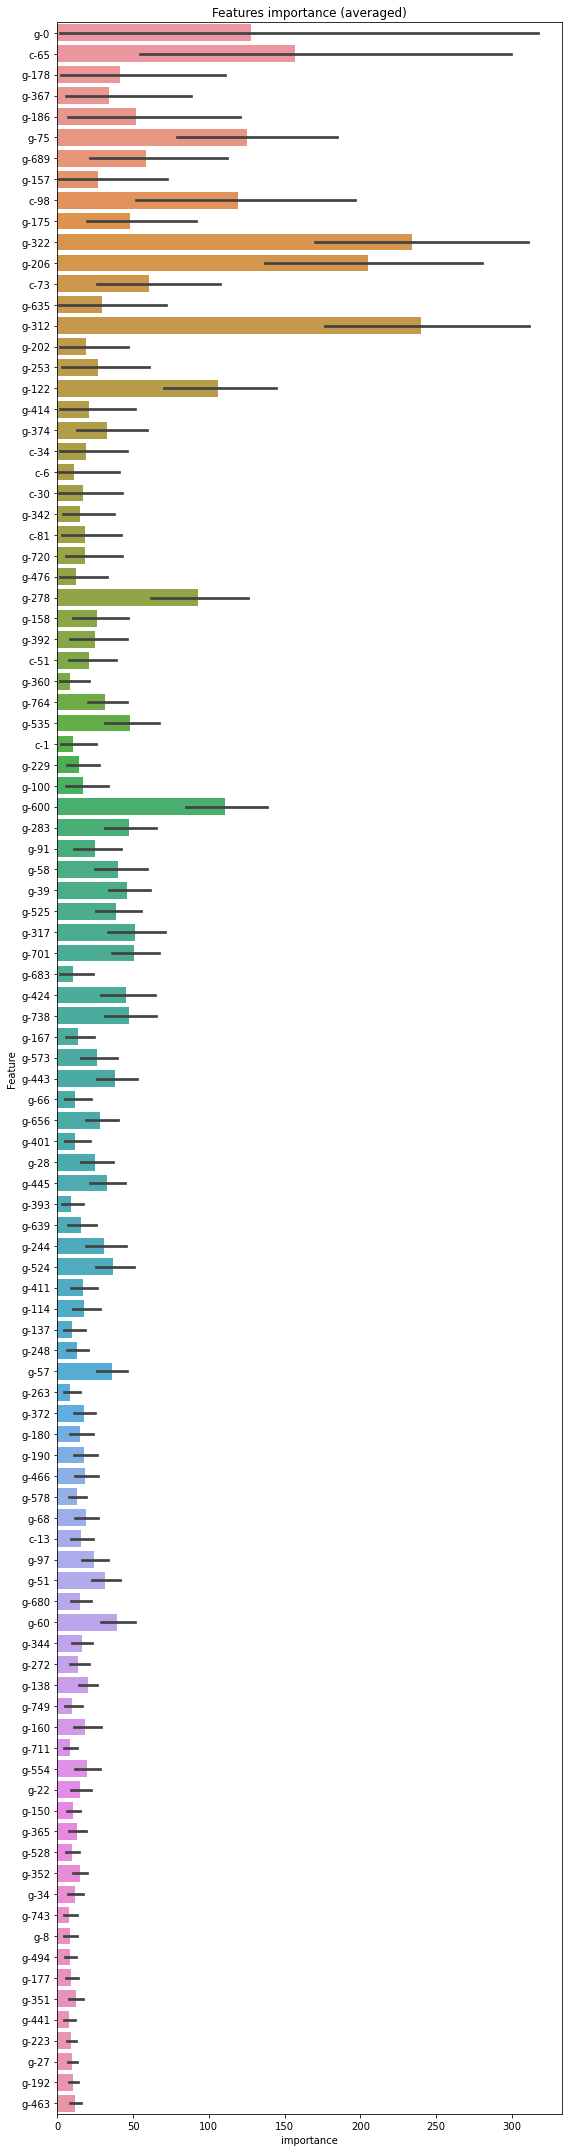

In [22]:
show_feature_importance(feature_importance_df)